# Connect Forest Management Model with Forest Carbon Budget Model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util_opt import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [3]:
# Define scenario options based on case study
scenario_options = {
    'redchris': ['no_cons','evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AAC_80%', 'redchrs_AAC_70%', 'redchrs_AAC_60%', 'redchrs_AAC_50%', 'redchrs_AAC_40%', 'redchrs_AAC_30%', 'redchrs_AAC_20%', 'redchrs_AAC_10%' ],
    'goldenbear': ['no_cons', 'evenflow_cons', 'gldbr_AAC_90%', 'gldbr_AAC_80%', 'gldbr_AAC_70%', 'gldbr_AAC_60%', 'gldbr_AAC_50%', 'gldbr_AAC_40%', 'gldbr_AAC_30%', 'gldbr_AAC_20%', 'gldbr_AAC_10%'],
    'equitysilver': [ 'no_cons','evenflow_cons', 'eqtslvr_AAC_90%', 'eqtslvr_AAC_80%', 'eqtslvr_AAC_70%', 'eqtslvr_AAC_60%', 'eqtslvr_AAC_50%', 'eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%'],
    'test': ['no_cons', 'evenflow_cons', 'bau_redchrs']
}

# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value

# Case study dropdown
case_study_dropdown = widgets.Dropdown(
    options=['redchris', 'goldenbear', 'equitysilver', 'test'],
    value='equitysilver',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['redchris'],  # Set initial options based on default case study
    value=scenario_options['redchris'][1],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_st',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=2, options=('redchris', 'goldenbear', 'equitysilver', 'test'), value…

Dropdown(description='Scenario:', index=1, options=('no_cons', 'evenflow_cons', 'redchrs_AAC_90%', 'redchrs_AA…

Dropdown(description='Objective:', index=2, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_st')

In [4]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [5]:
#Start Calculating the Running Time
Start = time.time()

In [6]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [7]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'redchris': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris'
    },
    'goldenbear': {
        'model_name': 'goldenbear',
        'model_path': './data/woodstock_model_files_goldenbear'
    },
    'equitysilver': {
        'model_name': 'equitysilver',
        'model_path': './data/woodstock_model_files_equitysilver'
    },
    'test': {
        'model_name': 'redchris',
        'model_path': './data/woodstock_model_files_redchris_test'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [8]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Read curves
file_directory = "./inputs/curves"
file_names = [f"{case_study}_c_curves_p.pkl", f"{case_study}_c_curves_f.pkl"]
loaded_data = {}

for filename in file_names:
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'rb') as file:
        loaded_data[filename] = pickle.load(file)
    print(f"Loaded data from {file_path}")

c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

Loaded data from ./inputs/curves/equitysilver_c_curves_p.pkl
Loaded data from ./inputs/curves/equitysilver_c_curves_f.pkl


In [12]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for equitysilver_max_st_no_cons...
running no_cons scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17023 rows, 83258 columns and 83258 nonzeros
Model fingerprint: 0xb81e485a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17023 rows and 83258 columns
Presolve time: 0.05s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2133245e+08   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.07 seconds (0.03 work units)
Optimal objective  2.213324476e+08


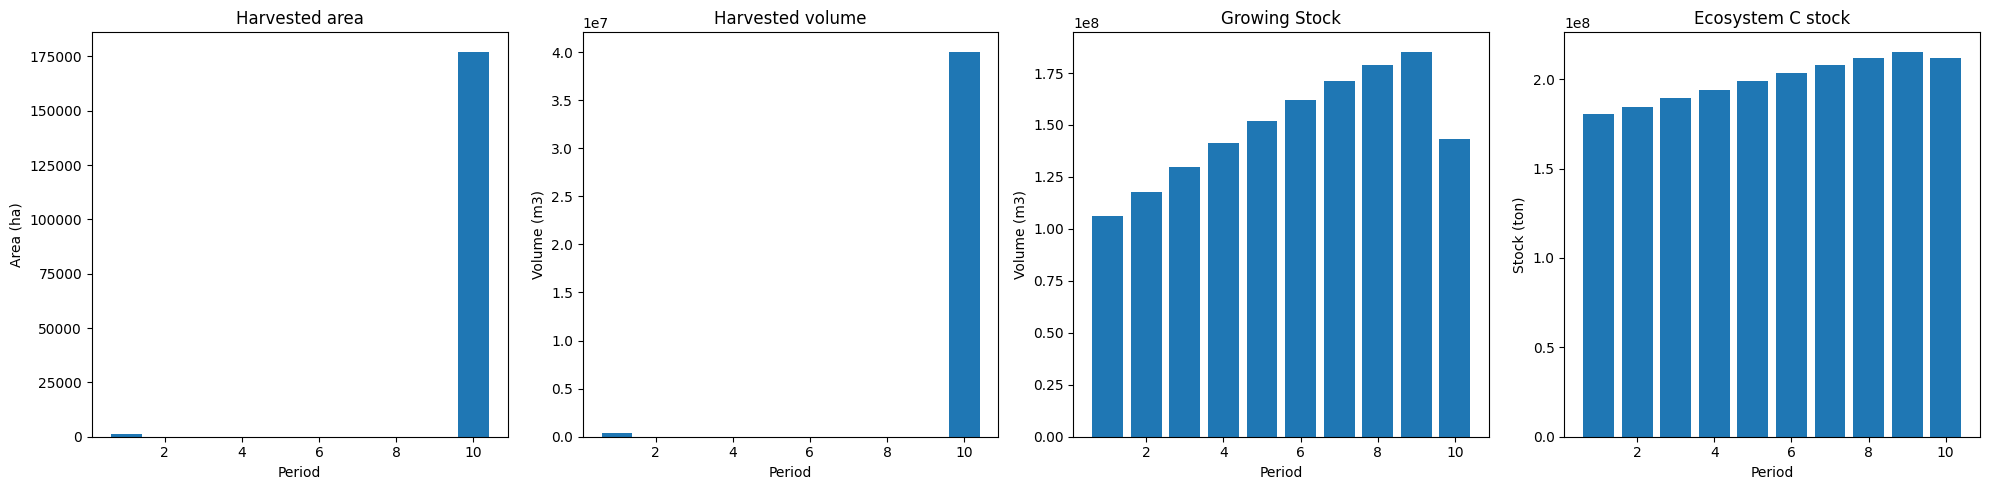

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_no_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  42718
The economic indicator (the provincial government revenues) is:  1456798
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


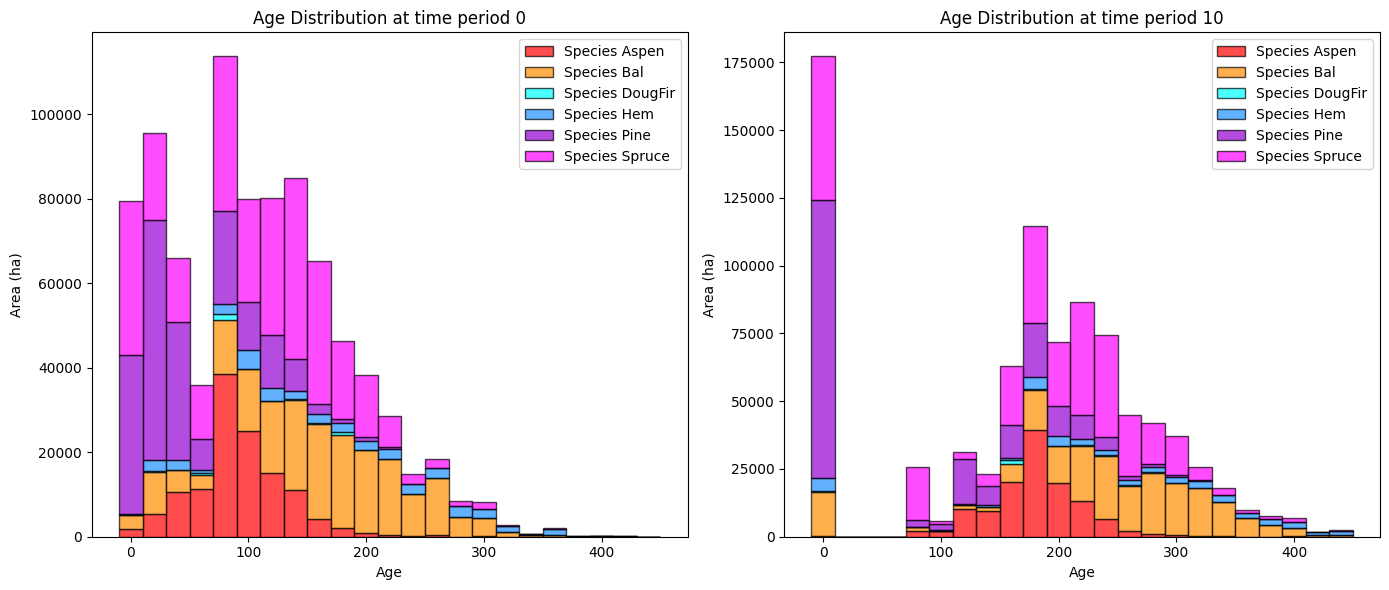

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_no_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   31476.197359   12324.070130
DougFir    947.047810    2746.575967    1799.528157
Bal      59315.970469  154214.829174   94898.858705
Spruce   36410.744598  194239.993369  157829.248771
Aspen    29632.731169  116864.820445   87232.089276
Pine      7432.733686   56935.724172   49502.990486

Old growth has **increased** by 403586.79 hectares from time period 0 to time period 10.


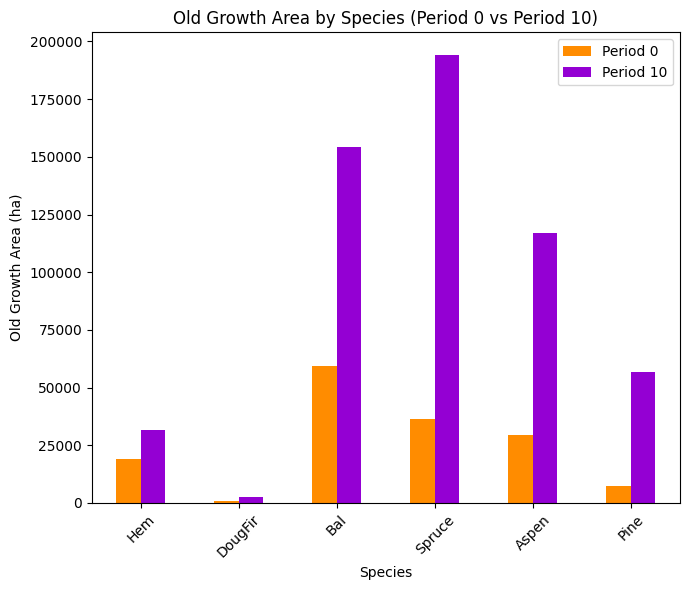

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_no_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7618

Diversity has **increased** by 0.26% from time 0 to time 10.


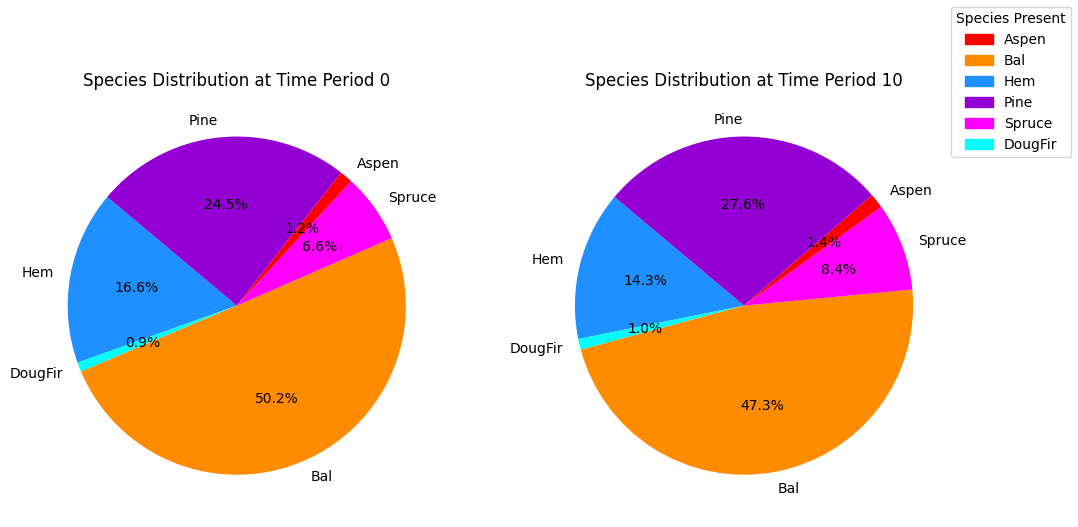

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_no_cons_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.28s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering t

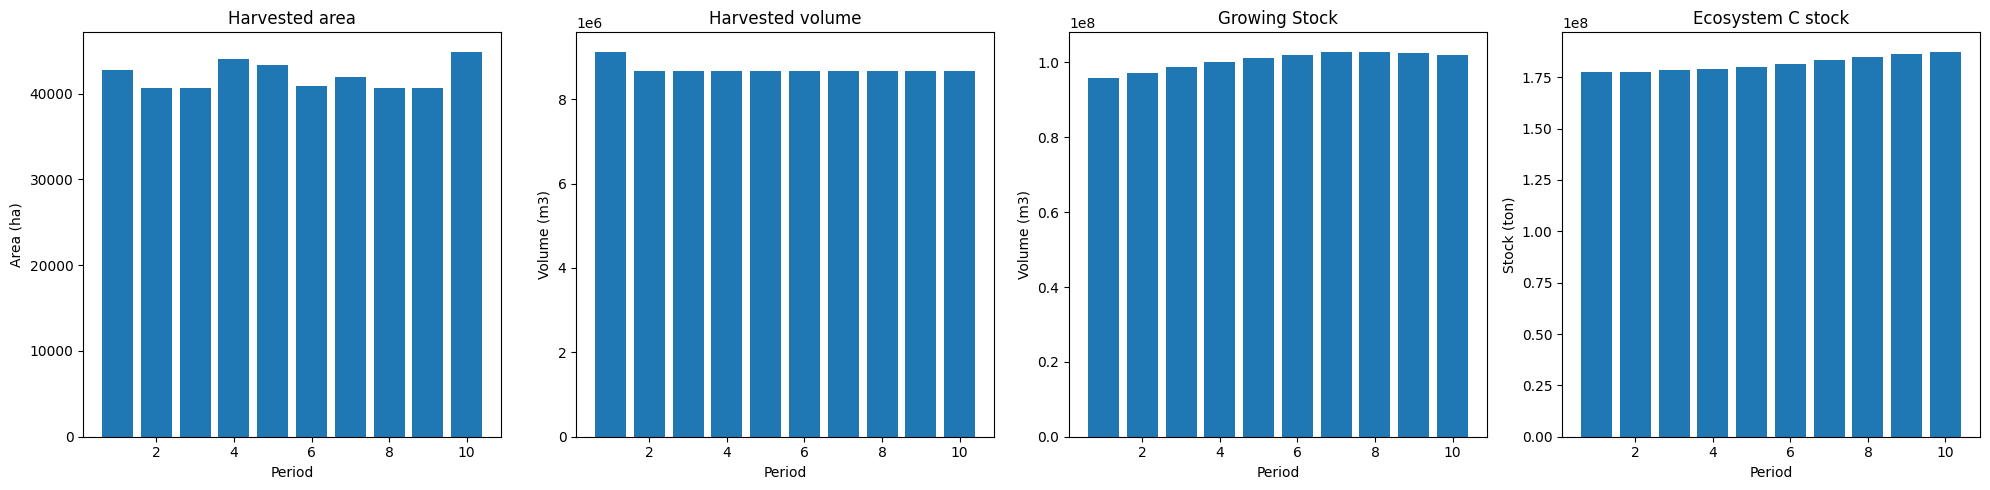

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


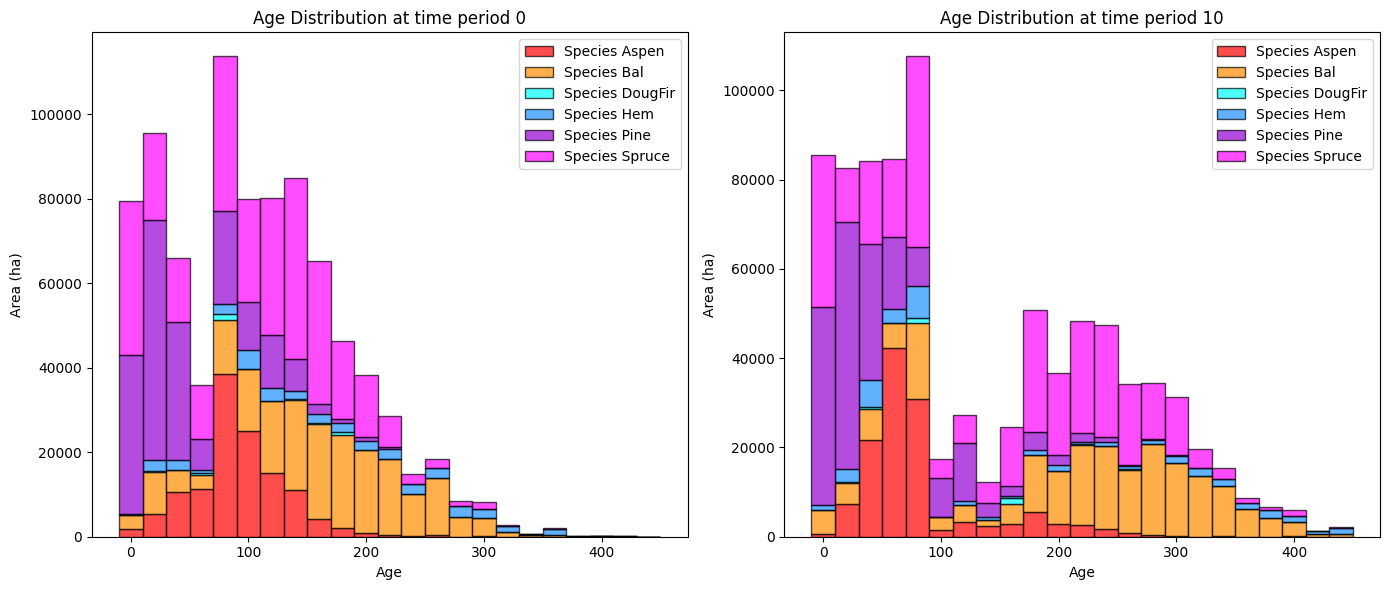

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


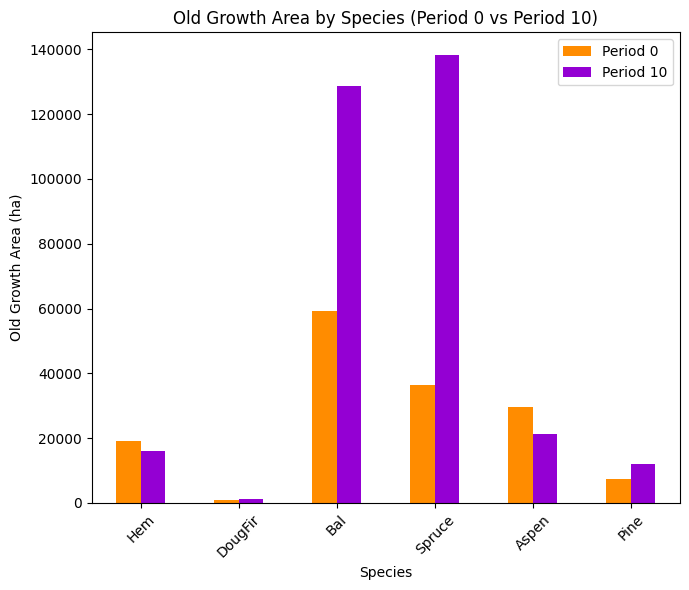

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


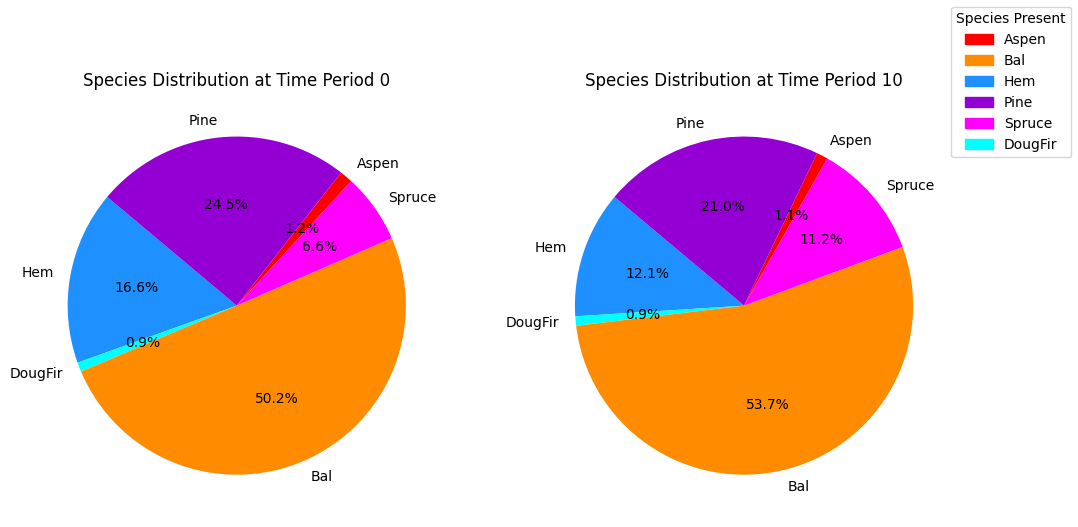

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


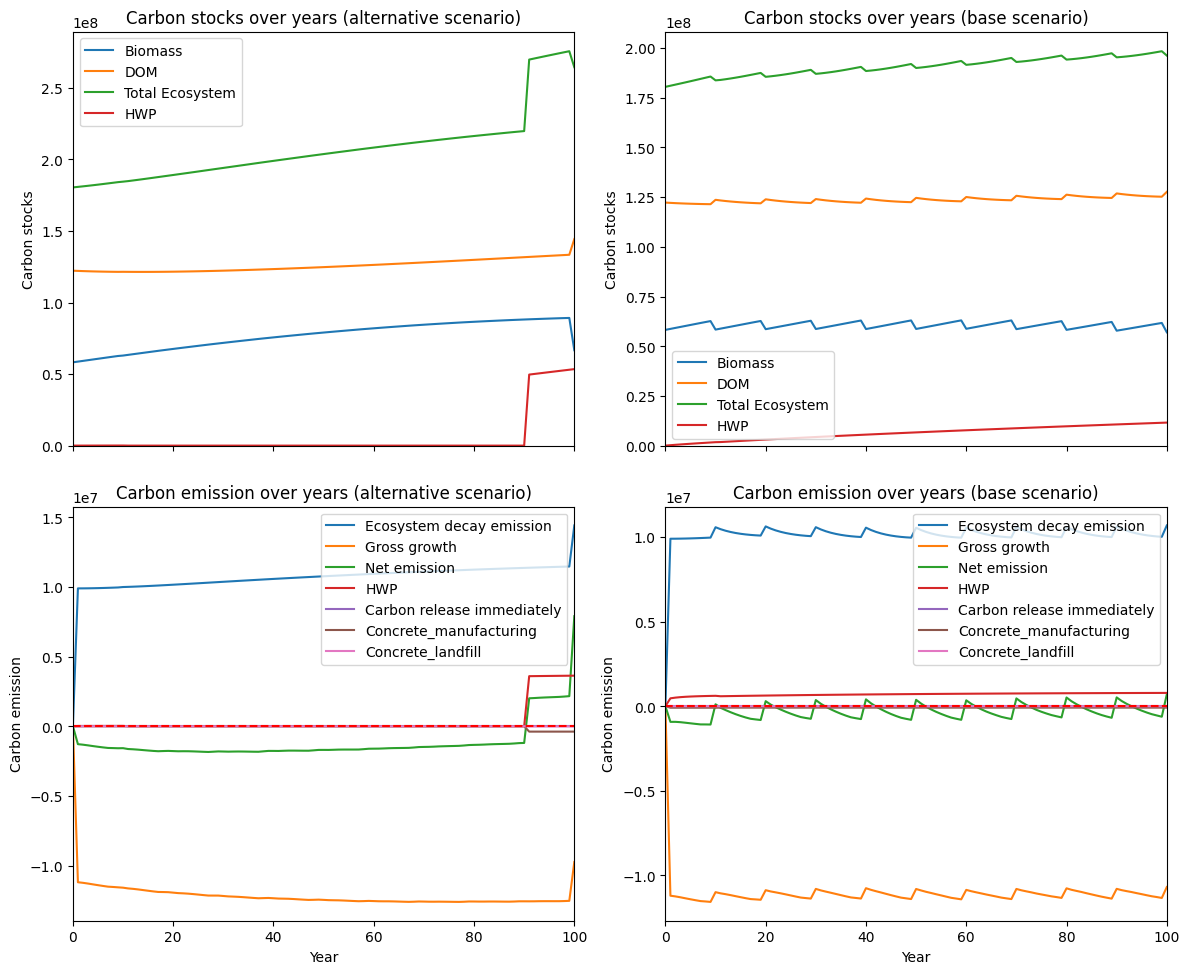

---------------------------------------------------------------------------------------
Net emission difference -83651331.8468734
Net emission base scenario -34255783.53595837
Net emission alternative scenario -117907115.38283174
dollar_per_ton is:  0.11954382290416295
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  15368.458640  15368.458640
DougFir  0.0   1447.273325   1447.273325
Bal      0.0  25408.831388  25408.831388
Spruce   0.0  55891.605082  55891.605082
Aspen    0.0  95660.561122  95660.561122
Pine     0.0  45032.689136  45032.689136

Overall, the old growth area has **increased** by 238809.42 hectares in the alternative scenario compared to the base scenario.


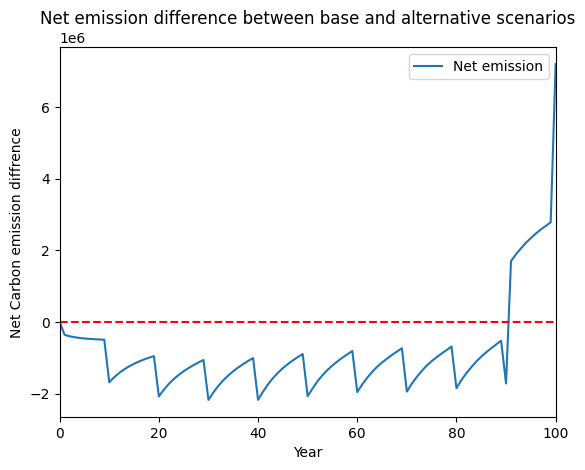

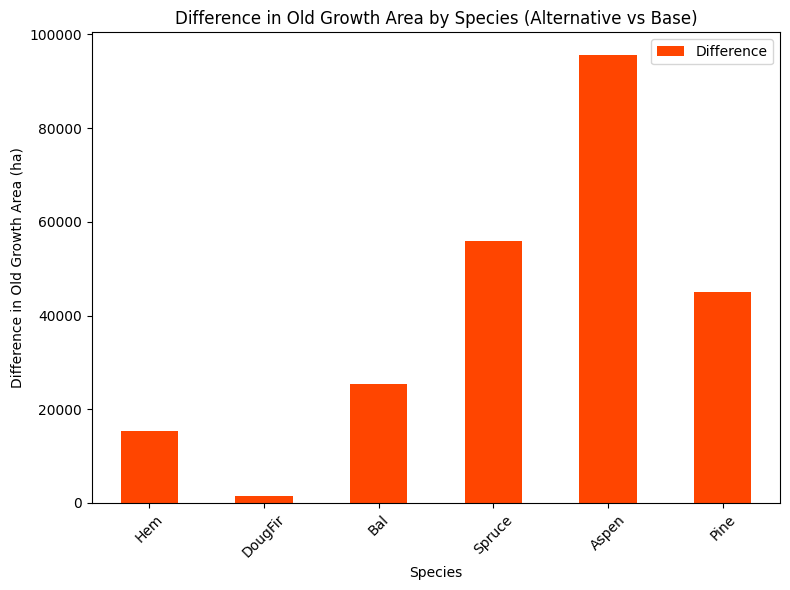

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


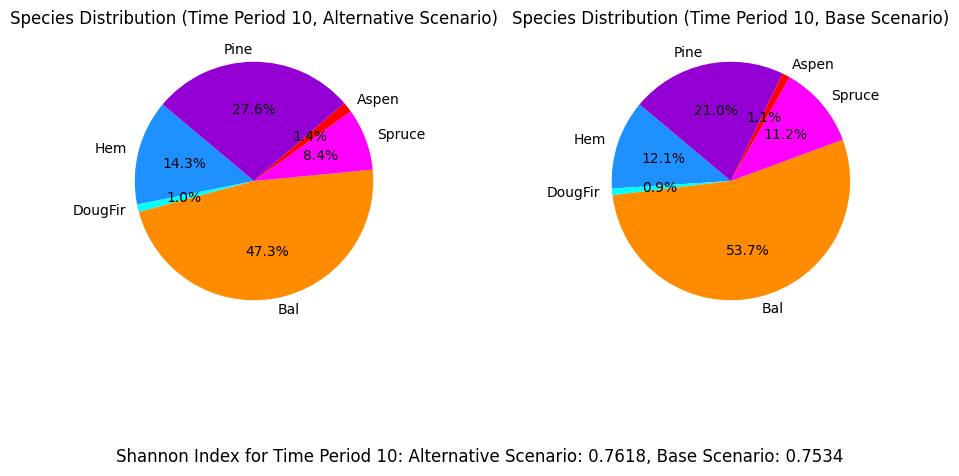

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_evenflow_cons...
running even flow constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17063 rows, 83258 columns and 514878 nonzeros
Model fingerprint: 0xb58cf27a
Coefficient statistics:
  Matrix range     [5e-03, 6e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 8690 rows and 8884 columns
Presolve time: 0.18s
Presolved: 8373 rows, 74374 columns, 486421 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Orde

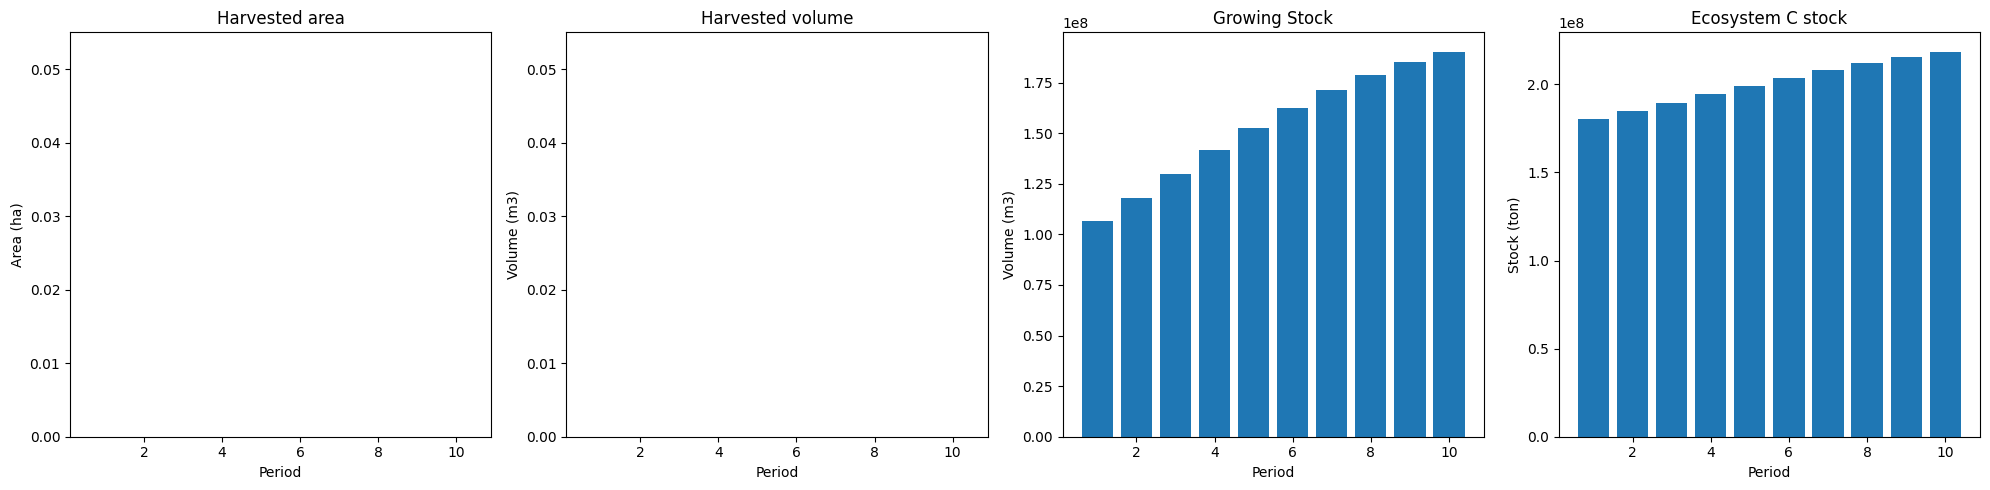

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_evenflow_cons_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


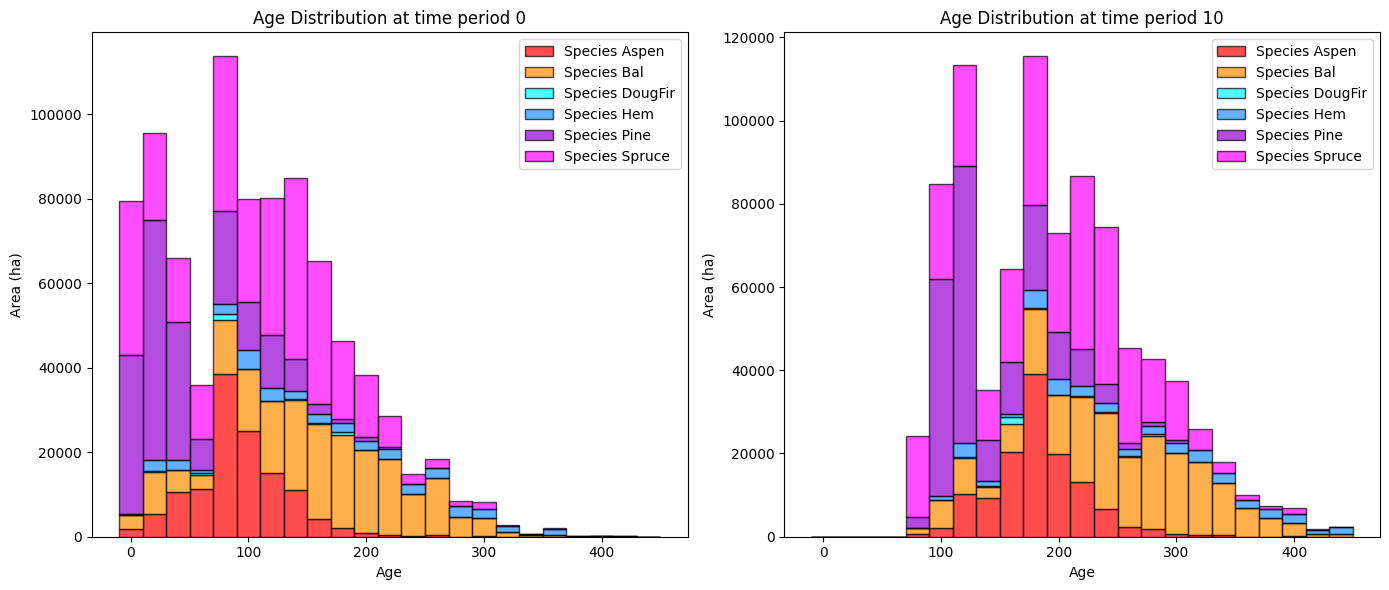

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_evenflow_cons_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   32688.964561   13536.837333
DougFir    947.047810    2749.298212    1802.250402
Bal      59315.970469  157689.747715   98373.777247
Spruce   36410.744598  198358.607639  161947.863041
Aspen    29632.731169  118345.834248   88713.103079
Pine      7432.733686   70671.811755   63239.078069

Old growth has **increased** by 427612.91 hectares from time period 0 to time period 10.


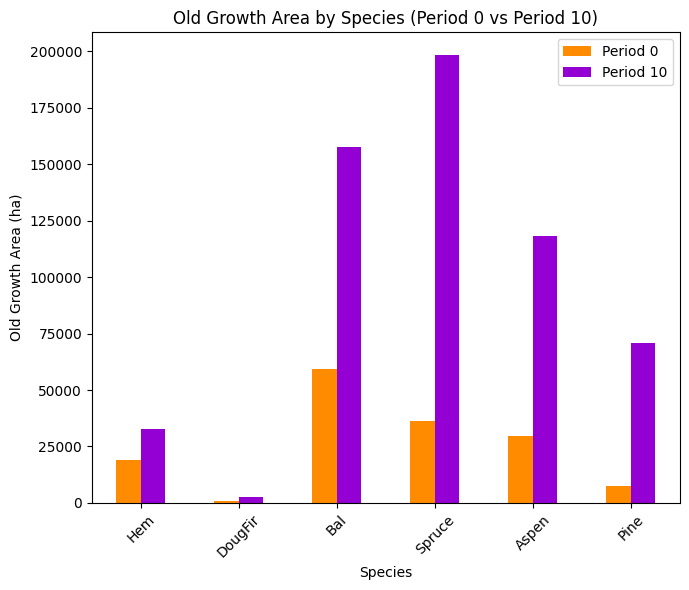

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_evenflow_cons_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7457

Diversity has **decreased** by 1.35% from time 0 to time 10.


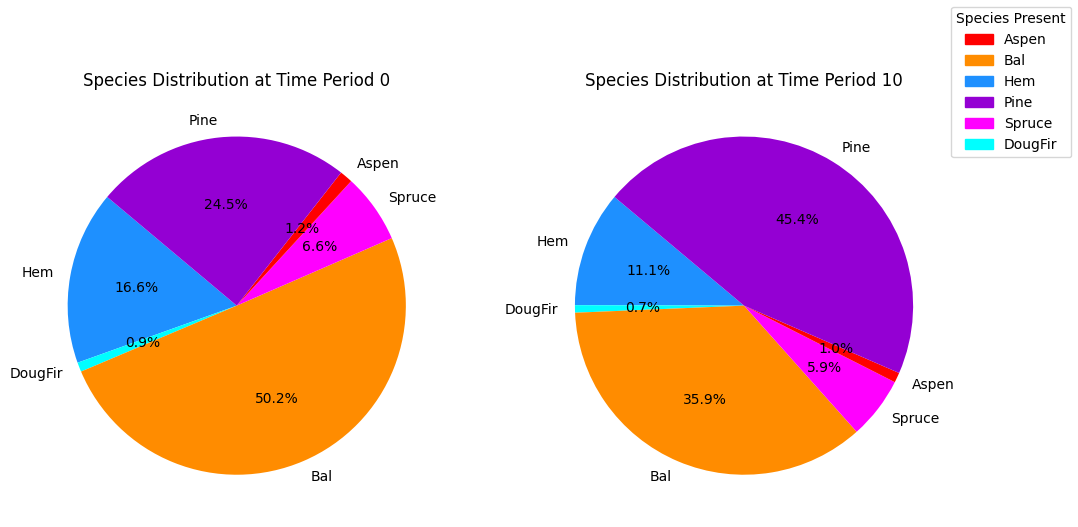

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_evenflow_cons_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.27s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Orde

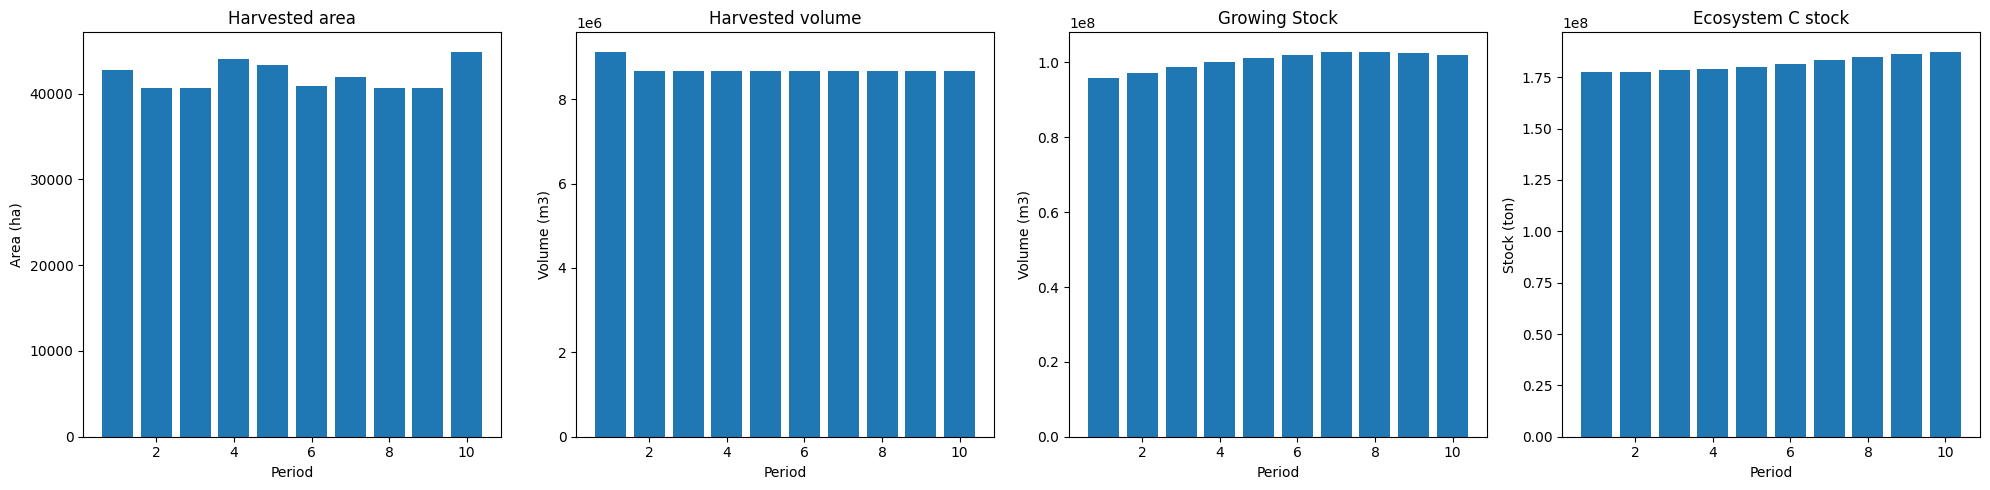

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


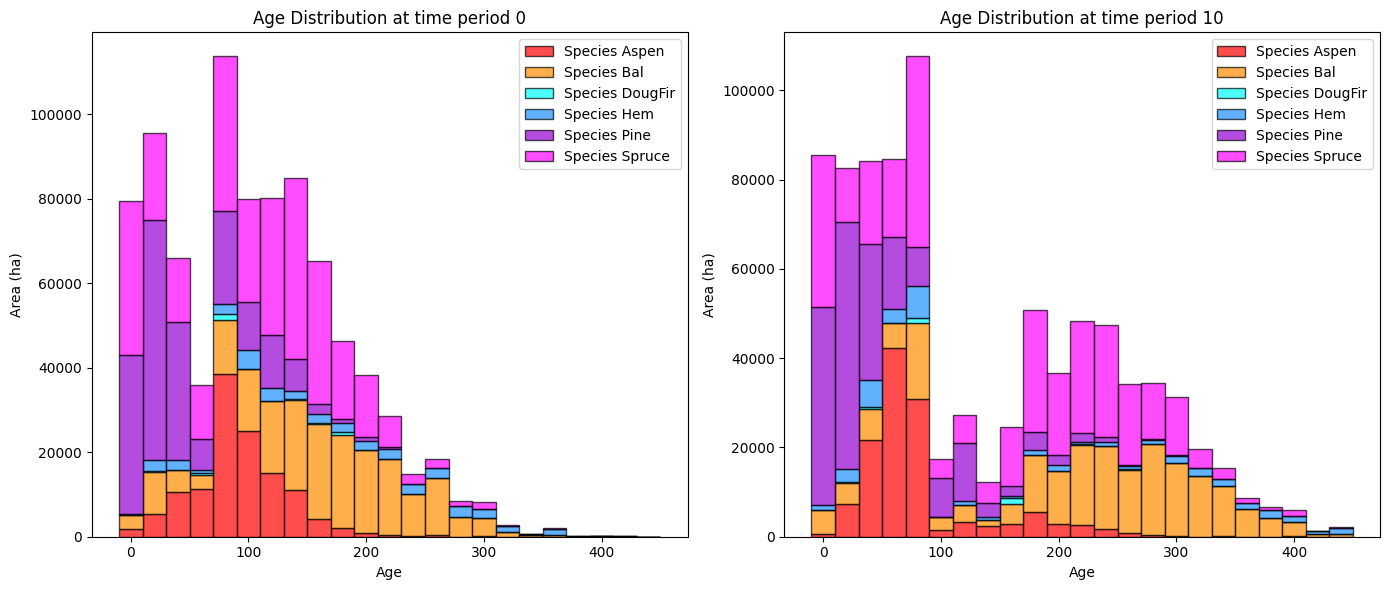

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


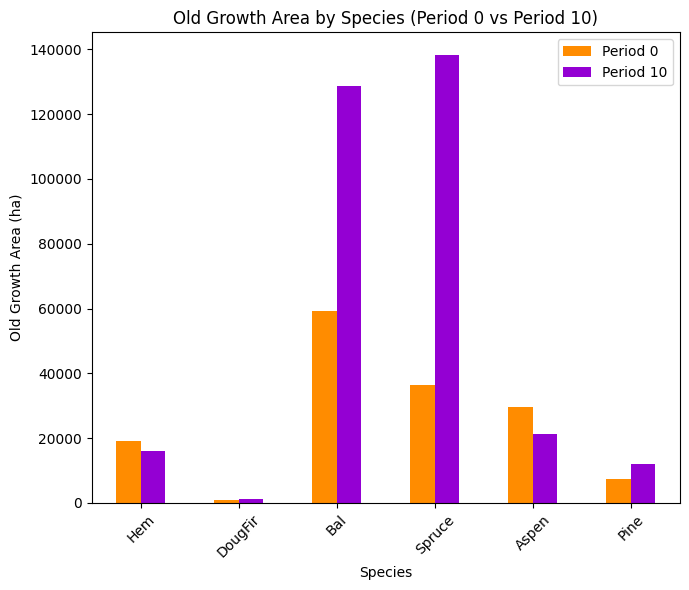

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


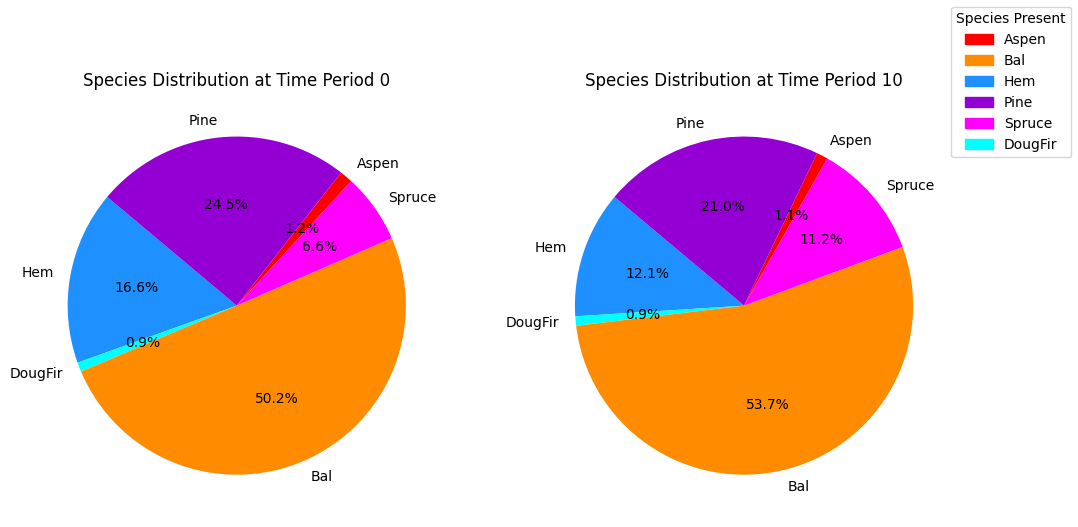

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


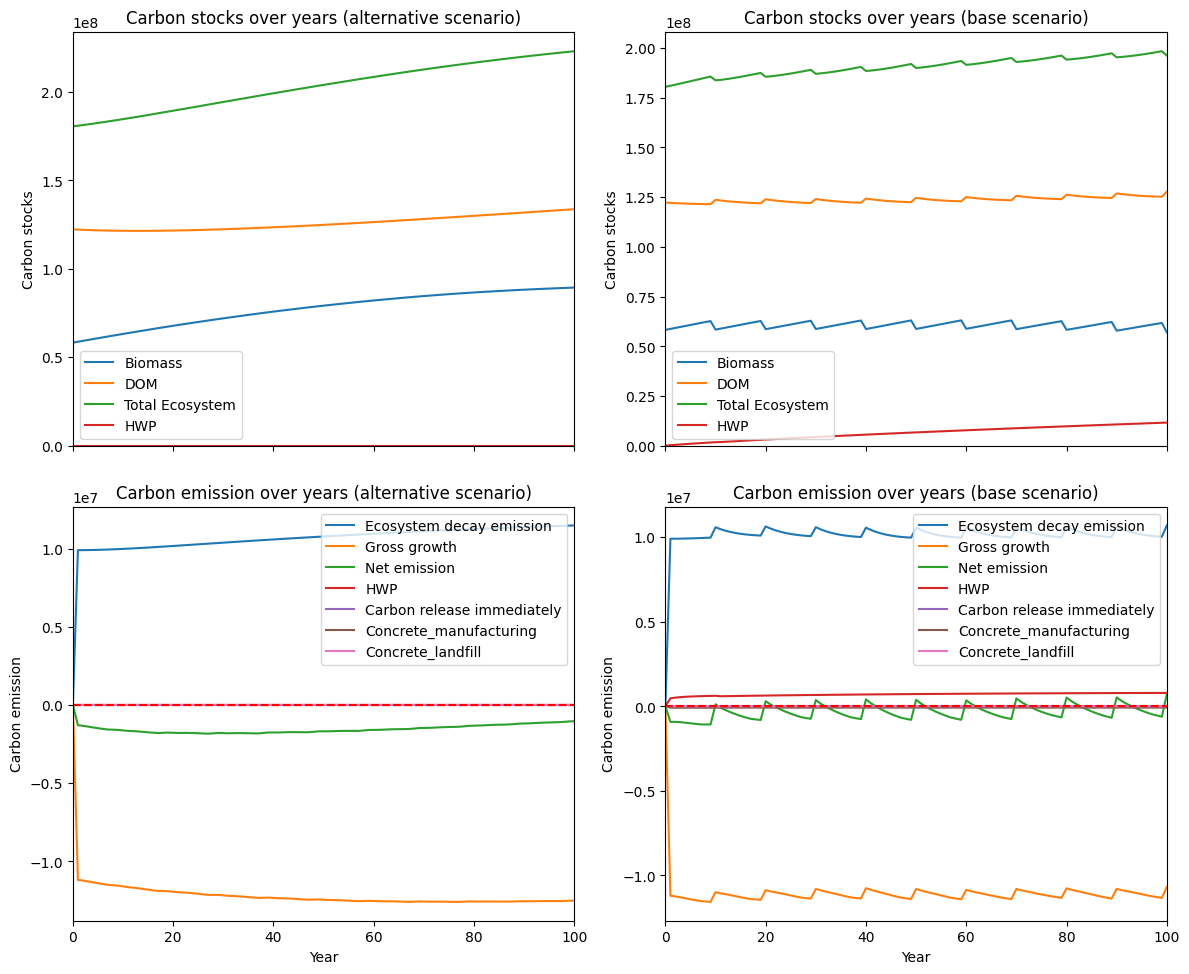

---------------------------------------------------------------------------------------
Net emission difference -121368863.60294037
Net emission base scenario -34255783.53595837
Net emission alternative scenario -155624647.13889873
dollar_per_ton is:  0.08239345498624025
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  16581.225843  16581.225843
DougFir  0.0   1449.995570   1449.995570
Bal      0.0  28883.749929  28883.749929
Spruce   0.0  60010.219352  60010.219352
Aspen    0.0  97141.574925  97141.574925
Pine     0.0  58768.776718  58768.776718

Overall, the old growth area has **increased** by 262835.54 hectares in the alternative scenario compared to the base scenario.


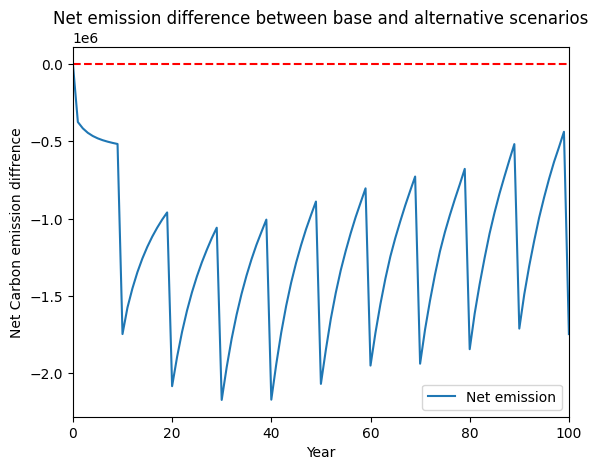

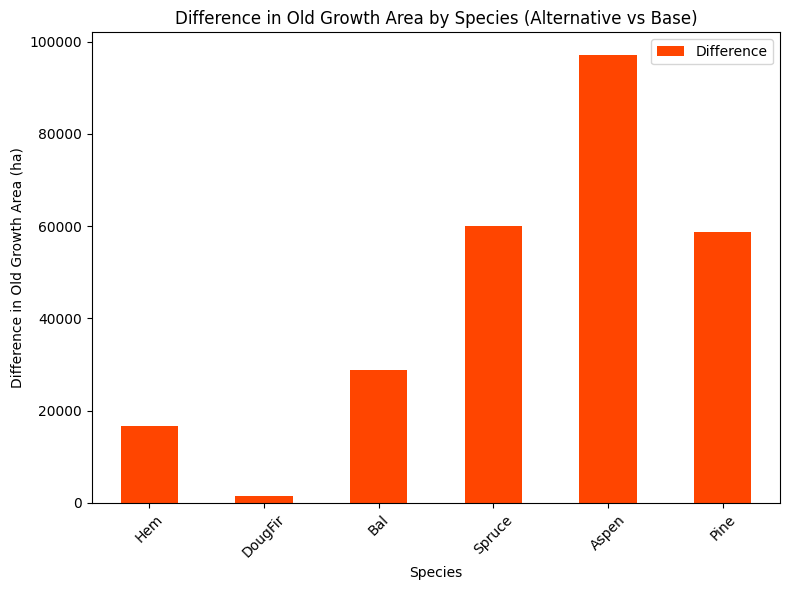

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


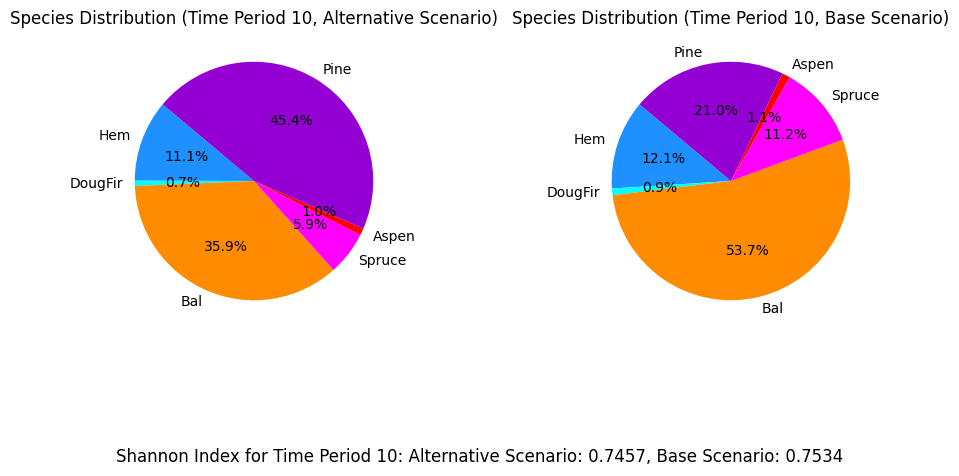

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_90%...
running the scenario for the Equity Silver mining site (90%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x407407ce
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.22s
Presolved: 8375 r

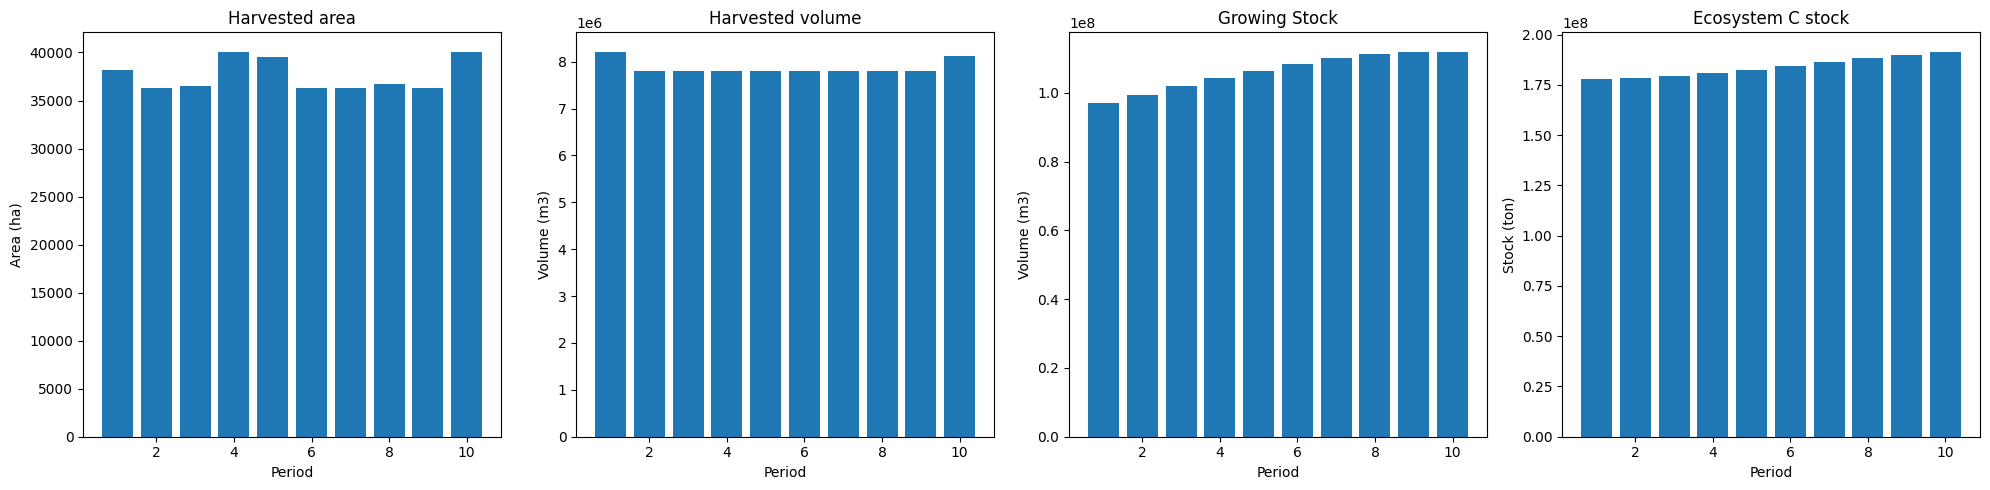

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_90%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  83272
The economic indicator (the provincial government revenues) is:  2839766
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


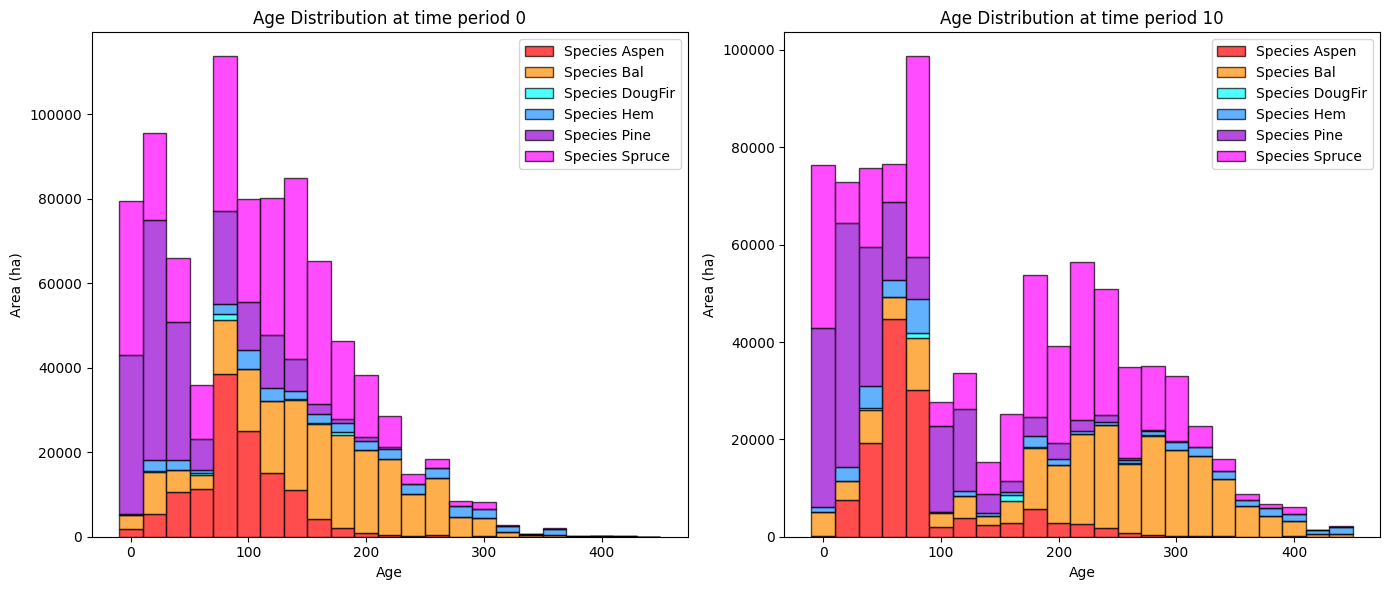

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_90%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   17058.402446   -2093.724783
DougFir    947.047810    1383.246695     436.198885
Bal      59315.970469  136664.116562   77348.146094
Spruce   36410.744598  152478.903158  116068.158560
Aspen    29632.731169   21660.488536   -7972.242633
Pine      7432.733686   13777.020899    6344.287213

Old growth has **increased** by 190130.82 hectares from time period 0 to time period 10.


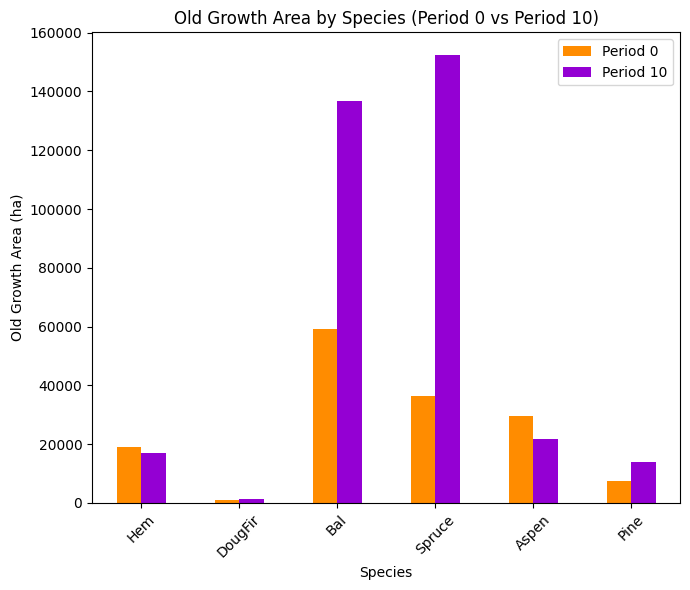

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_90%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7507

Diversity has **decreased** by 0.85% from time 0 to time 10.


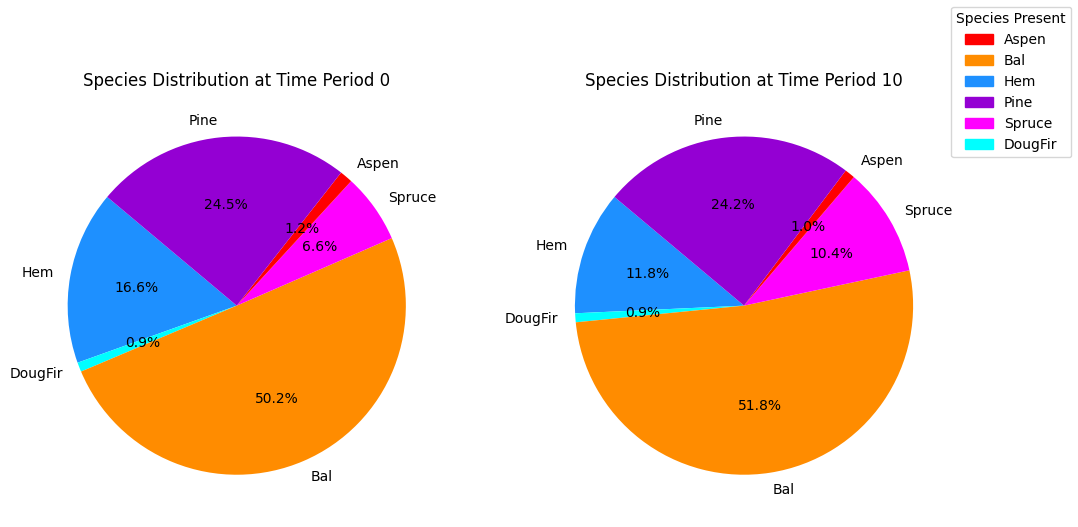

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_90%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.26s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

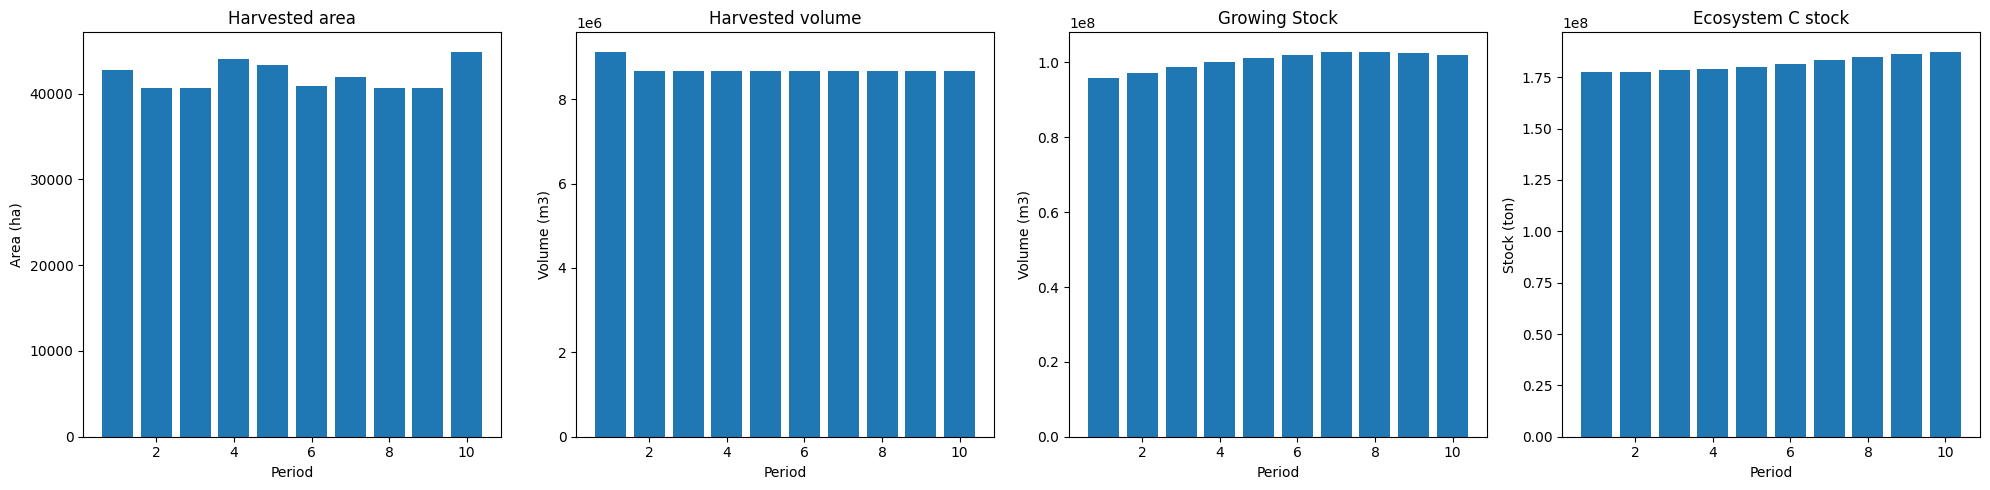

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


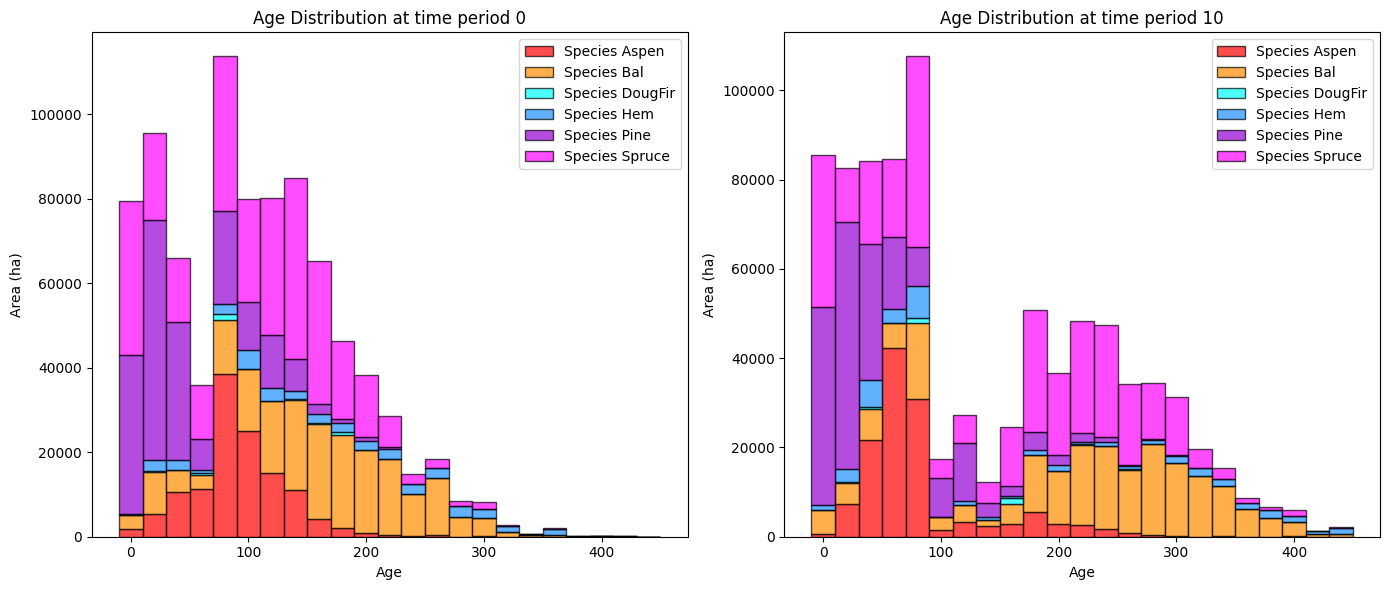

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


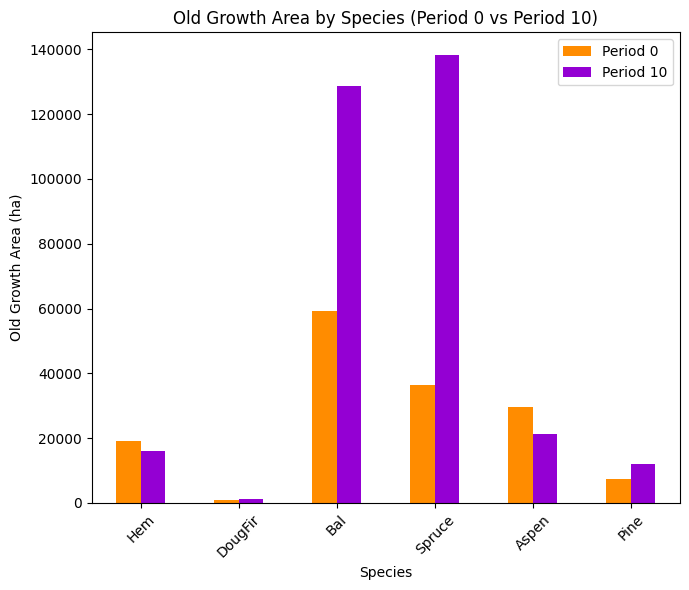

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


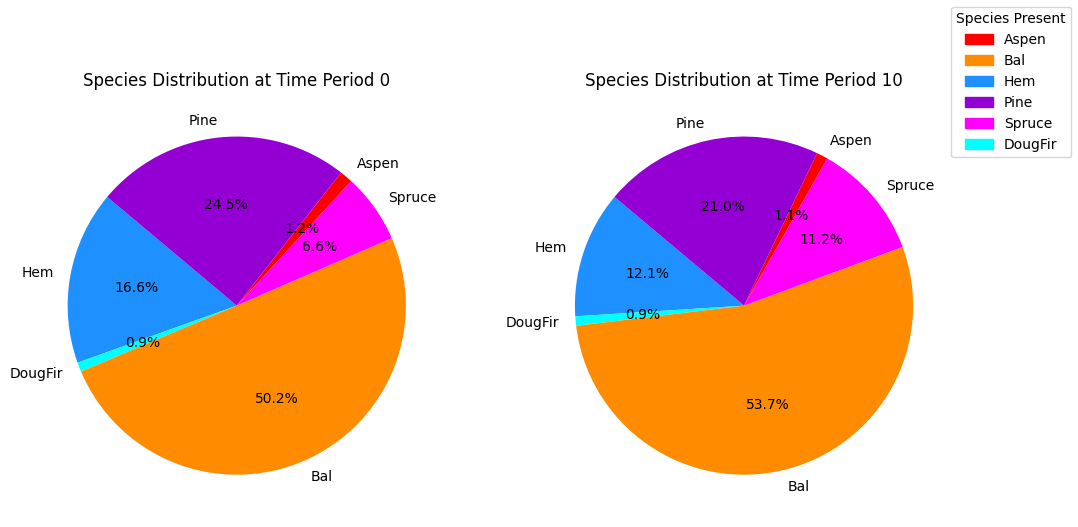

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


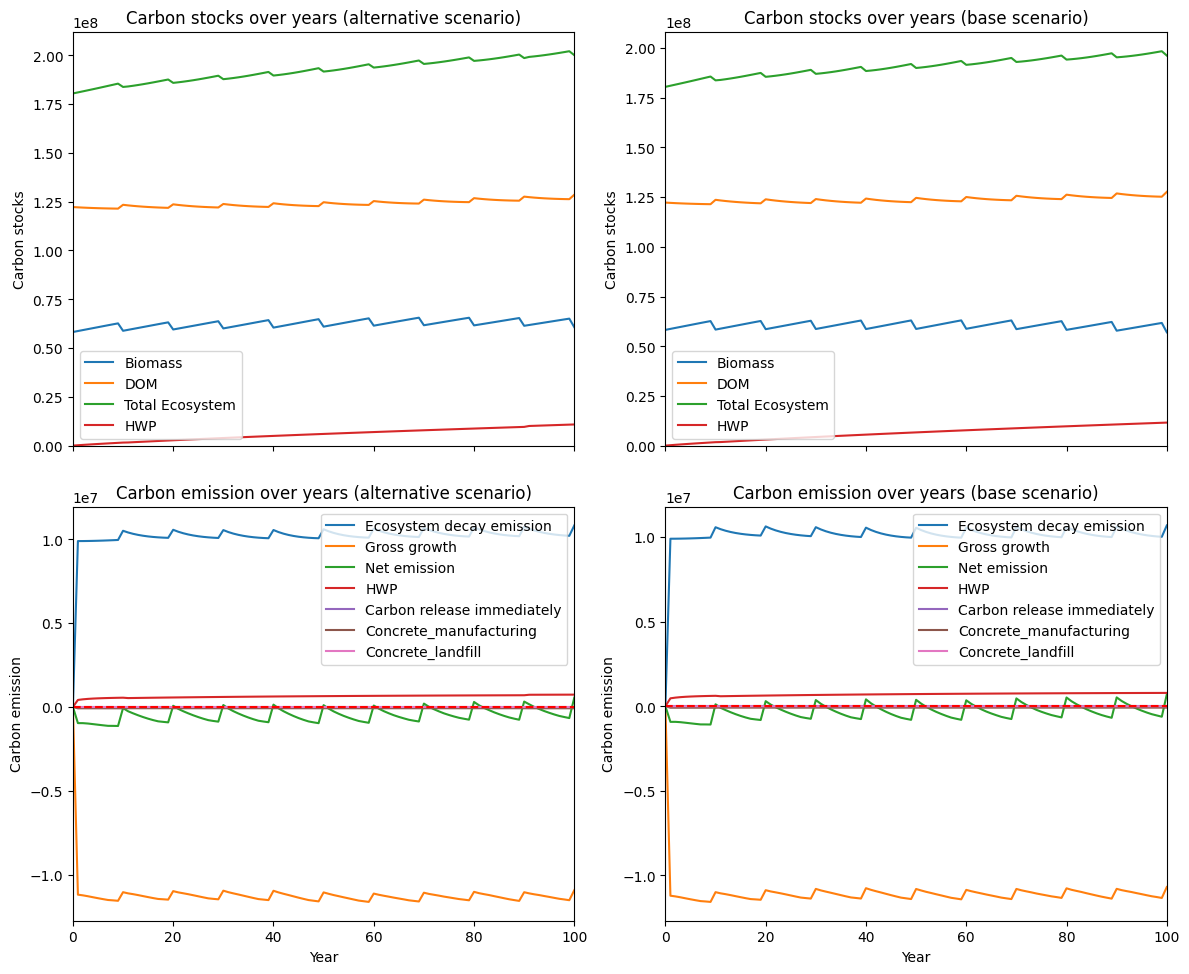

---------------------------------------------------------------------------------------
Net emission difference -15416912.46029438
Net emission base scenario -34255783.53595837
Net emission alternative scenario -49672695.996252745
dollar_per_ton is:  0.6486383071678318
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0    950.663727    950.663727
DougFir  0.0     83.944053     83.944053
Bal      0.0   7858.118776   7858.118776
Spruce   0.0  14130.514872  14130.514872
Aspen    0.0    456.229213    456.229213
Pine     0.0   1873.985862   1873.985862

Overall, the old growth area has **increased** by 25353.46 hectares in the alternative scenario compared to the base scenario.


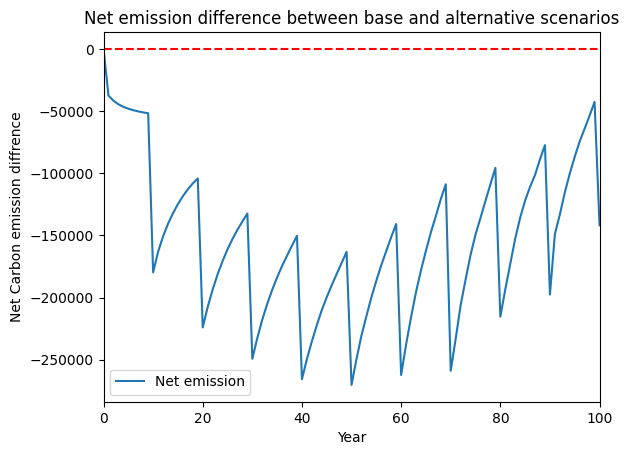

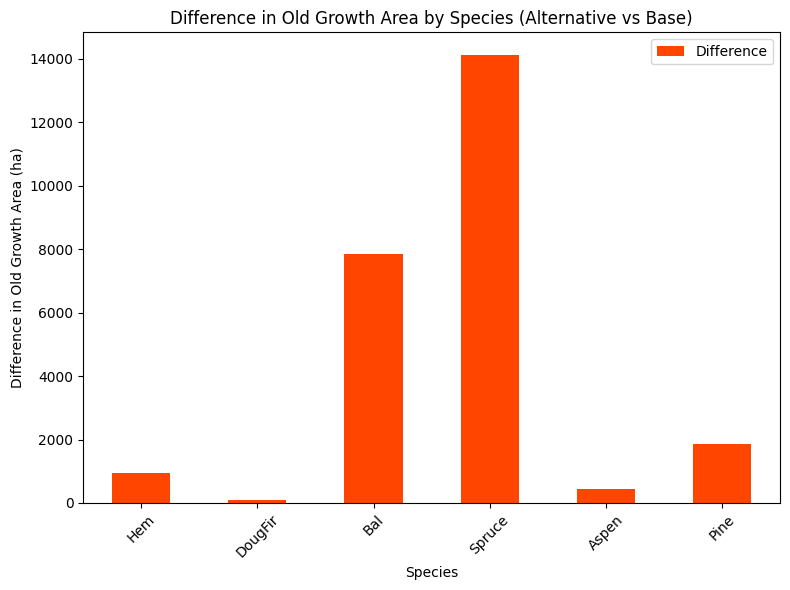

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


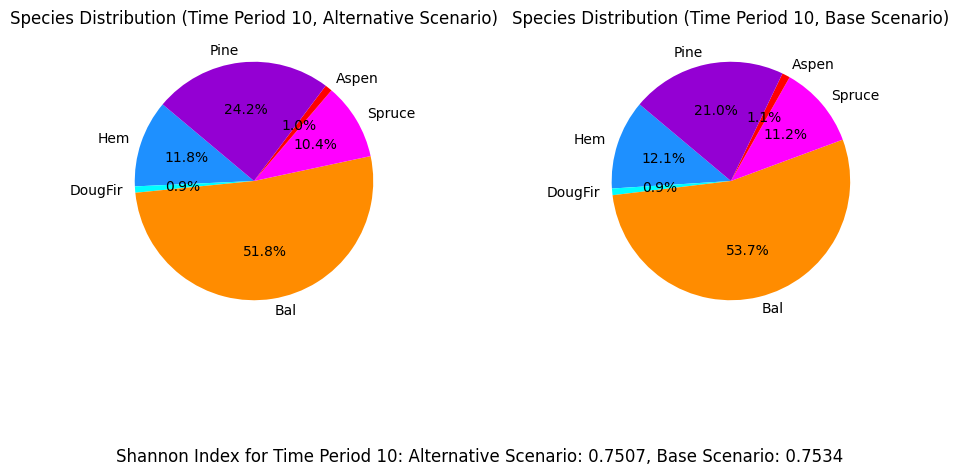

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_80%...
running the scenario for the Equity Silver mining site (80%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xe111fb4e
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.24s
Presolved: 8375 r

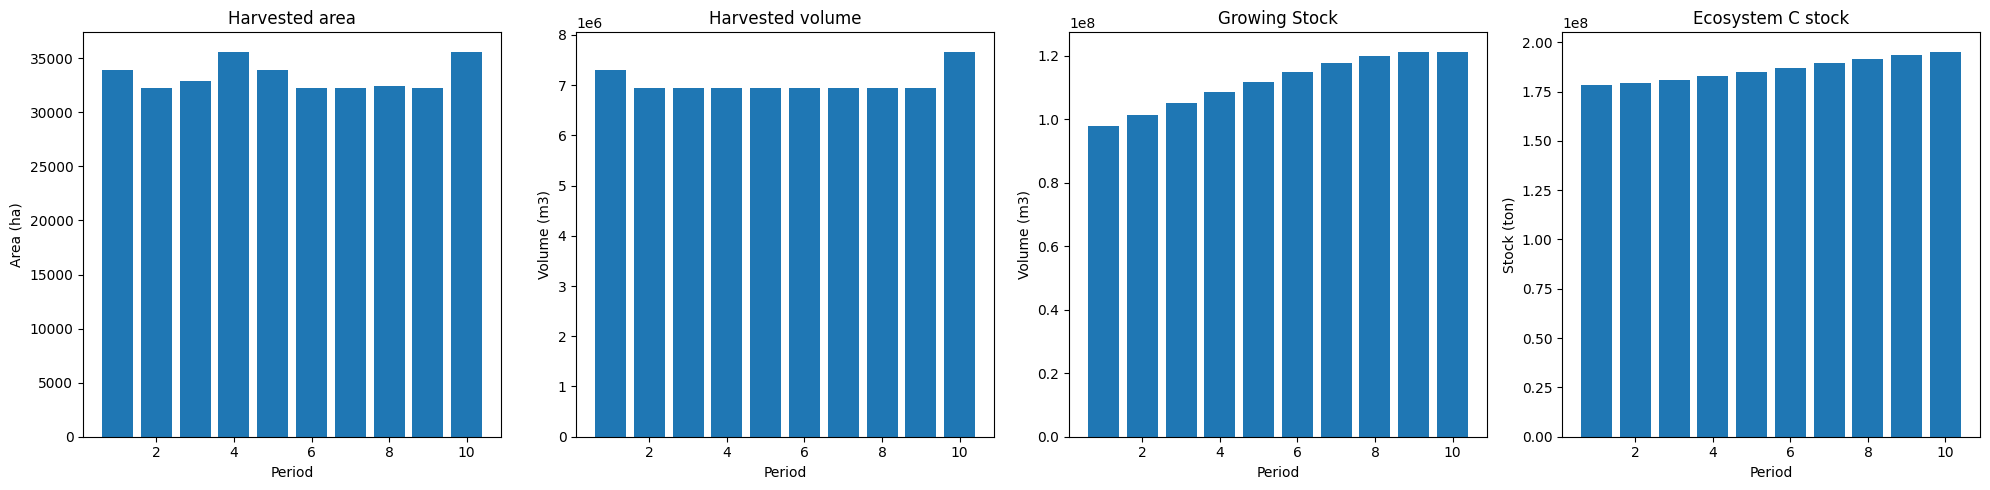

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_80%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  74497
The economic indicator (the provincial government revenues) is:  2540532
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


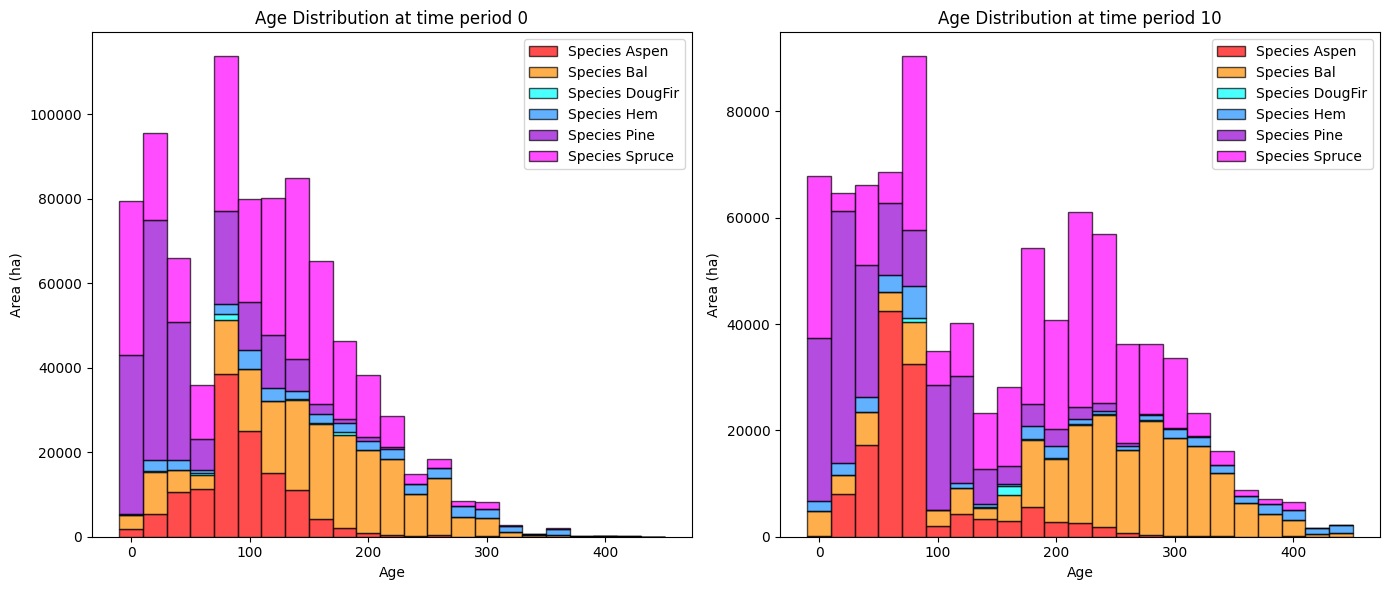

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_80%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   19716.581290     564.454061
DougFir    947.047810    1786.088129     839.040319
Bal      59315.970469  140622.705396   81306.734927
Spruce   36410.744598  165571.338780  129160.594182
Aspen    29632.731169   22502.327485   -7130.403684
Pine      7432.733686   16197.278553    8764.544867

Old growth has **increased** by 213504.96 hectares from time period 0 to time period 10.


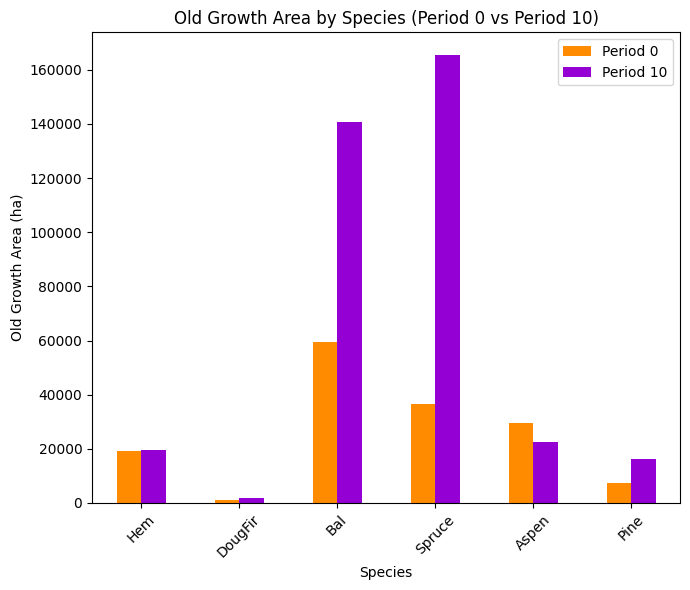

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_80%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7484

Diversity has **decreased** by 1.07% from time 0 to time 10.


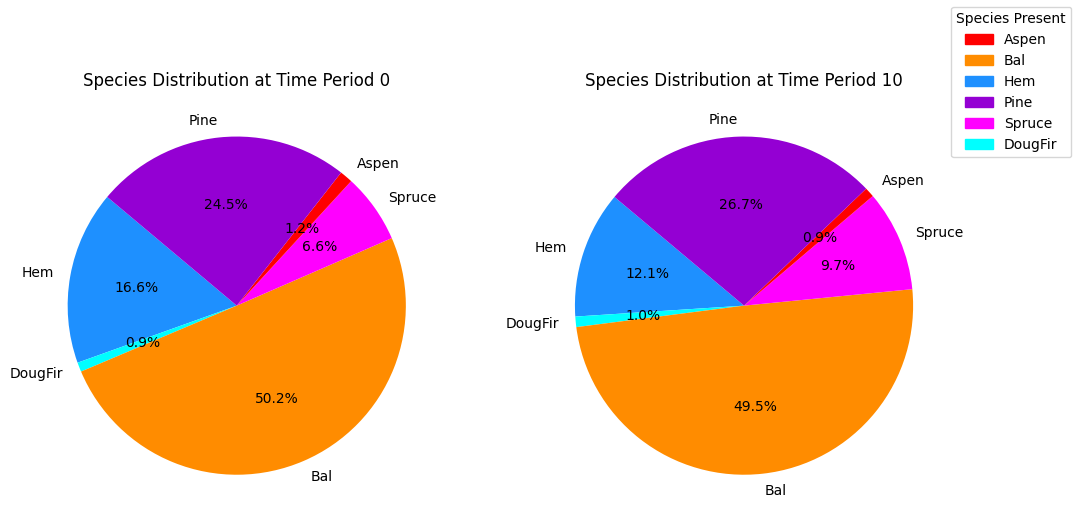

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_80%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.28s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

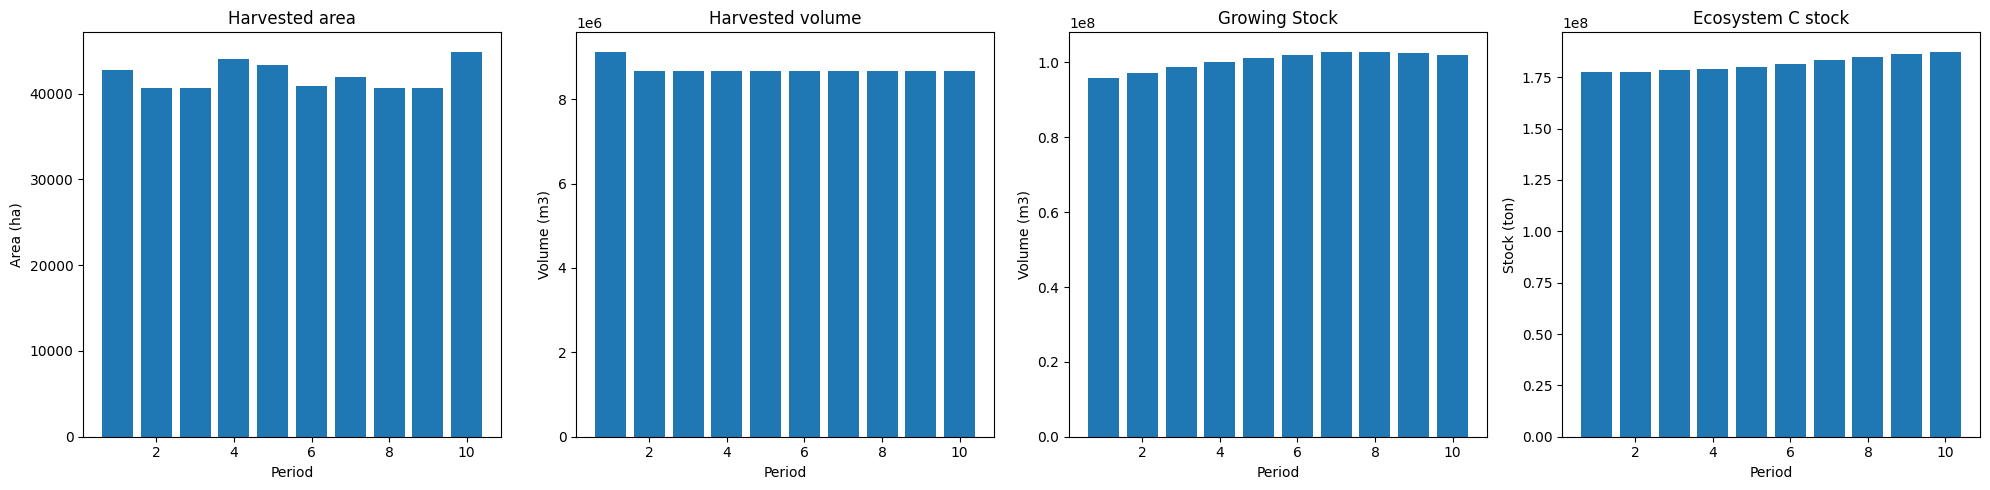

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


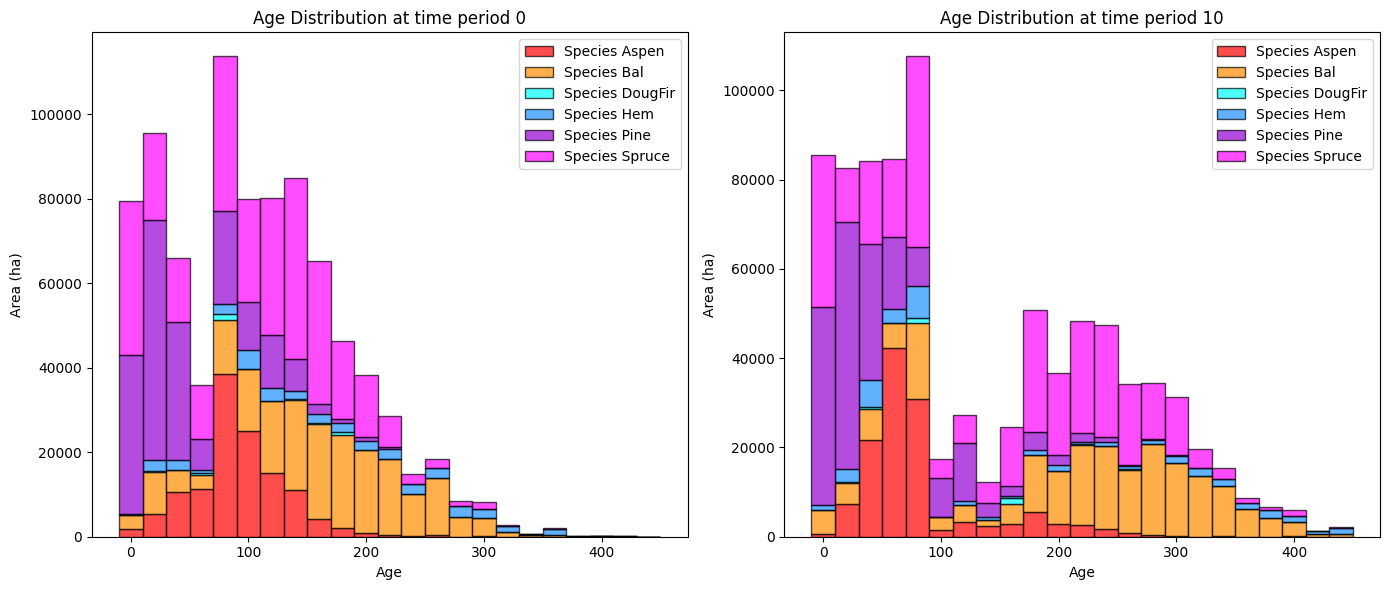

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


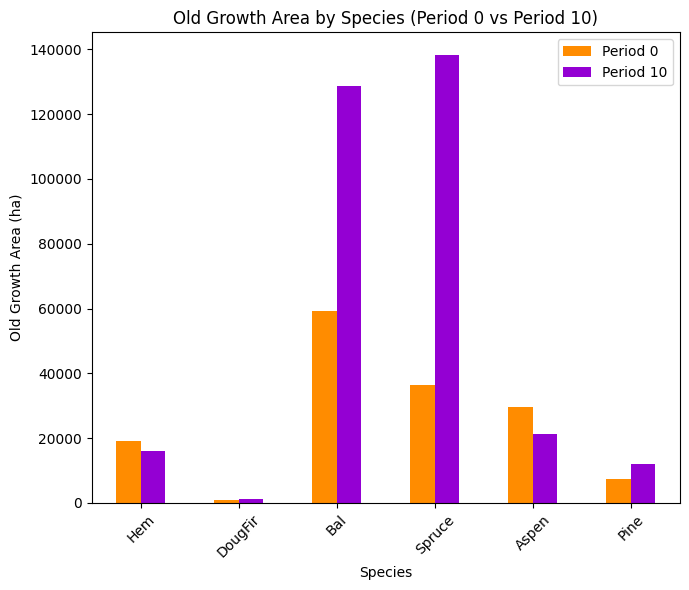

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


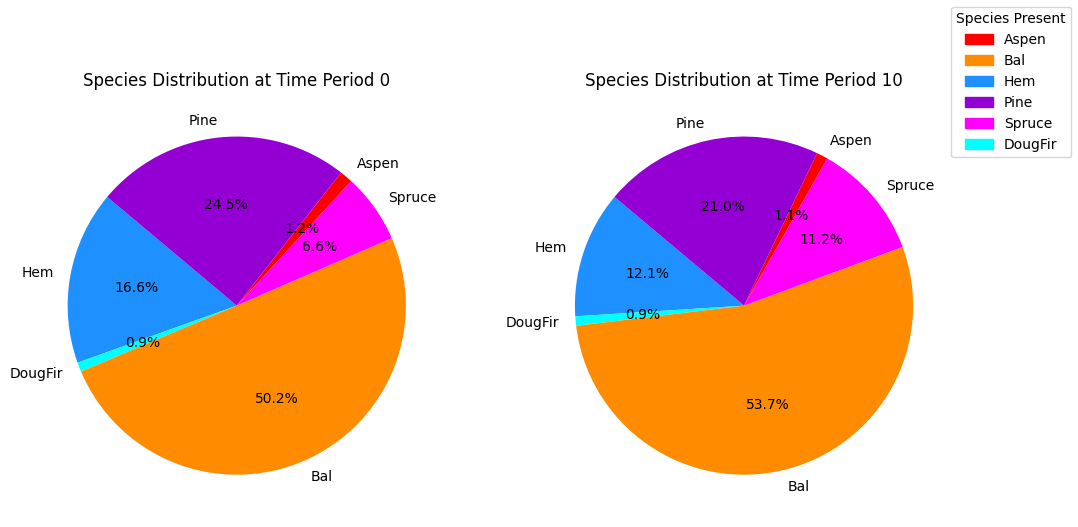

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


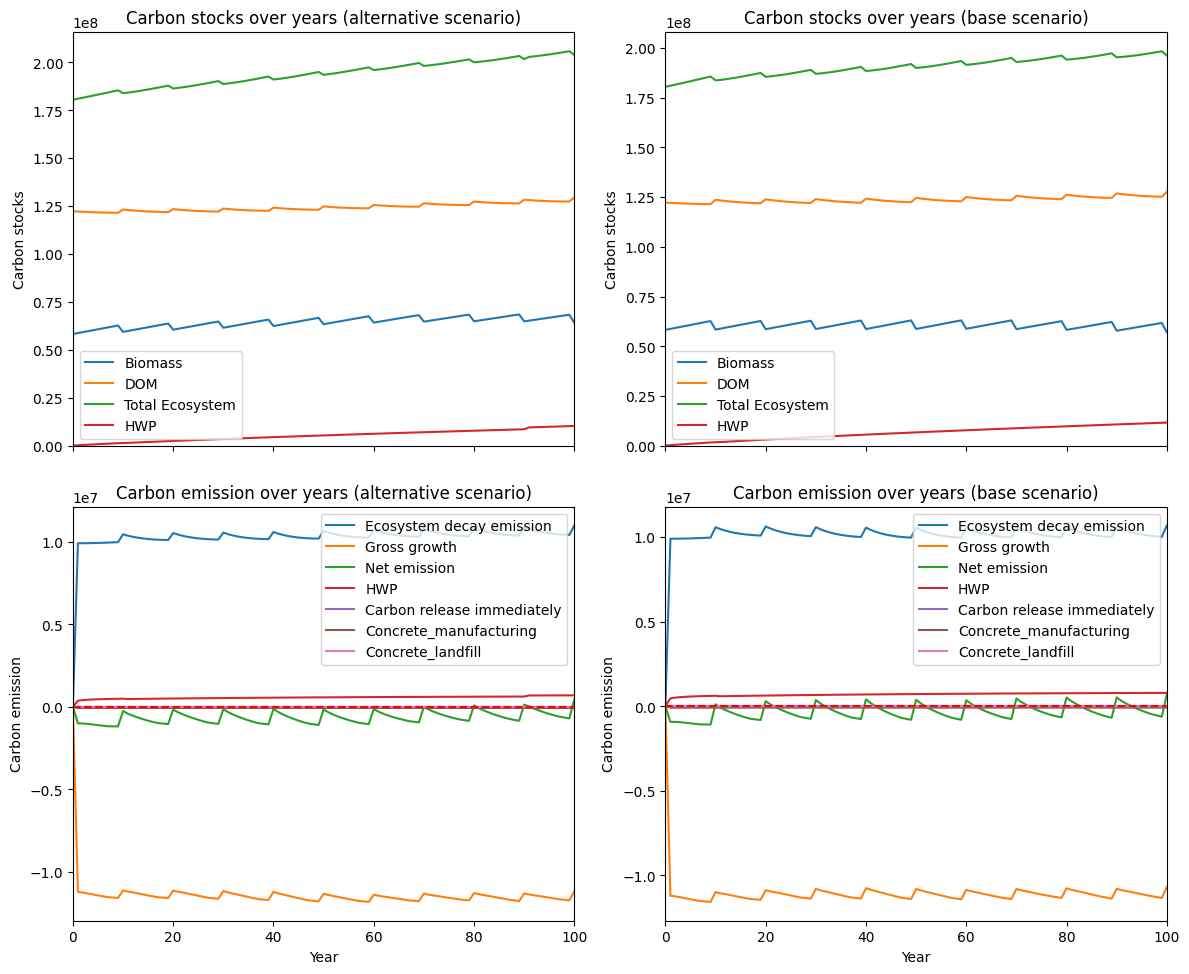

---------------------------------------------------------------------------------------
Net emission difference -30014647.29569113
Net emission base scenario -34255783.53595837
Net emission alternative scenario -64270430.8316495
dollar_per_ton is:  0.33317066502512555
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   3608.842571   3608.842571
DougFir  0.0    486.785486    486.785486
Bal      0.0  11816.707610  11816.707610
Spruce   0.0  27222.950493  27222.950493
Aspen    0.0   1298.068163   1298.068163
Pine     0.0   4294.243517   4294.243517

Overall, the old growth area has **increased** by 48727.60 hectares in the alternative scenario compared to the base scenario.


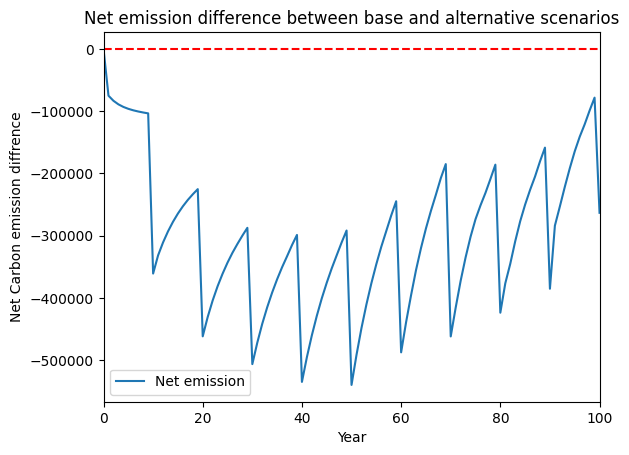

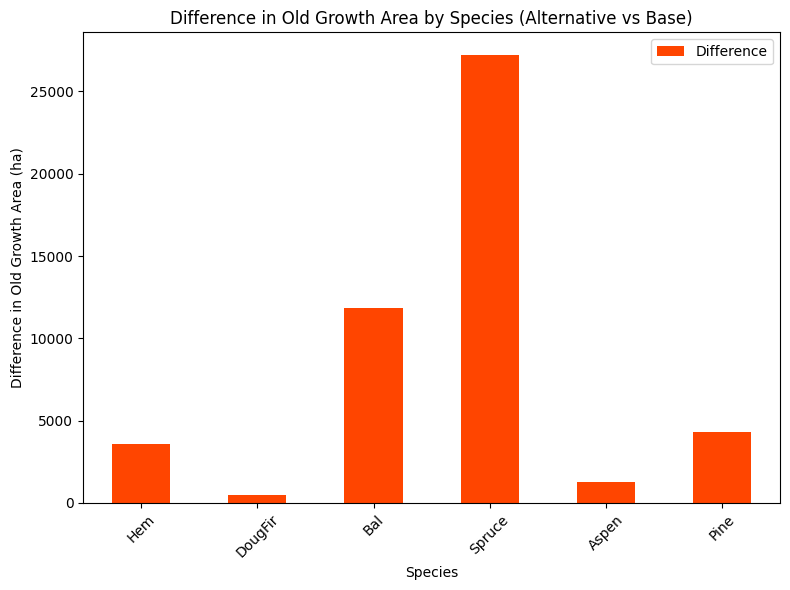

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


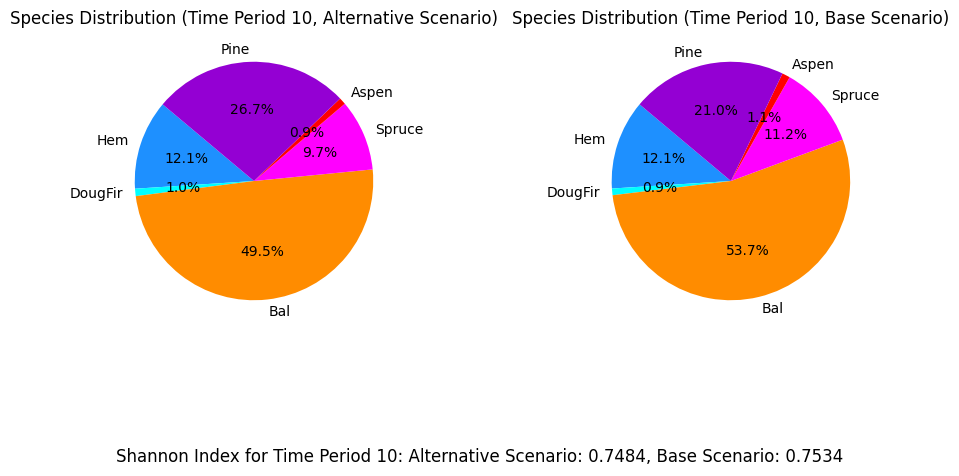

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_70%...
running the scenario for the Equity Silver mining site (70%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x3c3e6772
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.27s
Presolved: 8375 r

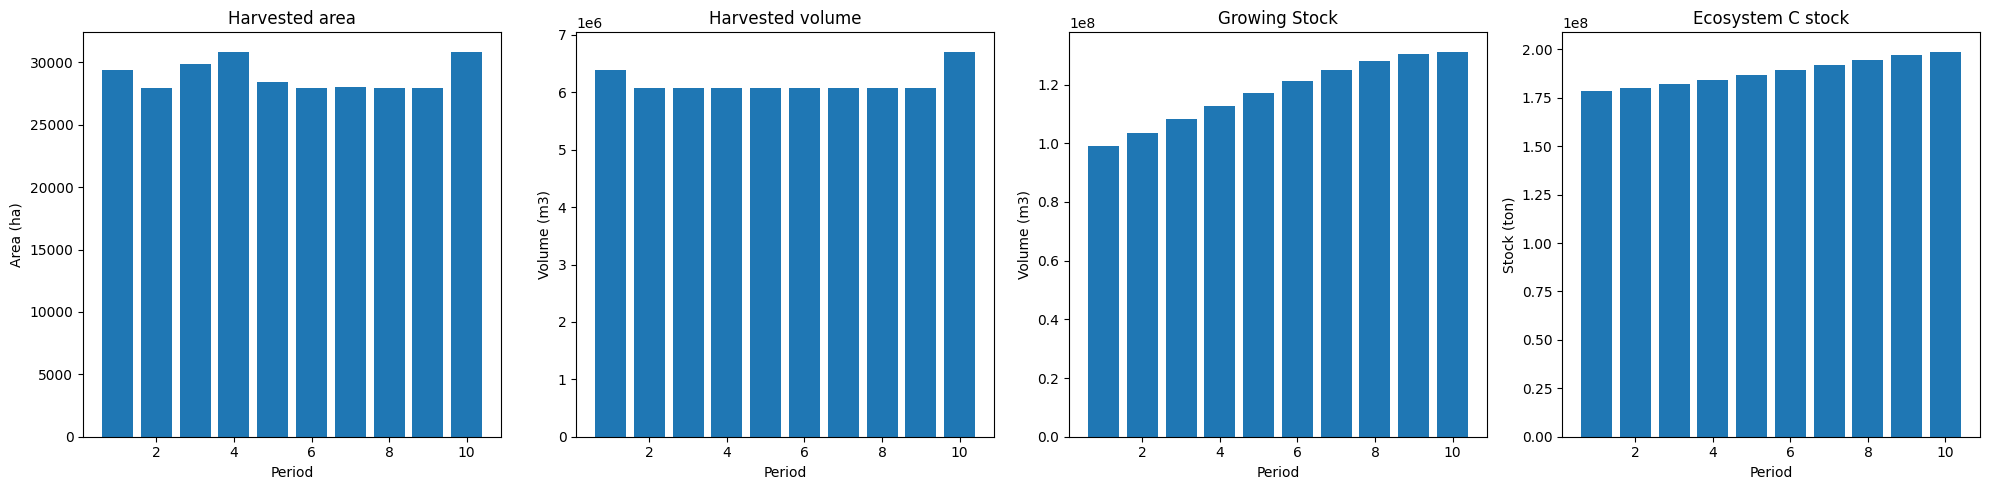

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_70%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  65185
The economic indicator (the provincial government revenues) is:  2222965
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


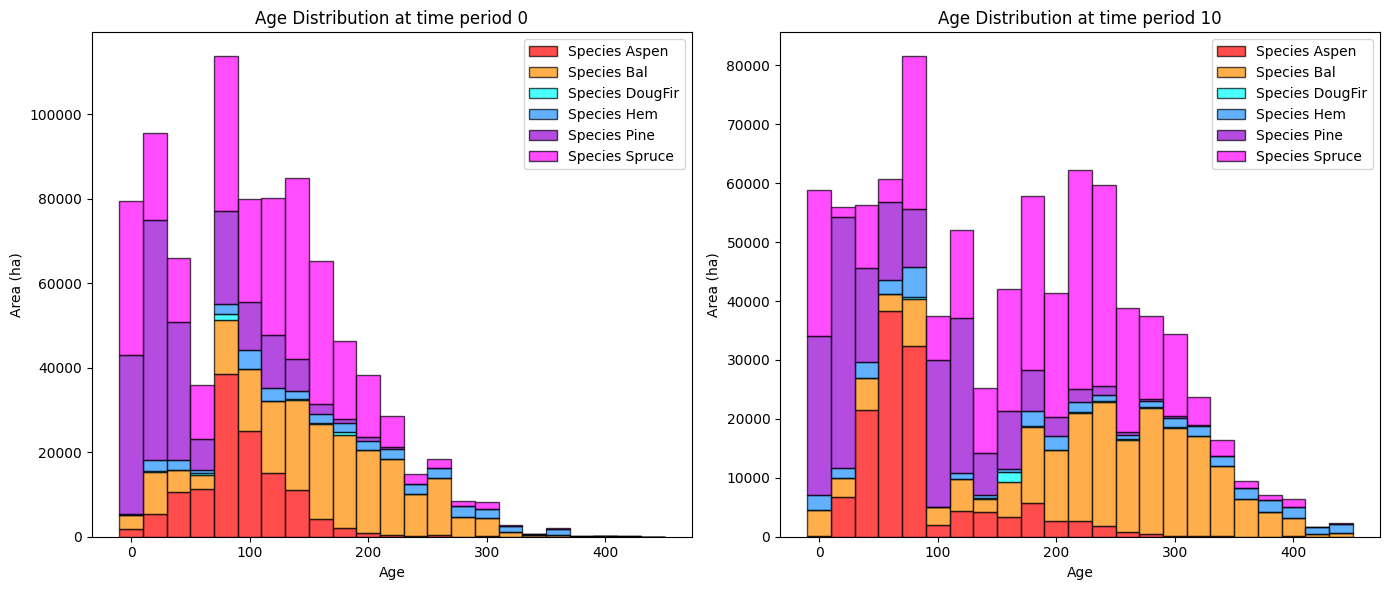

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_70%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   21713.672122    2561.544893
DougFir    947.047810    2285.441027    1338.393217
Bal      59315.970469  141497.229771   82181.259303
Spruce   36410.744598  177349.249205  140938.504608
Aspen    29632.731169   23751.955603   -5880.775566
Pine      7432.733686   24169.985263   16737.251577

Old growth has **increased** by 237876.18 hectares from time period 0 to time period 10.


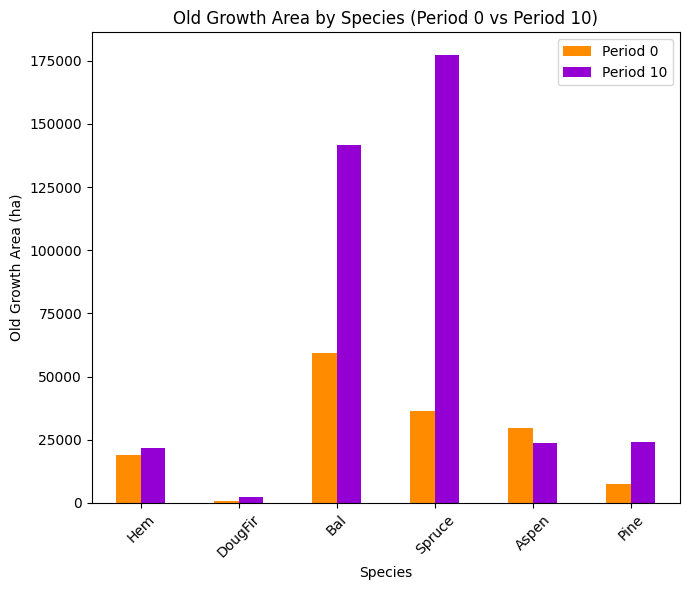

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_70%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7441

Diversity has **decreased** by 1.51% from time 0 to time 10.


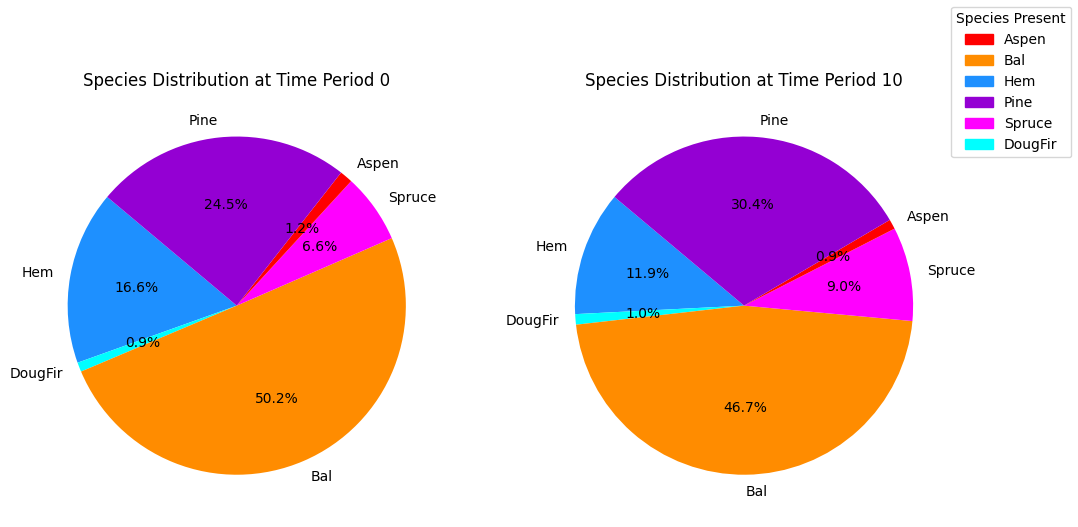

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_70%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.23s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

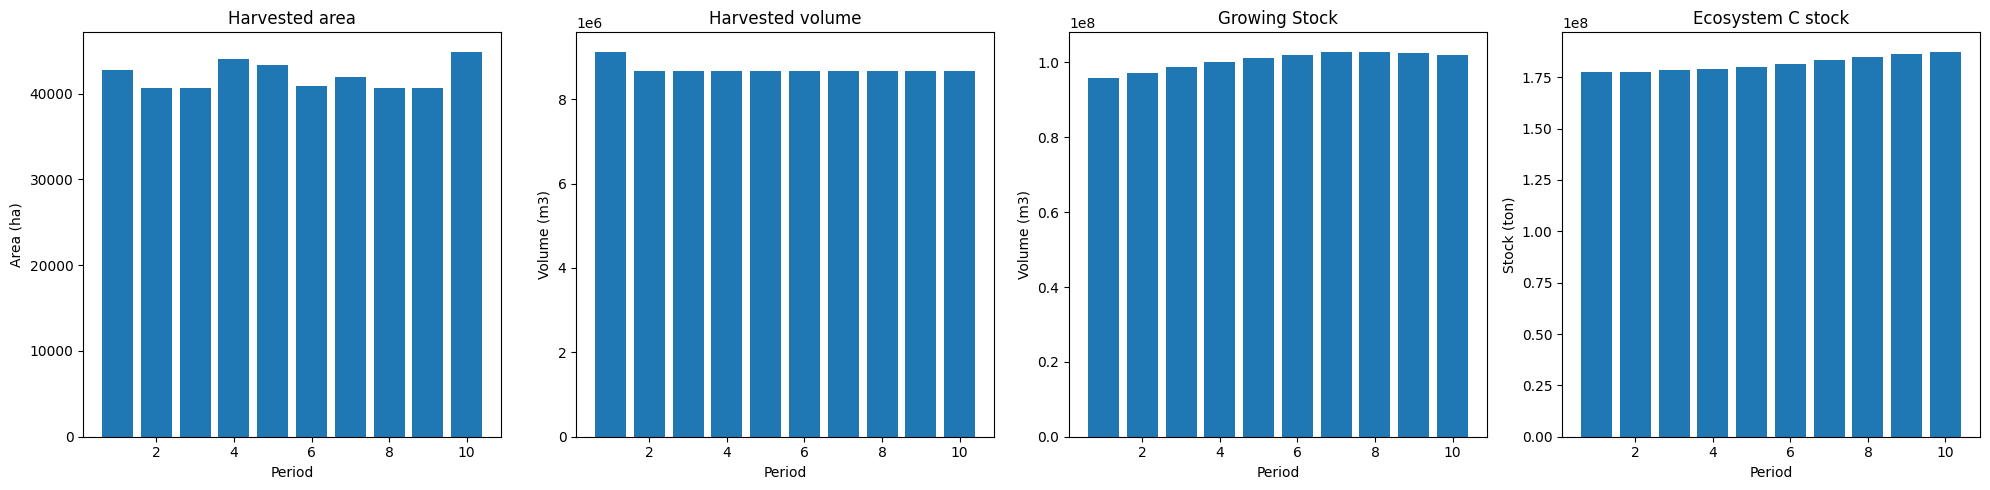

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


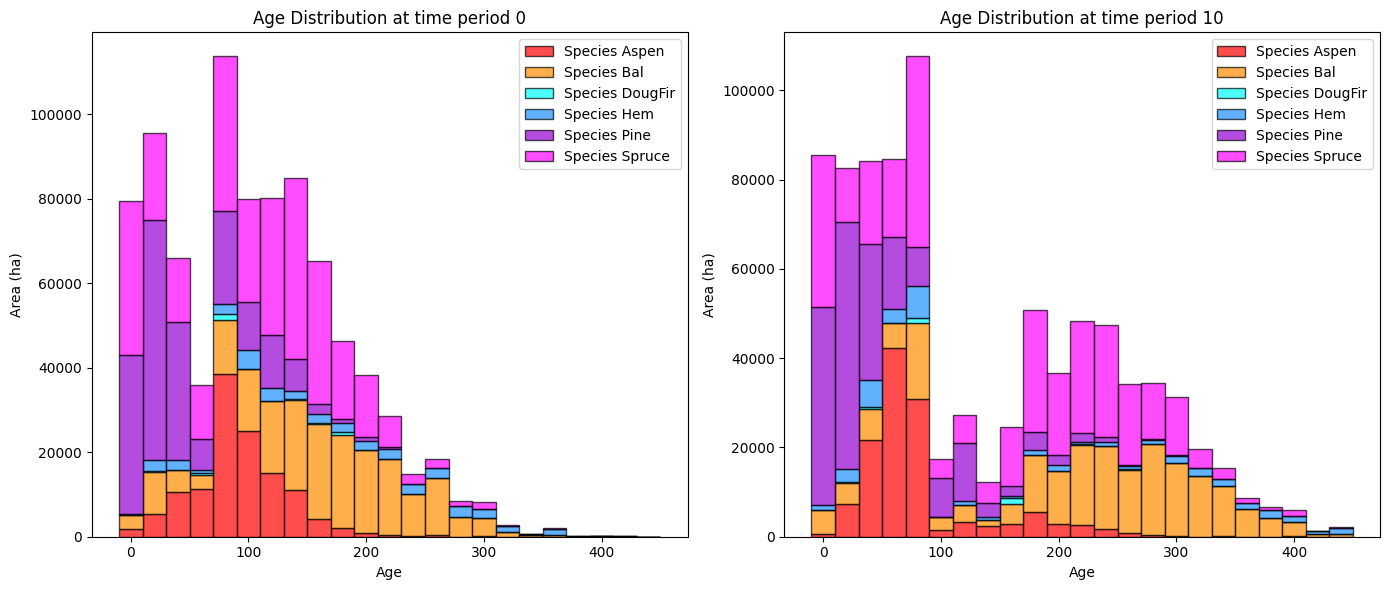

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


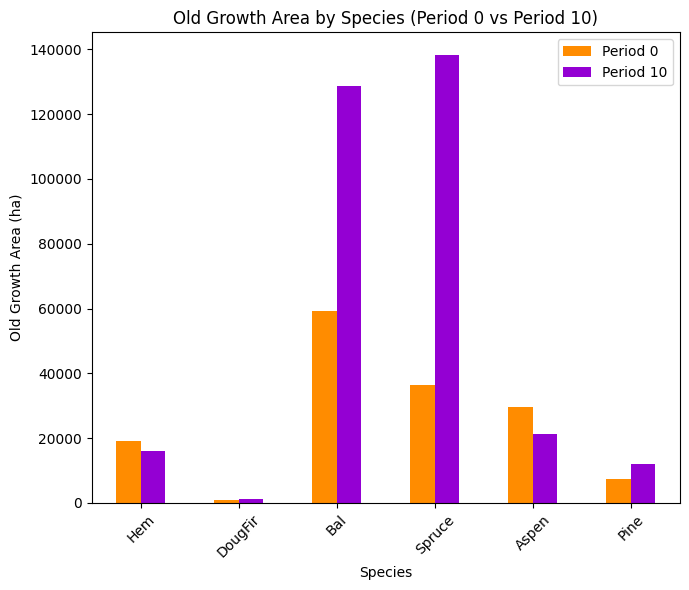

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


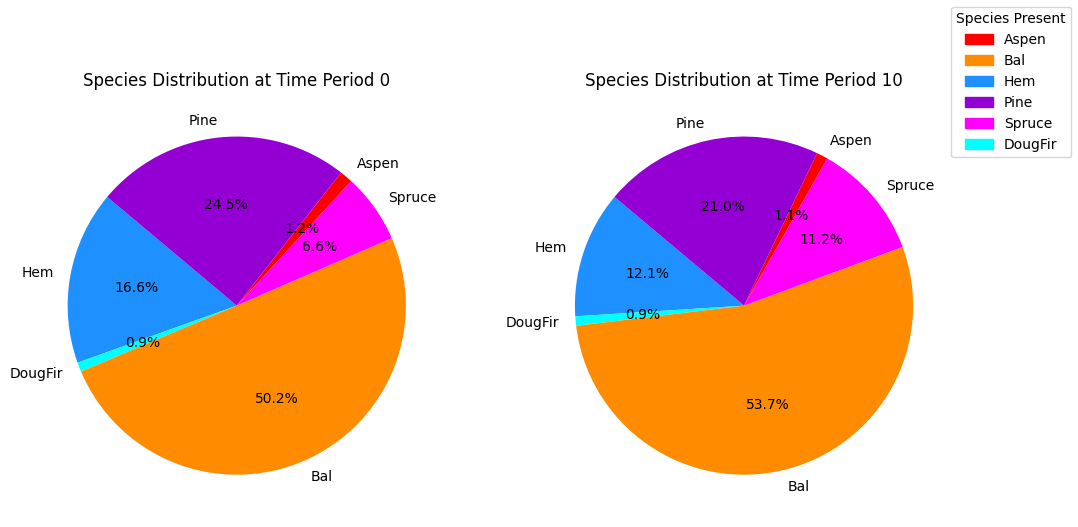

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


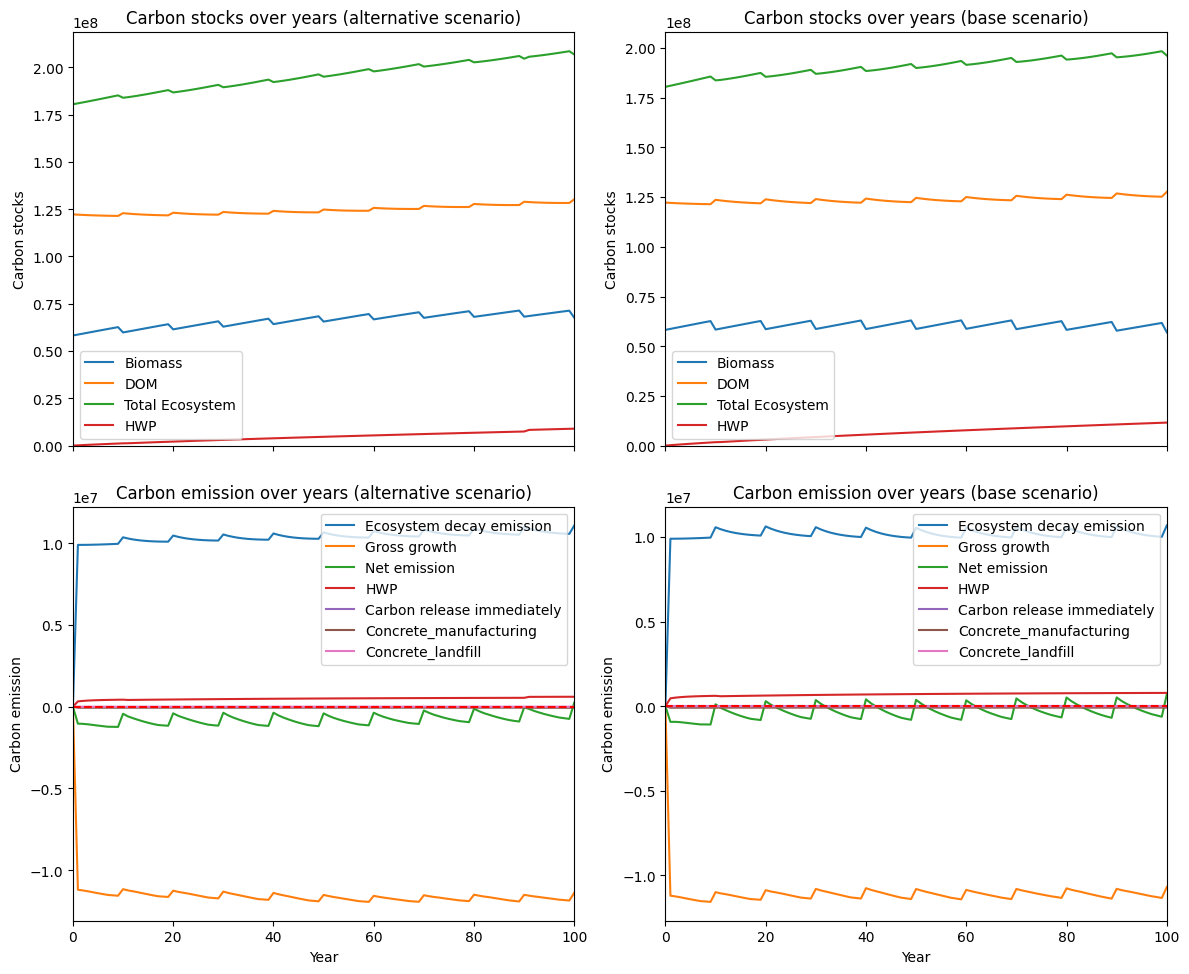

---------------------------------------------------------------------------------------
Net emission difference -44270245.36475596
Net emission base scenario -34255783.53595837
Net emission alternative scenario -78526028.90071434
dollar_per_ton is:  0.22588535296353052
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   5605.933403   5605.933403
DougFir  0.0    986.138384    986.138384
Bal      0.0  12691.231985  12691.231985
Spruce   0.0  39000.860919  39000.860919
Aspen    0.0   2547.696280   2547.696280
Pine     0.0  12266.950226  12266.950226

Overall, the old growth area has **increased** by 73098.81 hectares in the alternative scenario compared to the base scenario.


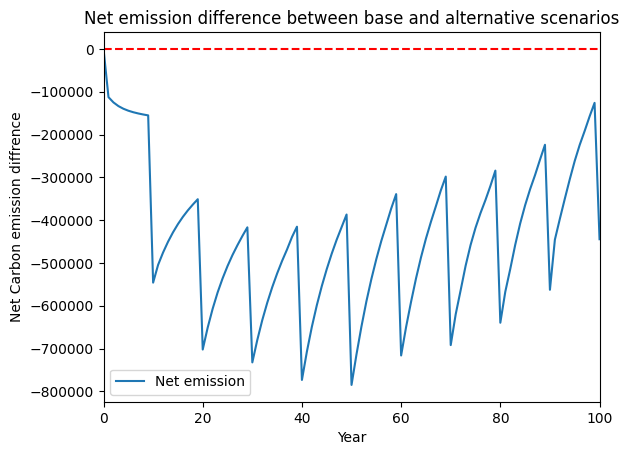

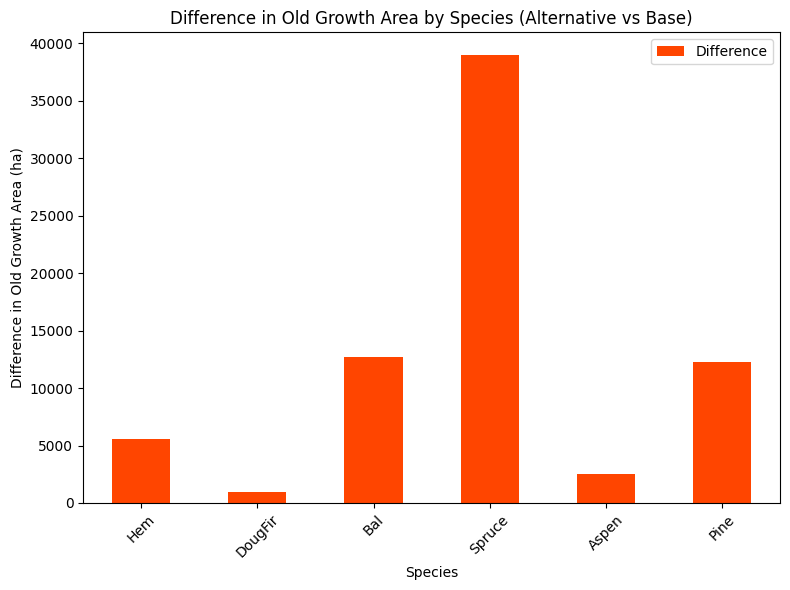

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


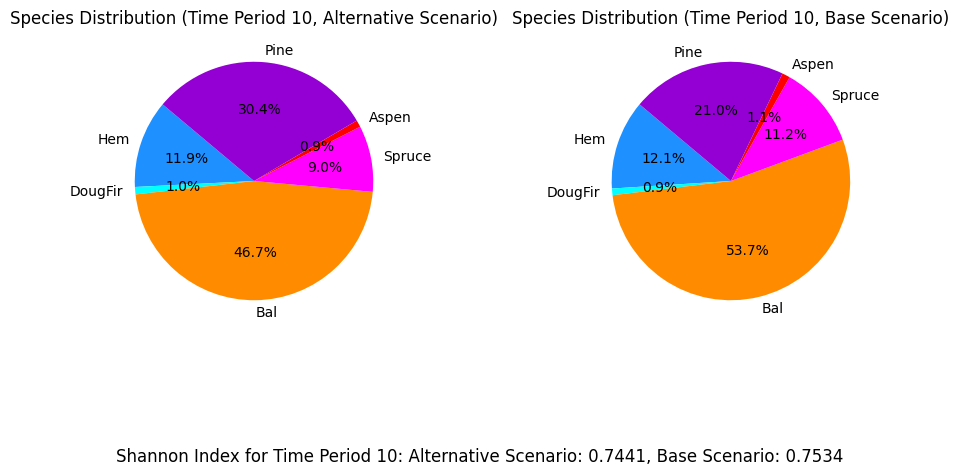

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_60%...
running the scenario for the Equity Silver mining site (60%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x6ec53a59
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.22s
Presolved: 8375 r

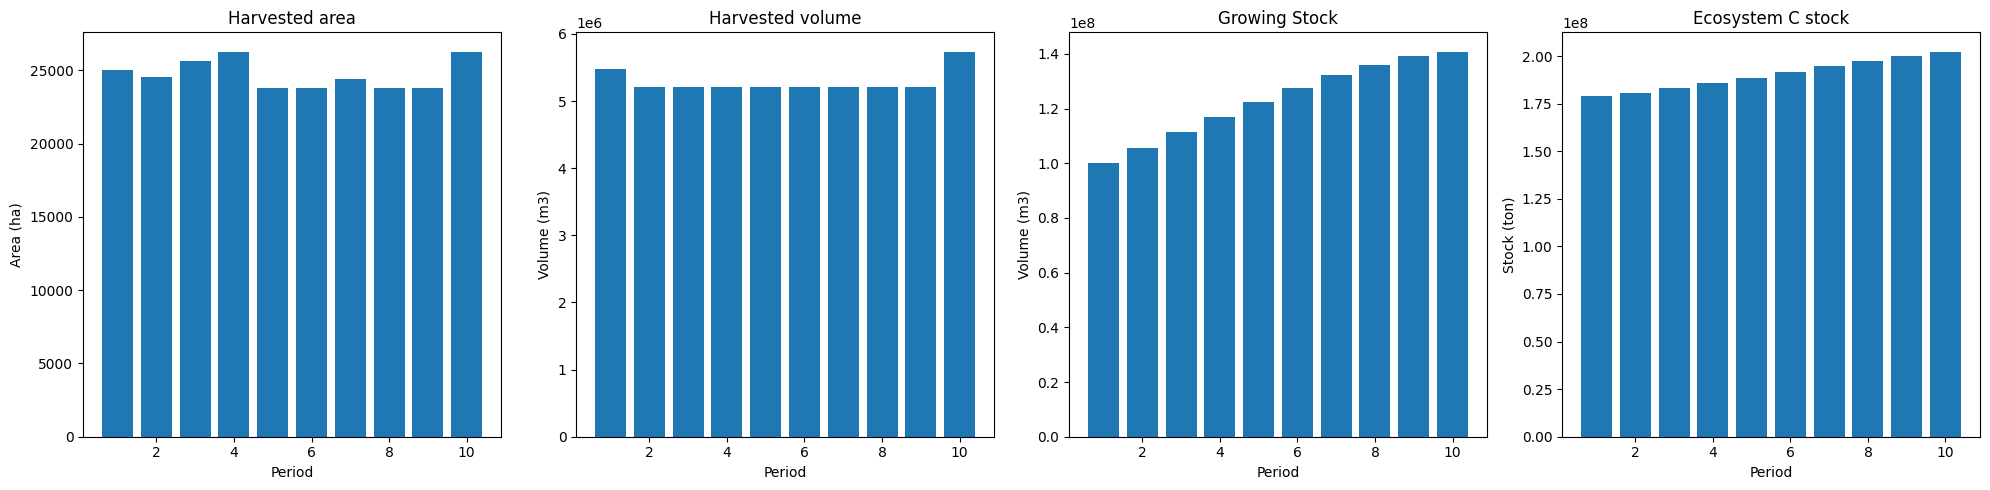

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_60%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  55858
The economic indicator (the provincial government revenues) is:  1904896
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


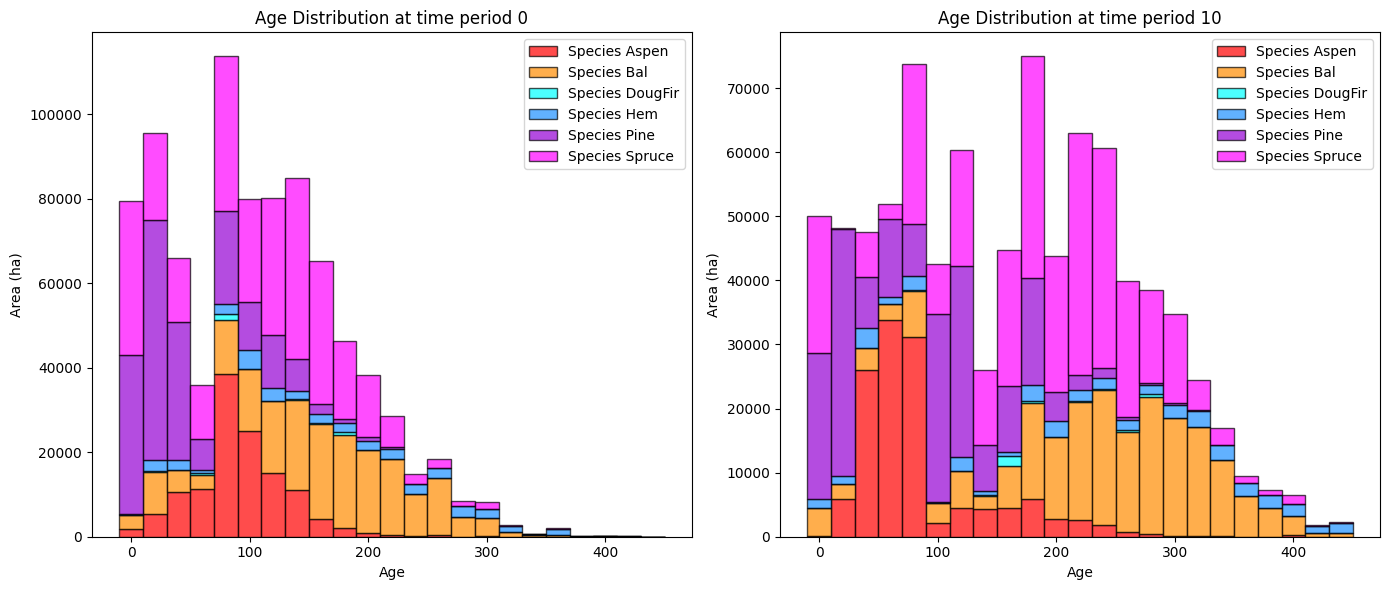

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_60%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   25817.705824    6665.578596
DougFir    947.047810    2607.841586    1660.793776
Bal      59315.970469  144593.864625   85277.894156
Spruce   36410.744598  183232.630258  146821.885660
Aspen    29632.731169   25417.280513   -4215.450656
Pine      7432.733686   35834.769316   28402.035630

Old growth has **increased** by 264612.74 hectares from time period 0 to time period 10.


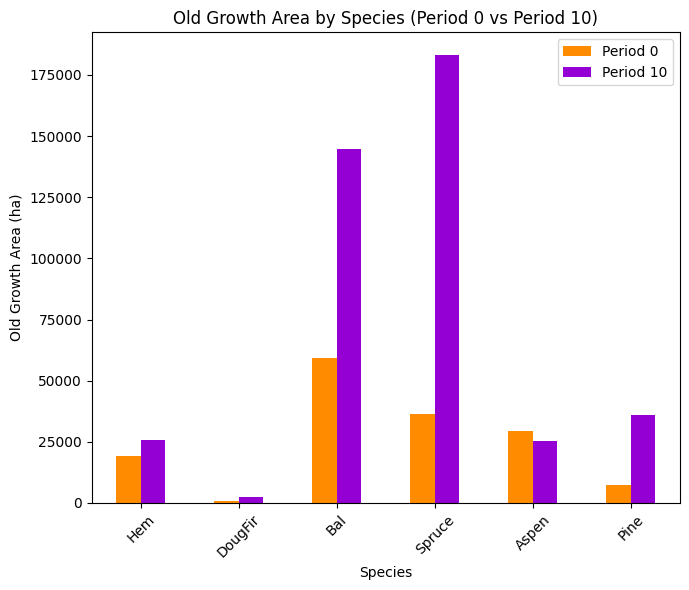

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_60%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7440

Diversity has **decreased** by 1.52% from time 0 to time 10.


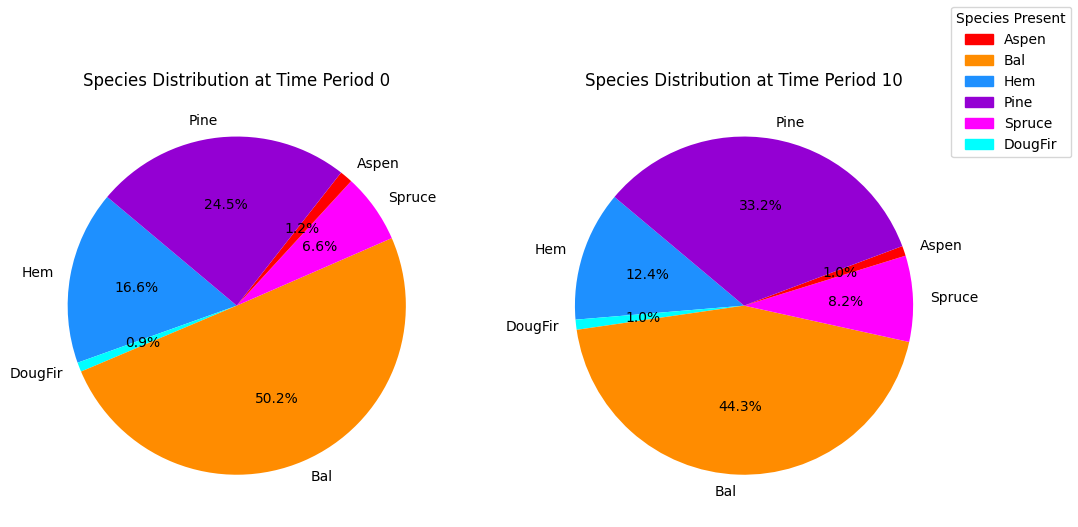

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_60%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.23s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

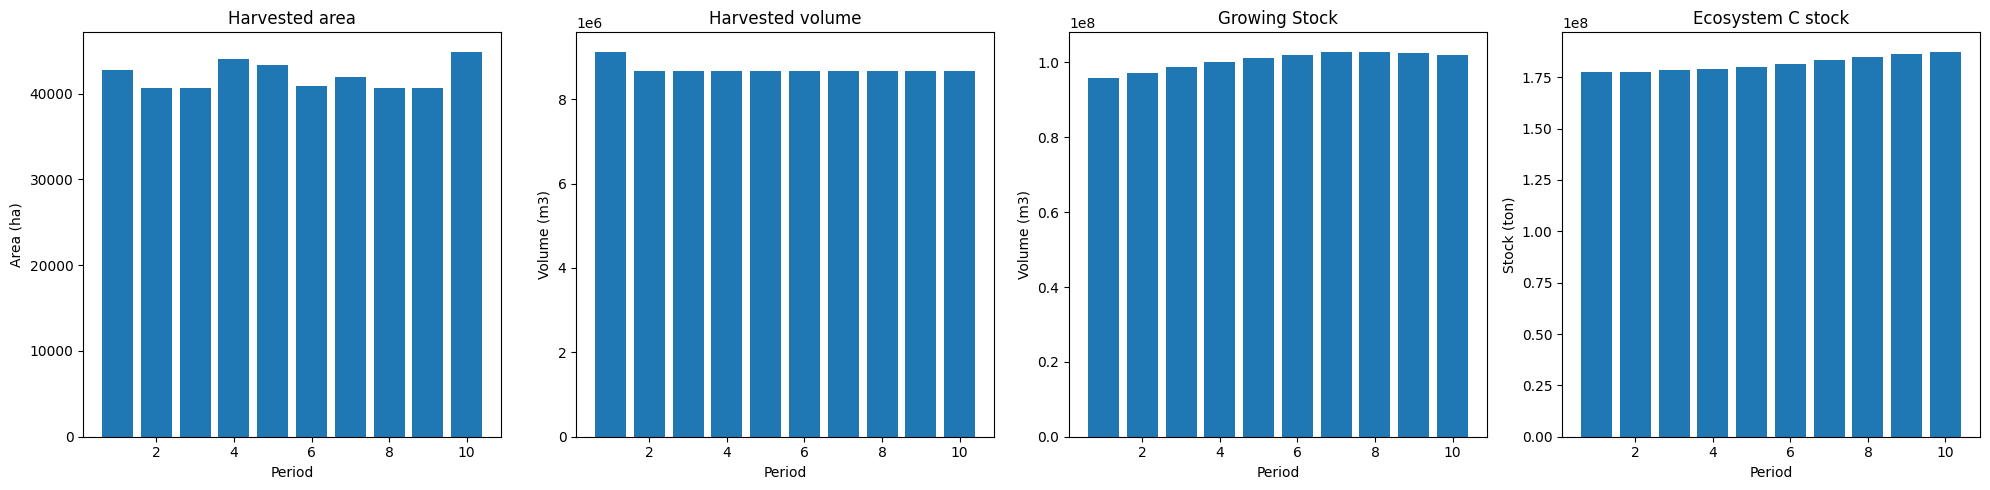

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


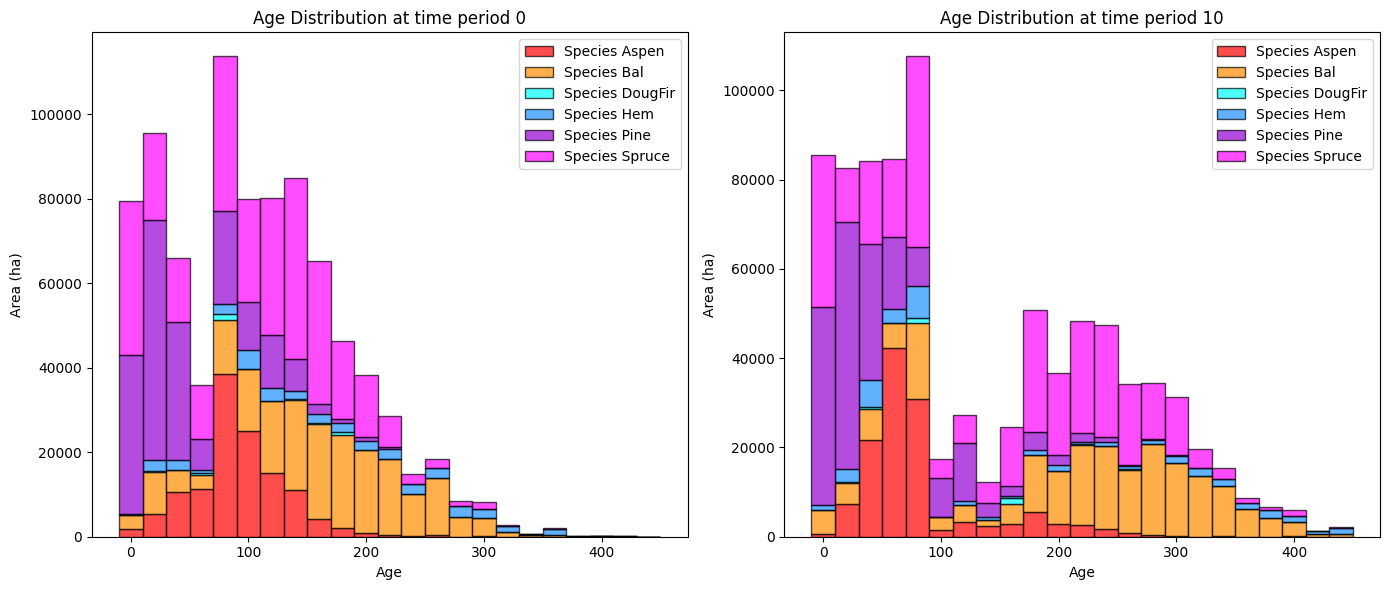

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


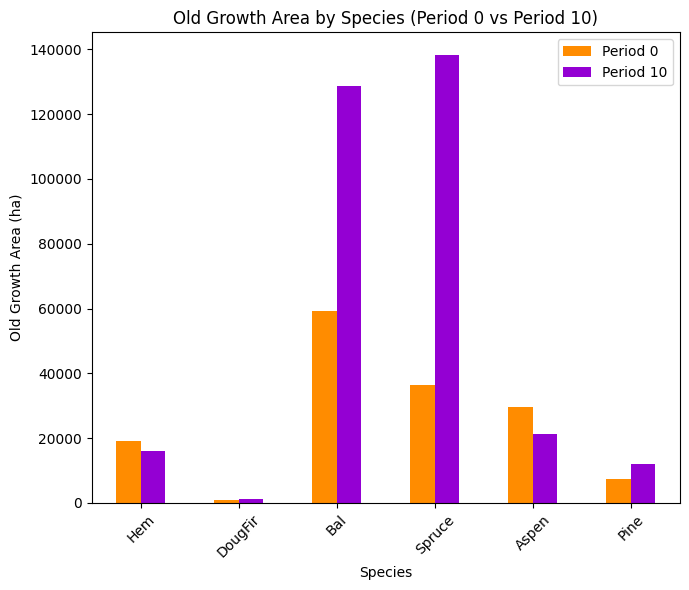

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


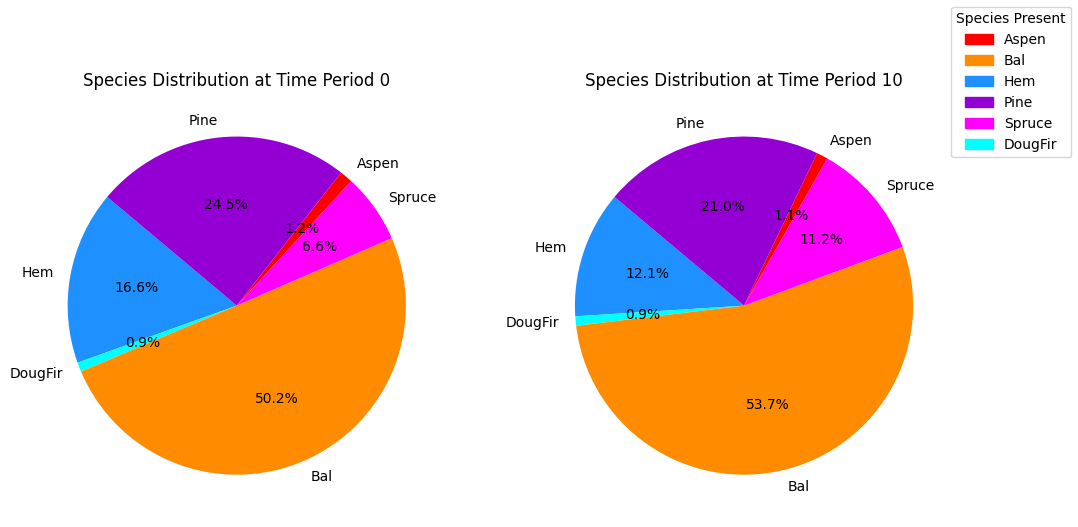

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


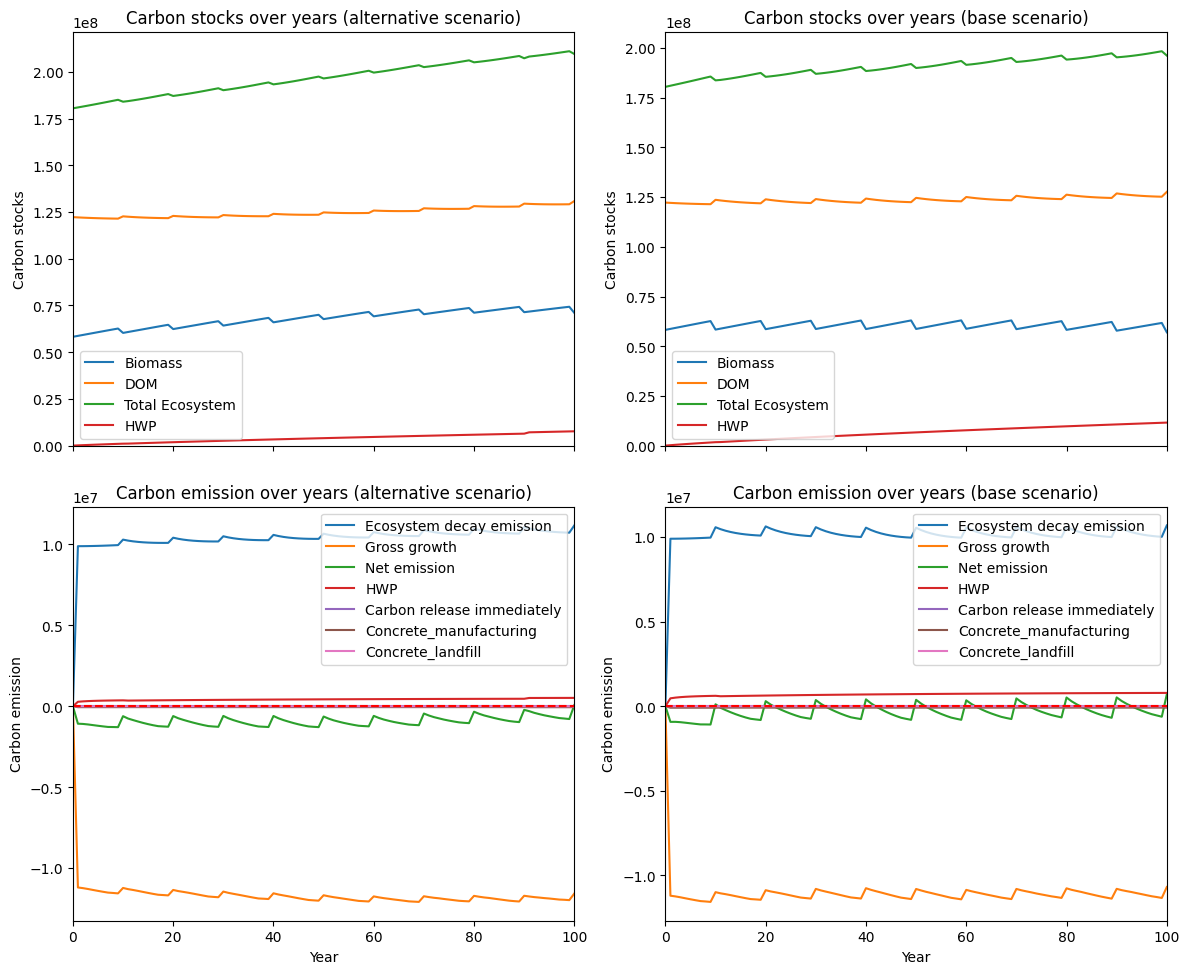

---------------------------------------------------------------------------------------
Net emission difference -57724944.486270286
Net emission base scenario -34255783.53595837
Net emission alternative scenario -91980728.02222866
dollar_per_ton is:  0.17323533333805927
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0   9709.967106   9709.967106
DougFir  0.0   1308.538944   1308.538944
Bal      0.0  15787.866839  15787.866839
Spruce   0.0  44884.241971  44884.241971
Aspen    0.0   4213.021190   4213.021190
Pine     0.0  23931.734279  23931.734279

Overall, the old growth area has **increased** by 99835.37 hectares in the alternative scenario compared to the base scenario.


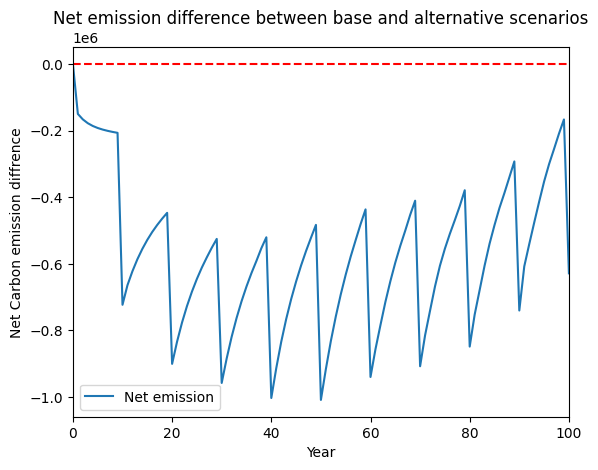

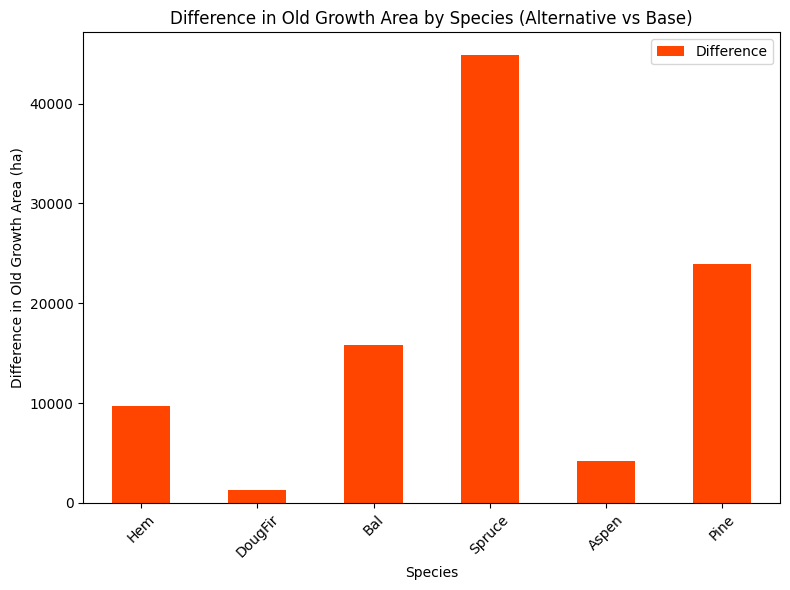

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


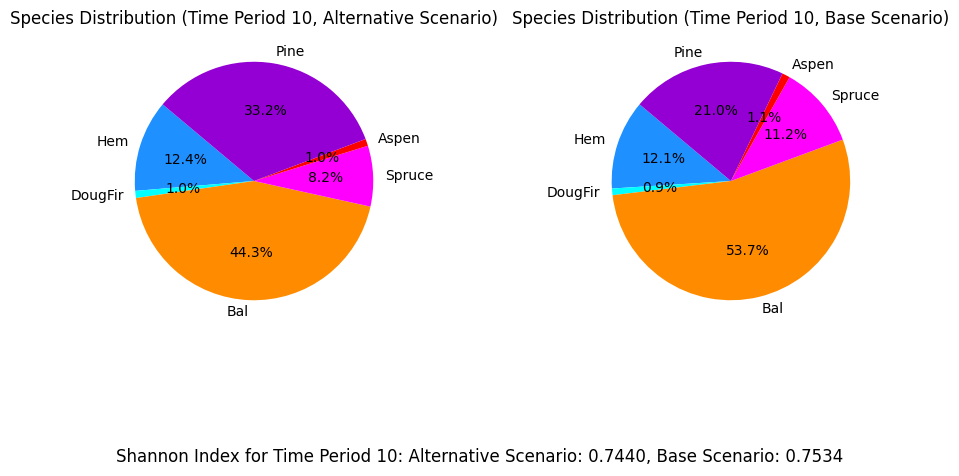

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_50%...
running the scenario for the Equity Silver mining site (50%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x804a05d8
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.23s
Presolved: 8375 r

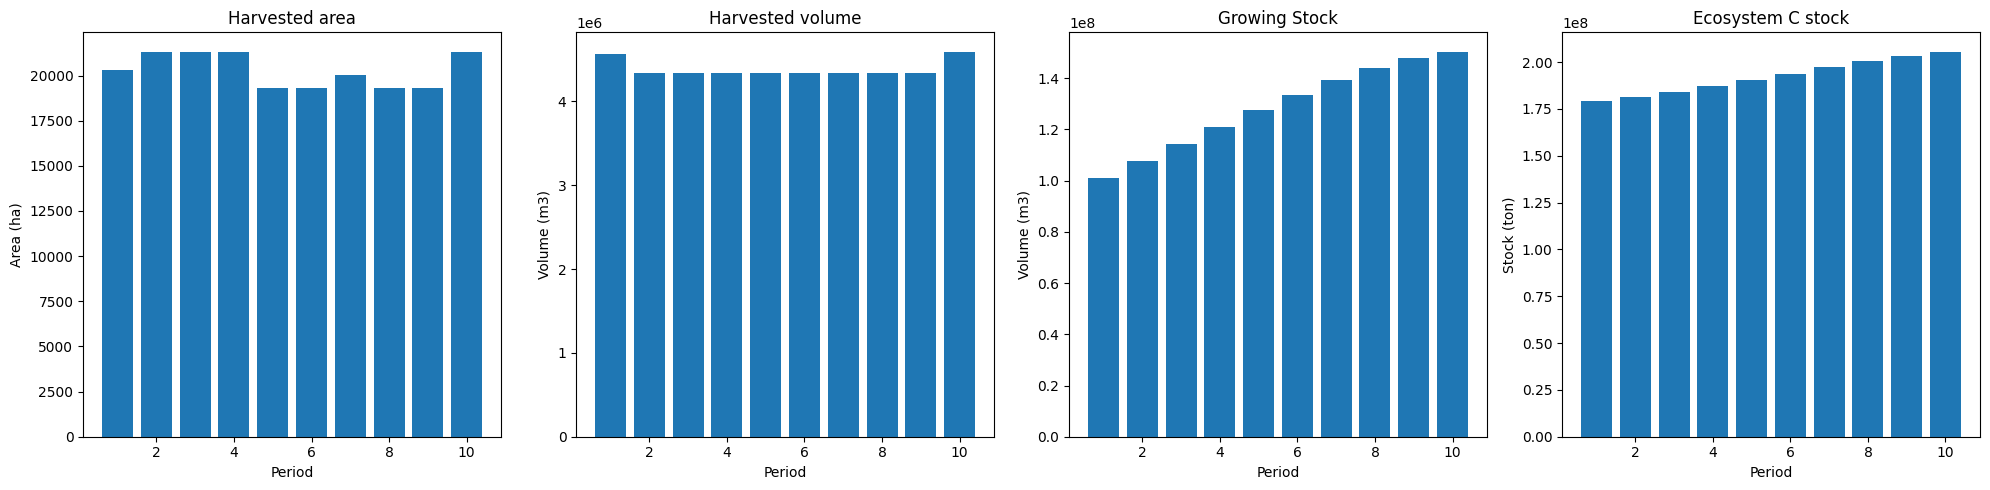

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_50%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  46351
The economic indicator (the provincial government revenues) is:  1580700
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


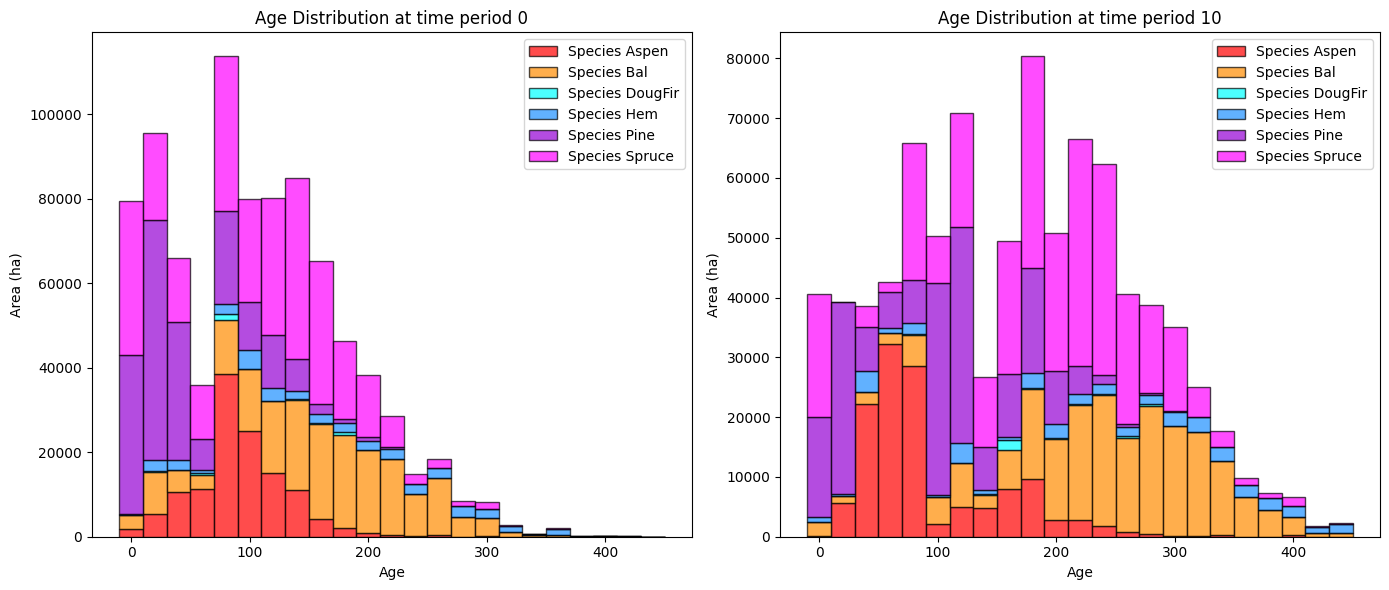

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_50%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   26598.571455    7446.444226
DougFir    947.047810    2619.825588    1672.777778
Bal      59315.970469  149282.771055   89966.800587
Spruce   36410.744598  188878.449879  152467.705281
Aspen    29632.731169   33454.276981    3821.545812
Pine      7432.733686   44727.695886   37294.962200

Old growth has **increased** by 292670.24 hectares from time period 0 to time period 10.


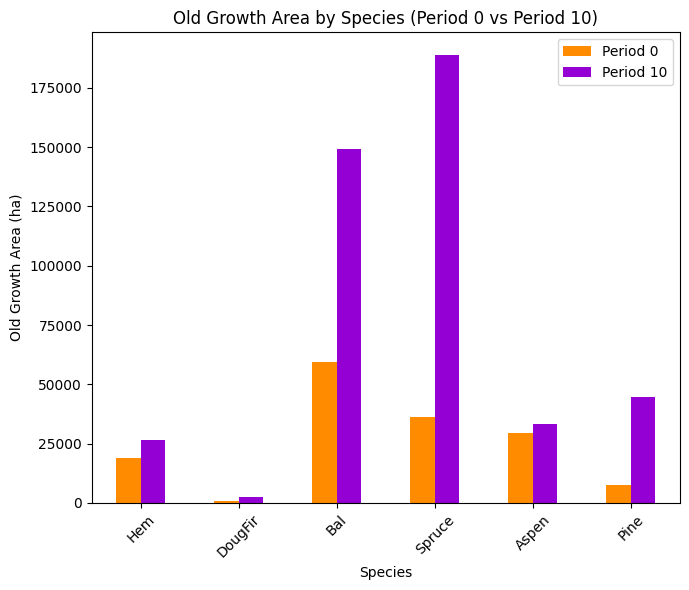

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_50%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7438

Diversity has **decreased** by 1.54% from time 0 to time 10.


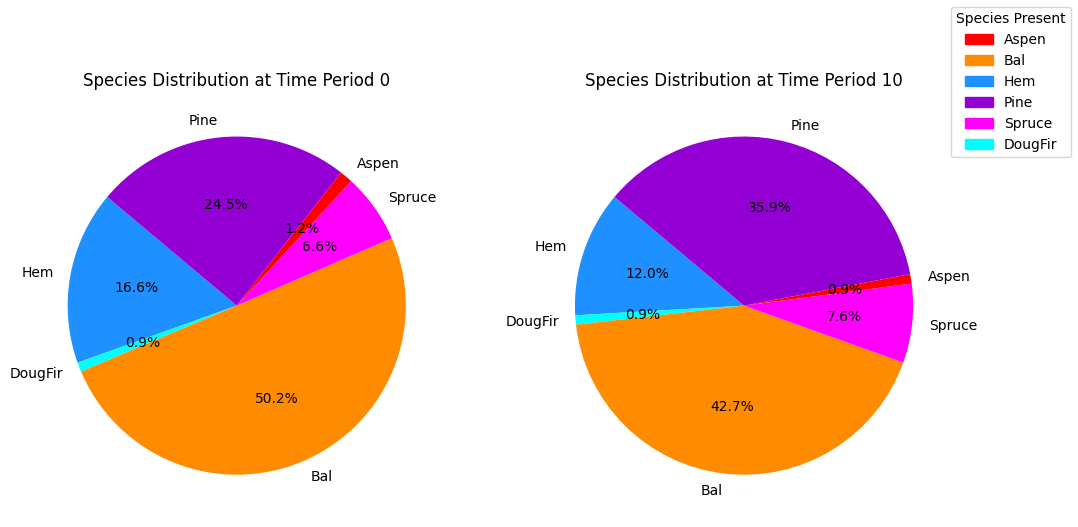

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_50%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.29s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

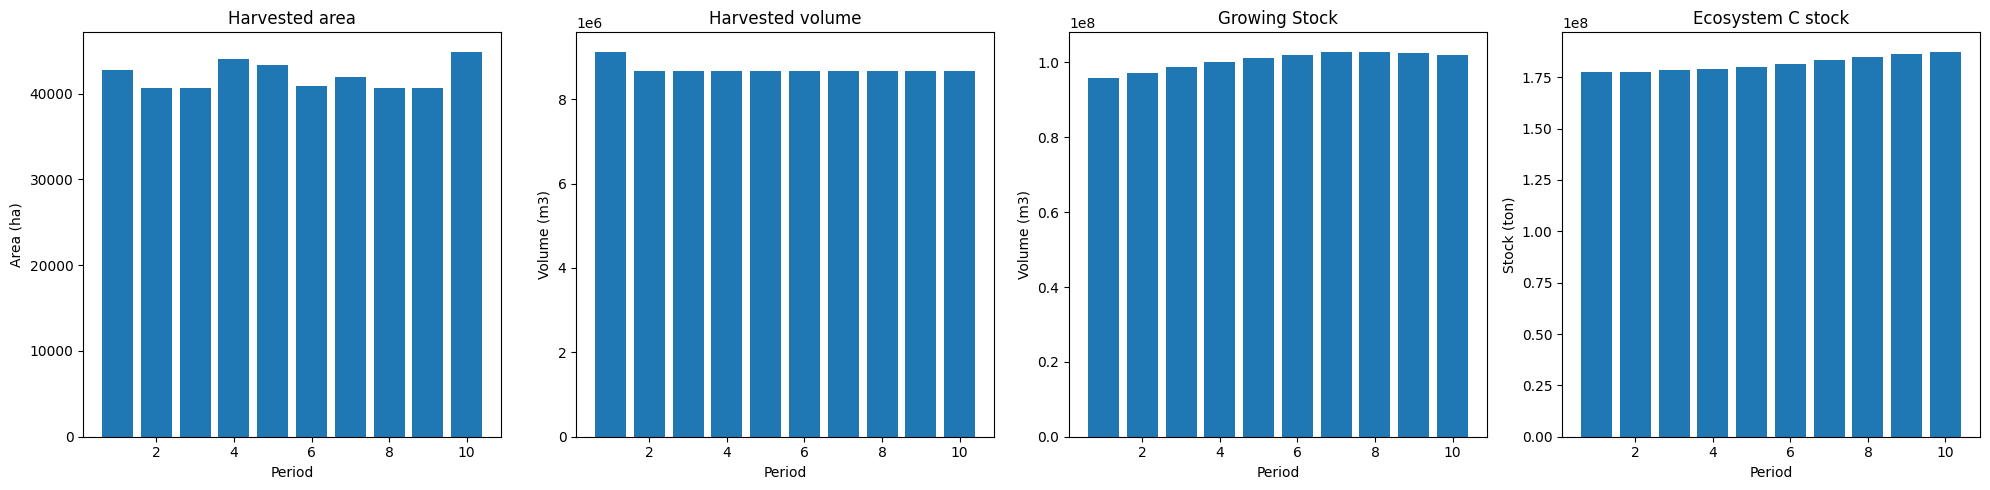

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


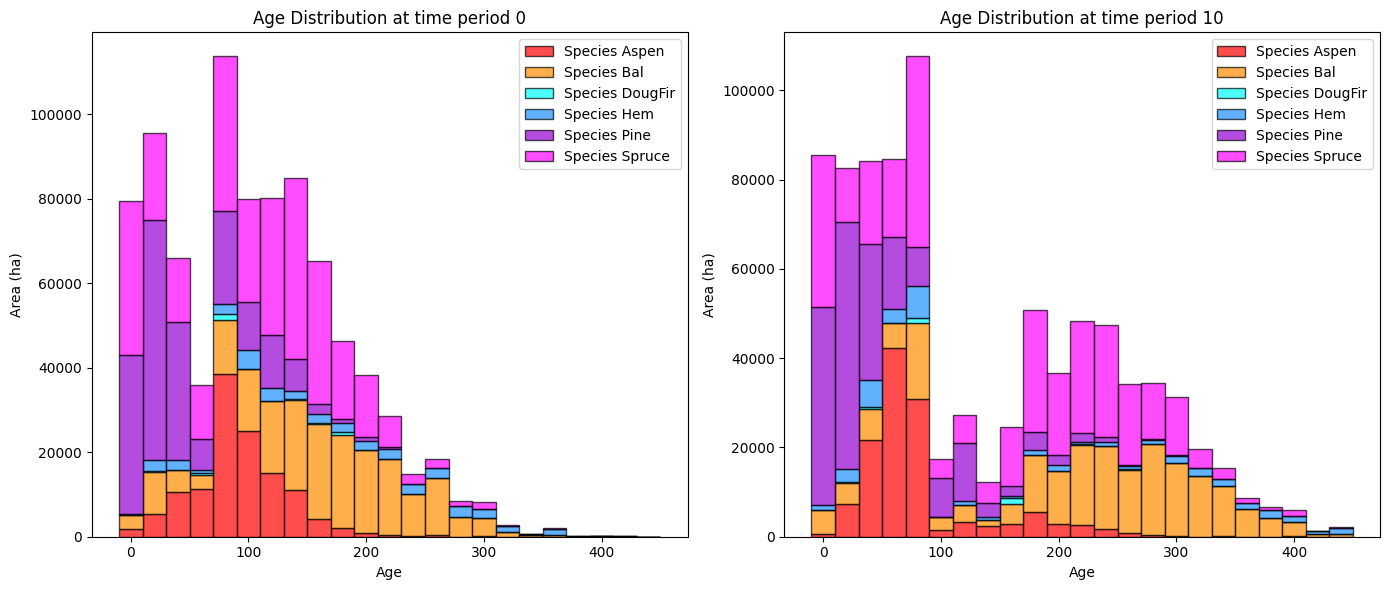

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


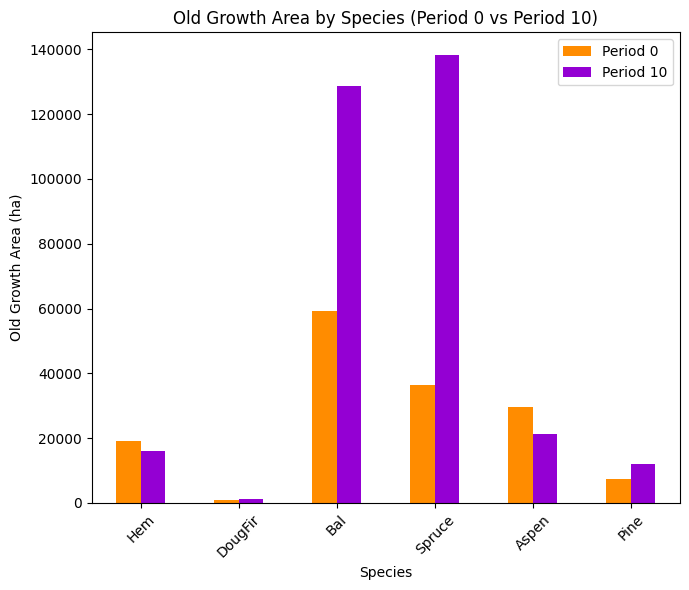

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


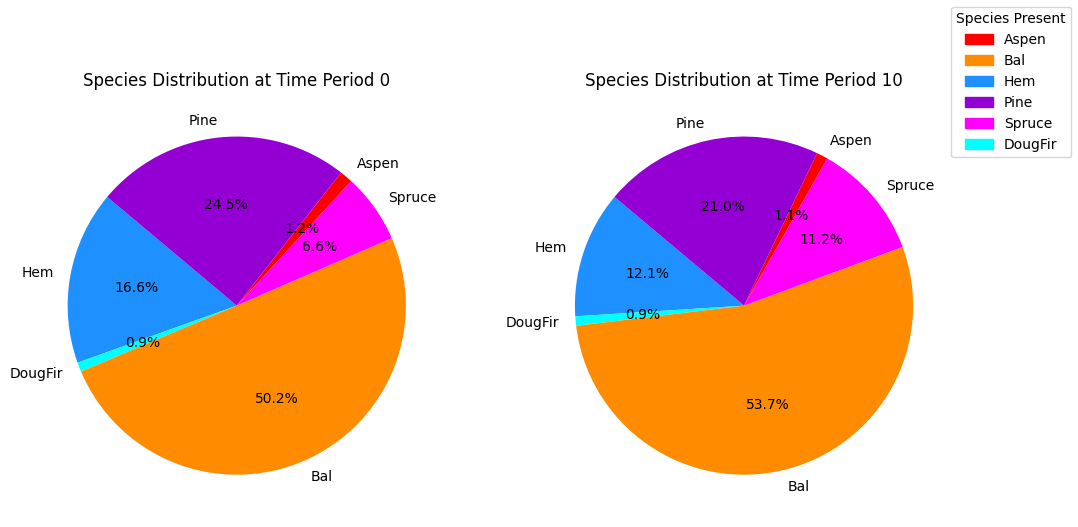

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


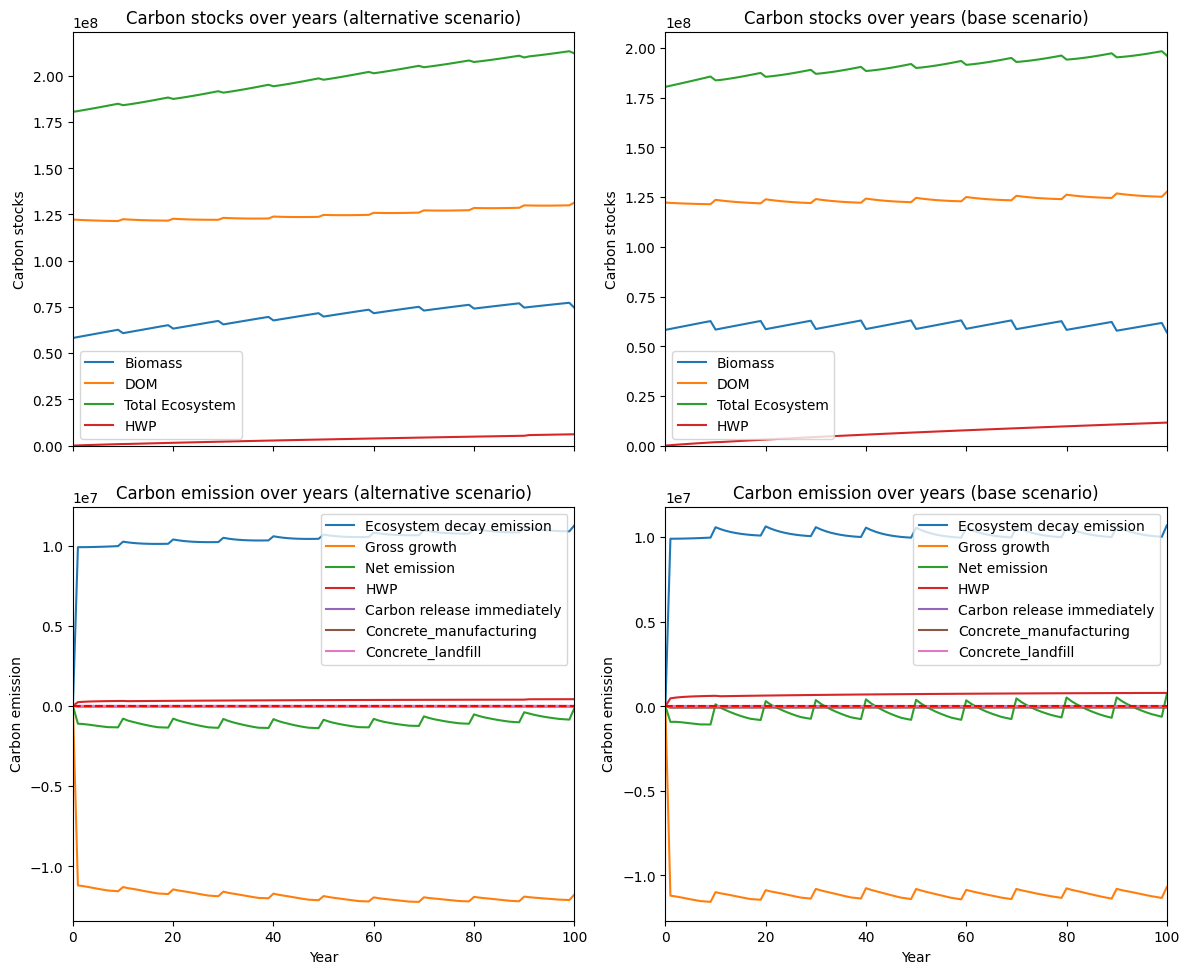

---------------------------------------------------------------------------------------
Net emission difference -70728504.64478655
Net emission base scenario -34255783.53595837
Net emission alternative scenario -104984288.18074495
dollar_per_ton is:  0.14138571217109858
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  10490.832736  10490.832736
DougFir  0.0   1320.522945   1320.522945
Bal      0.0  20476.773269  20476.773269
Spruce   0.0  50530.061592  50530.061592
Aspen    0.0  12250.017659  12250.017659
Pine     0.0  32824.660850  32824.660850

Overall, the old growth area has **increased** by 127892.87 hectares in the alternative scenario compared to the base scenario.


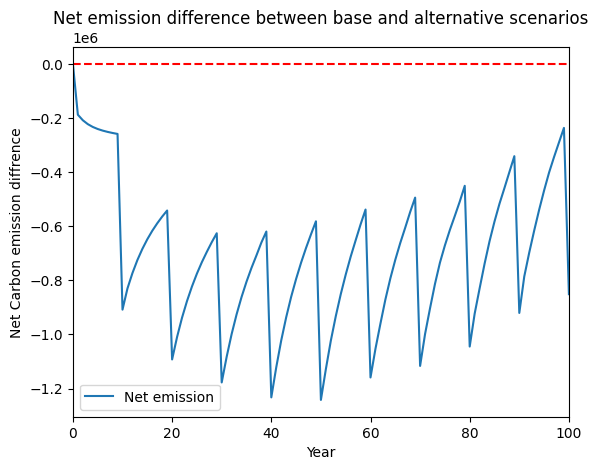

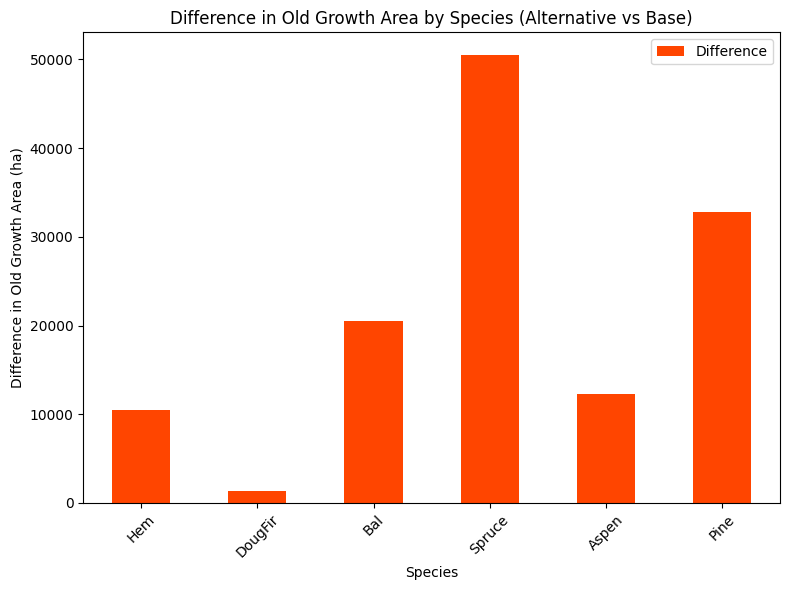

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


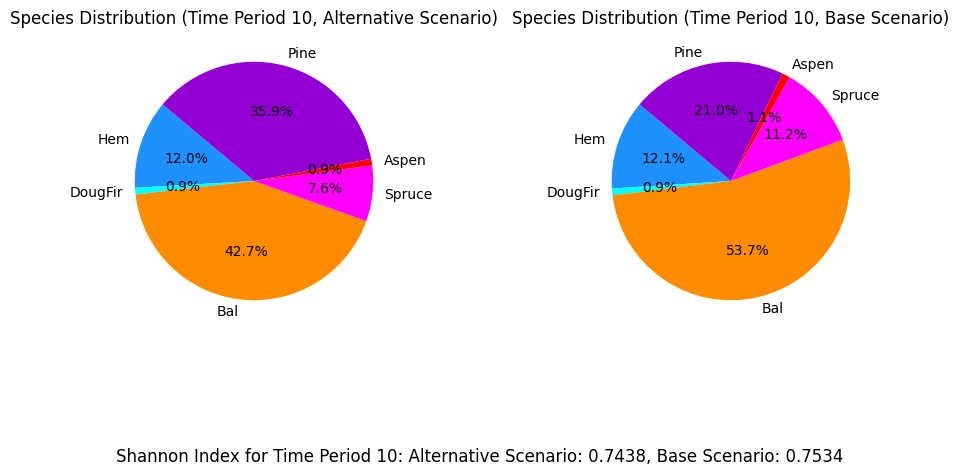

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_40%...
running the scenario for the Equity Silver mining site (40%_AAC),


In [ ]:
Start = time.time()
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

Running for equitysilver_max_st_eqtslvr_AAC_40%...
running the scenario for the Equity Silver mining site (40%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x73b1f59d
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.22s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.583e+05
 Factor NZ  :

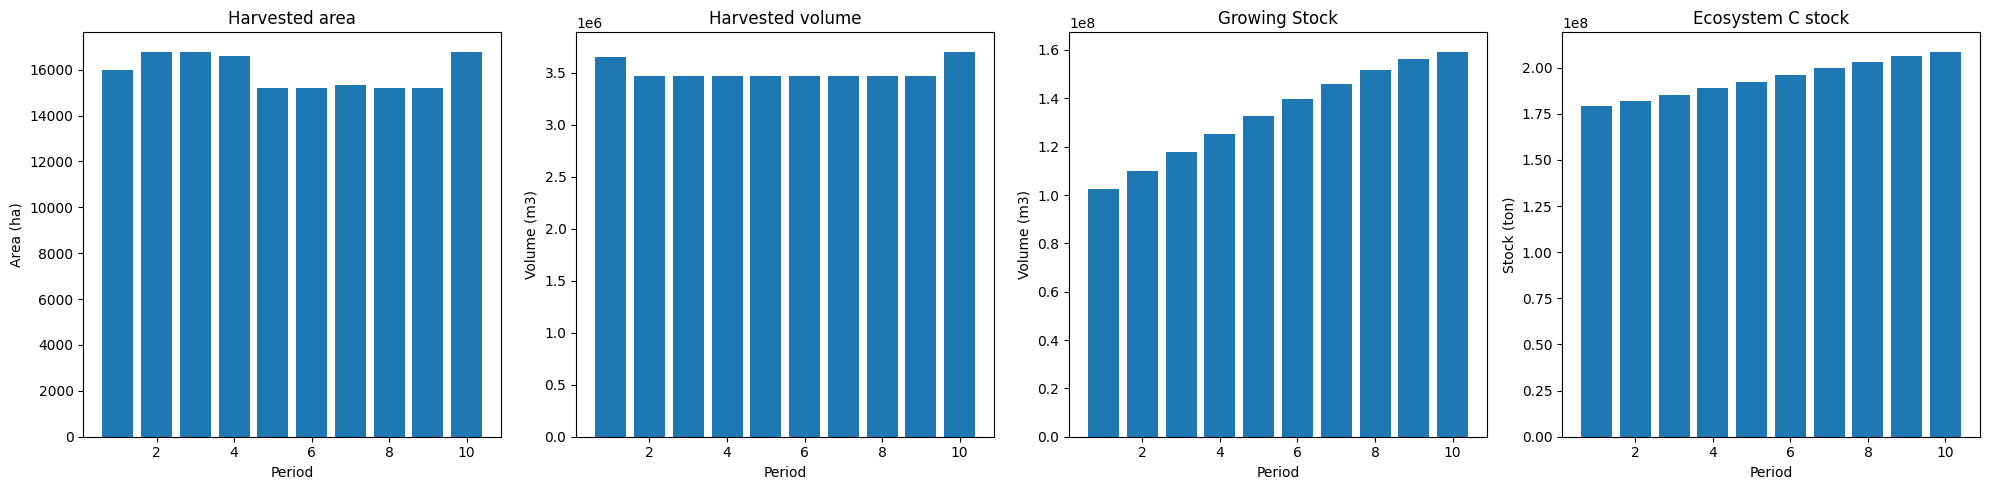

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_40%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  37113
The economic indicator (the provincial government revenues) is:  1265647
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


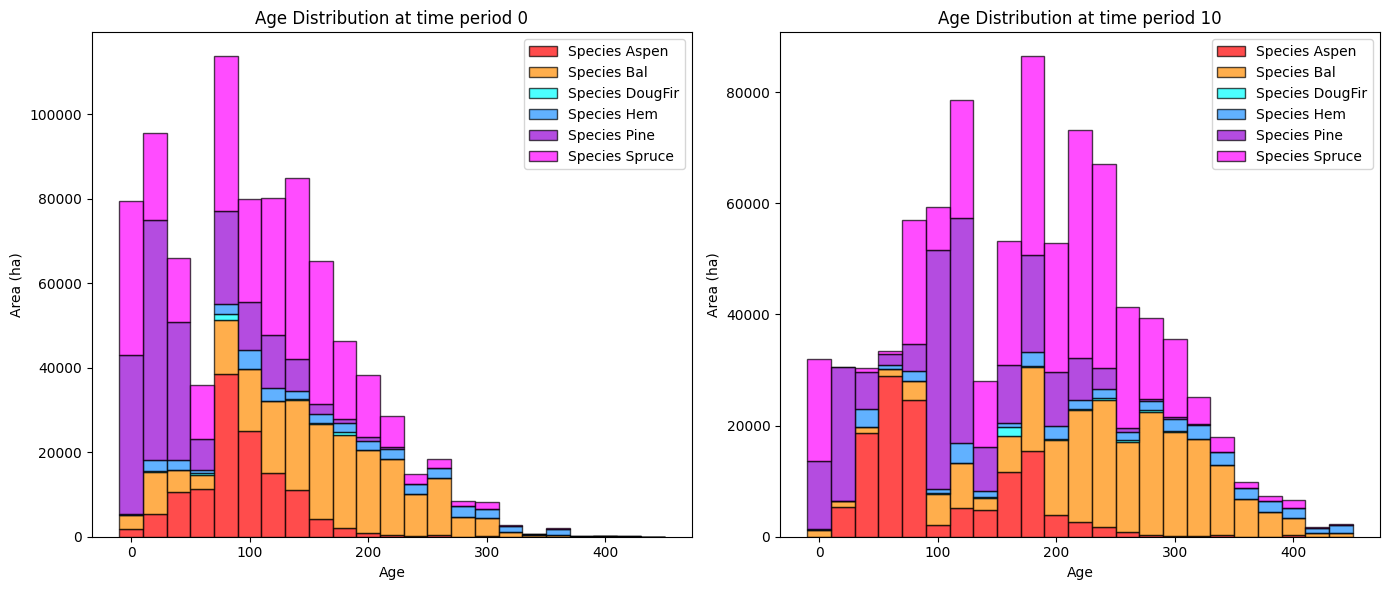

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_40%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   26902.150014    7750.022785
DougFir    947.047810    2749.298212    1802.250402
Bal      59315.970469  153019.700724   93703.730255
Spruce   36410.744598  193700.653514  157289.908916
Aspen    29632.731169   44216.383783   14583.652614
Pine      7432.733686   53014.922994   45582.189308

Old growth has **increased** by 320711.75 hectares from time period 0 to time period 10.


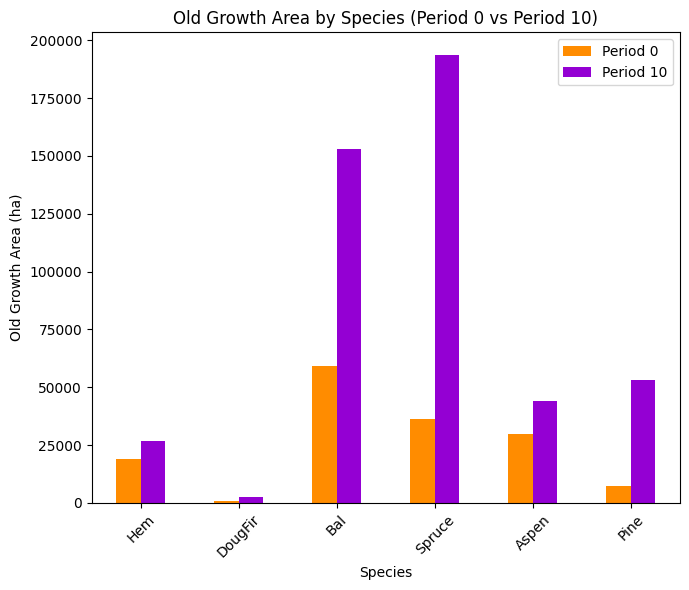

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_40%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7428

Diversity has **decreased** by 1.64% from time 0 to time 10.


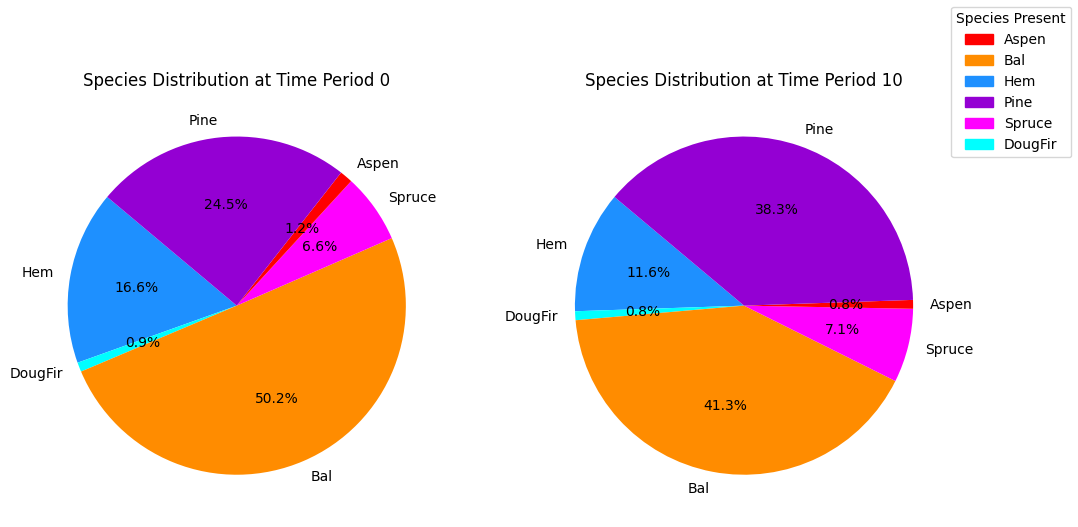

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_40%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.21s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

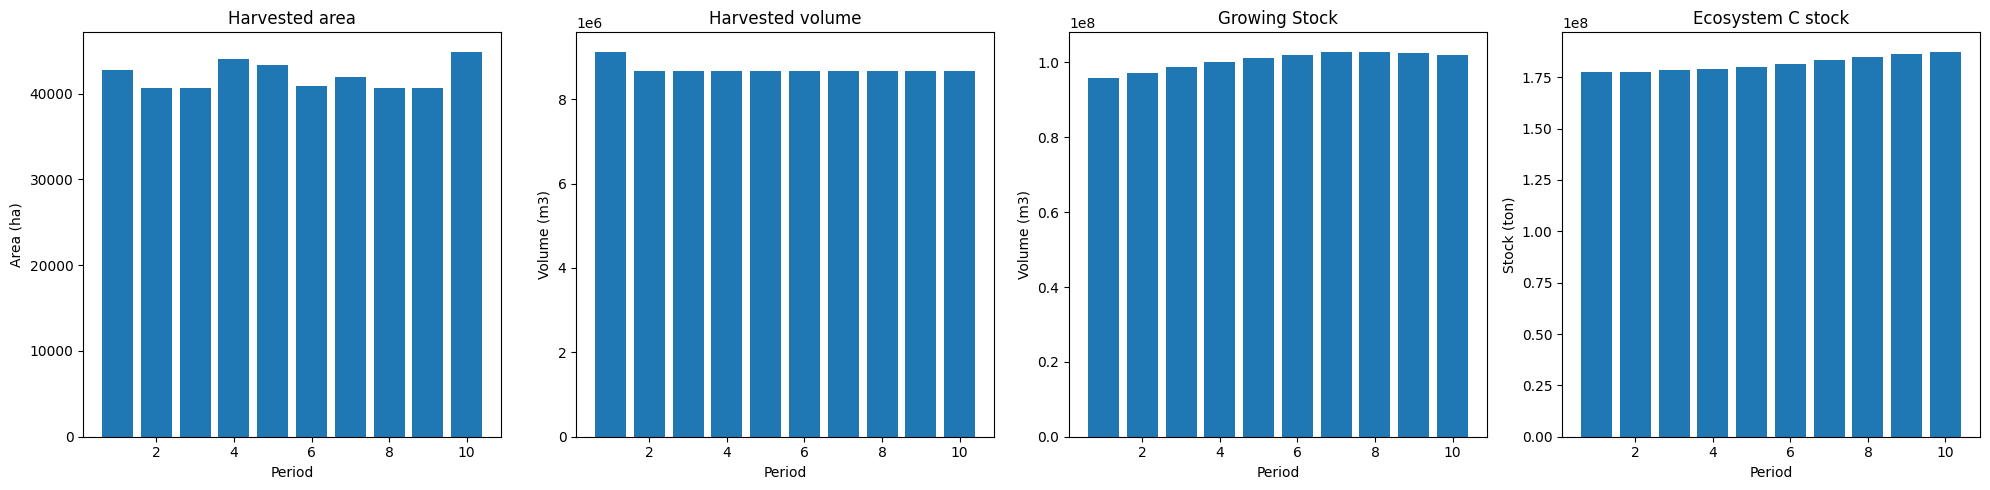

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


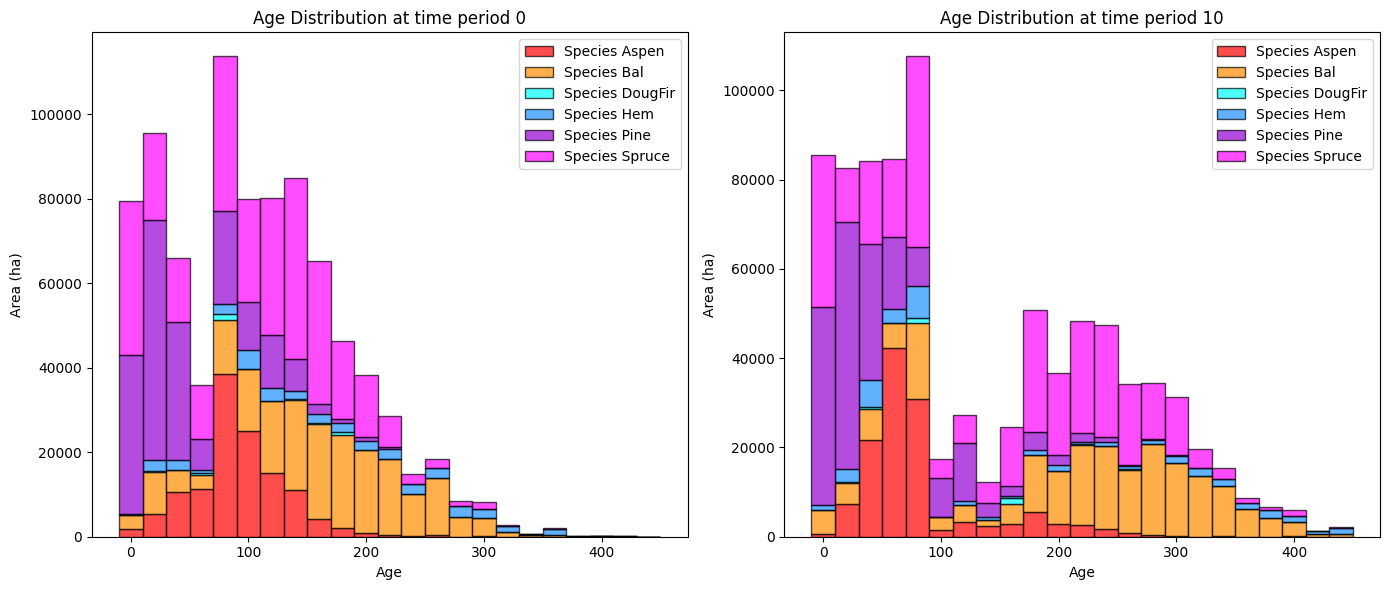

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


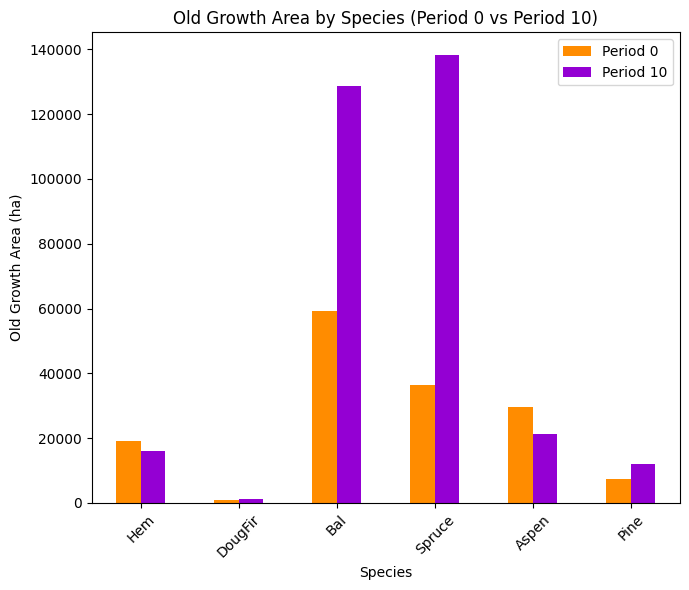

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


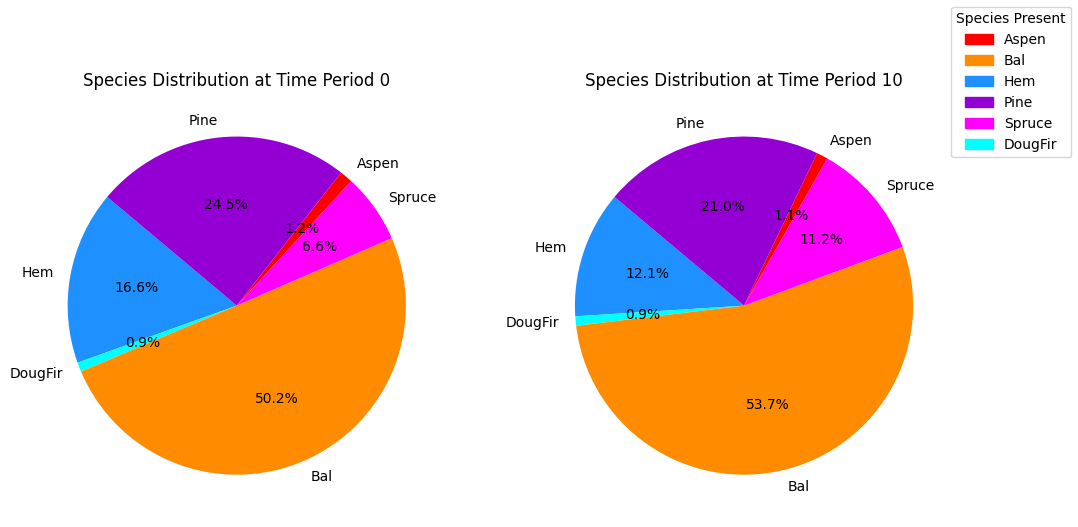

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


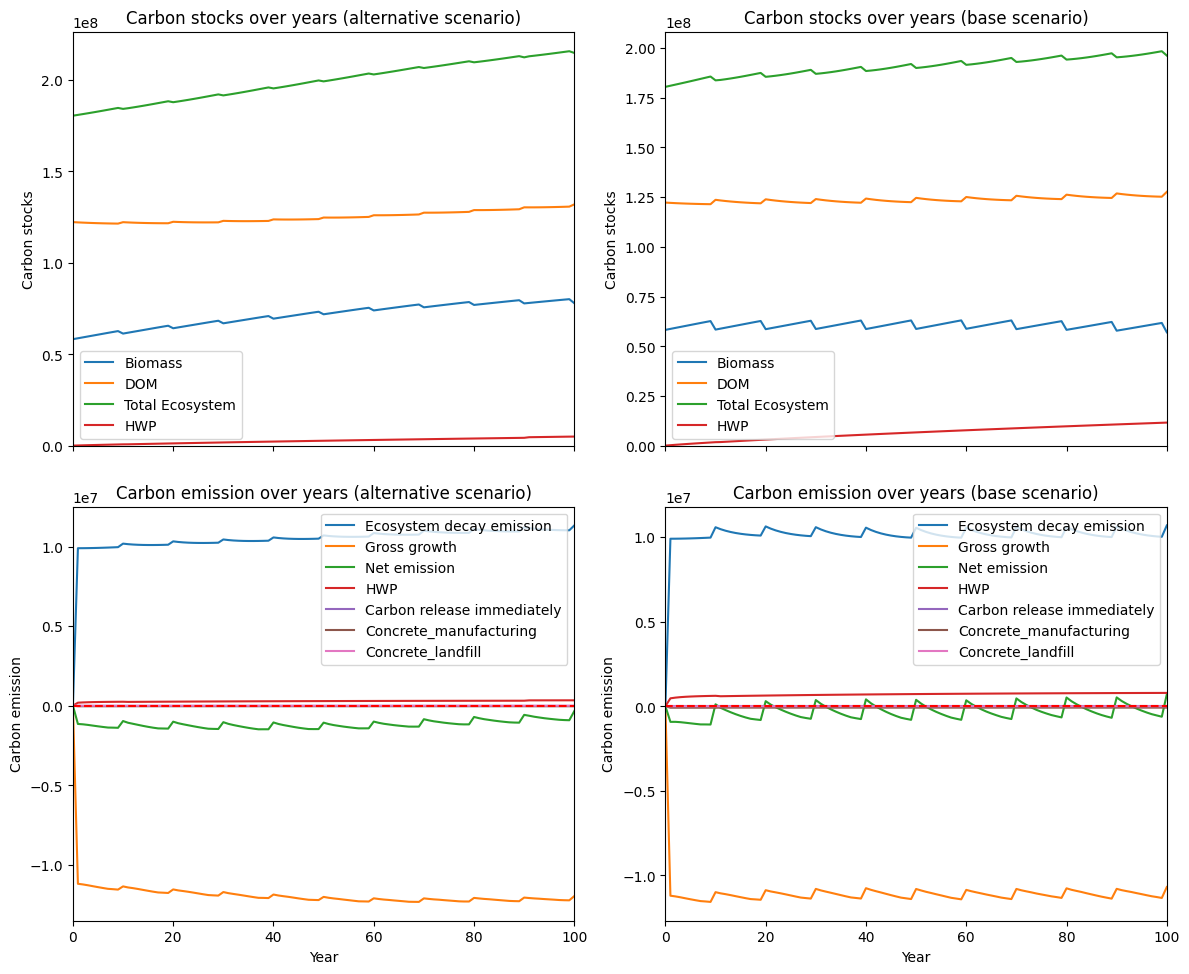

---------------------------------------------------------------------------------------
Net emission difference -82888537.98707317
Net emission base scenario -34255783.53595837
Net emission alternative scenario -117144321.52303155
dollar_per_ton is:  0.12064394236944491
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  10794.411295  10794.411295
DougFir  0.0   1449.995570   1449.995570
Bal      0.0  24213.702938  24213.702938
Spruce   0.0  55352.265227  55352.265227
Aspen    0.0  23012.124460  23012.124460
Pine     0.0  41111.887958  41111.887958

Overall, the old growth area has **increased** by 155934.39 hectares in the alternative scenario compared to the base scenario.


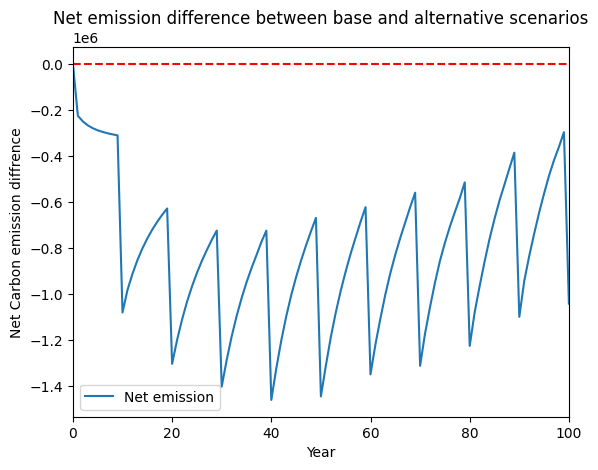

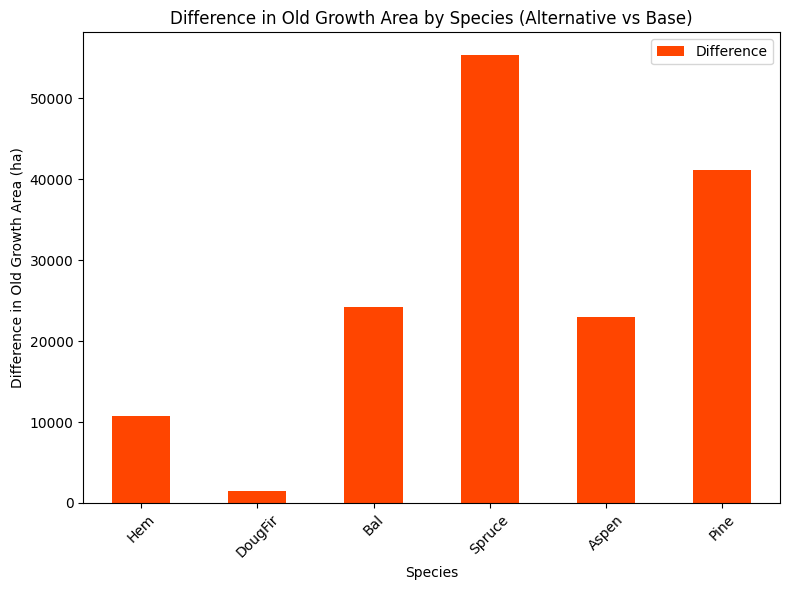

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


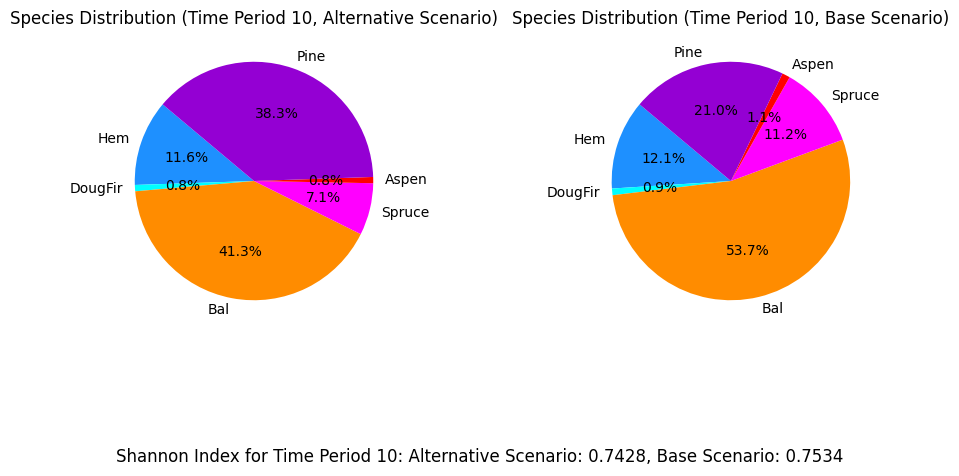

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_30%...
running the scenario for the Equity Silver mining site (30%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x89d03c1d
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.26s
Presolved: 8375 r

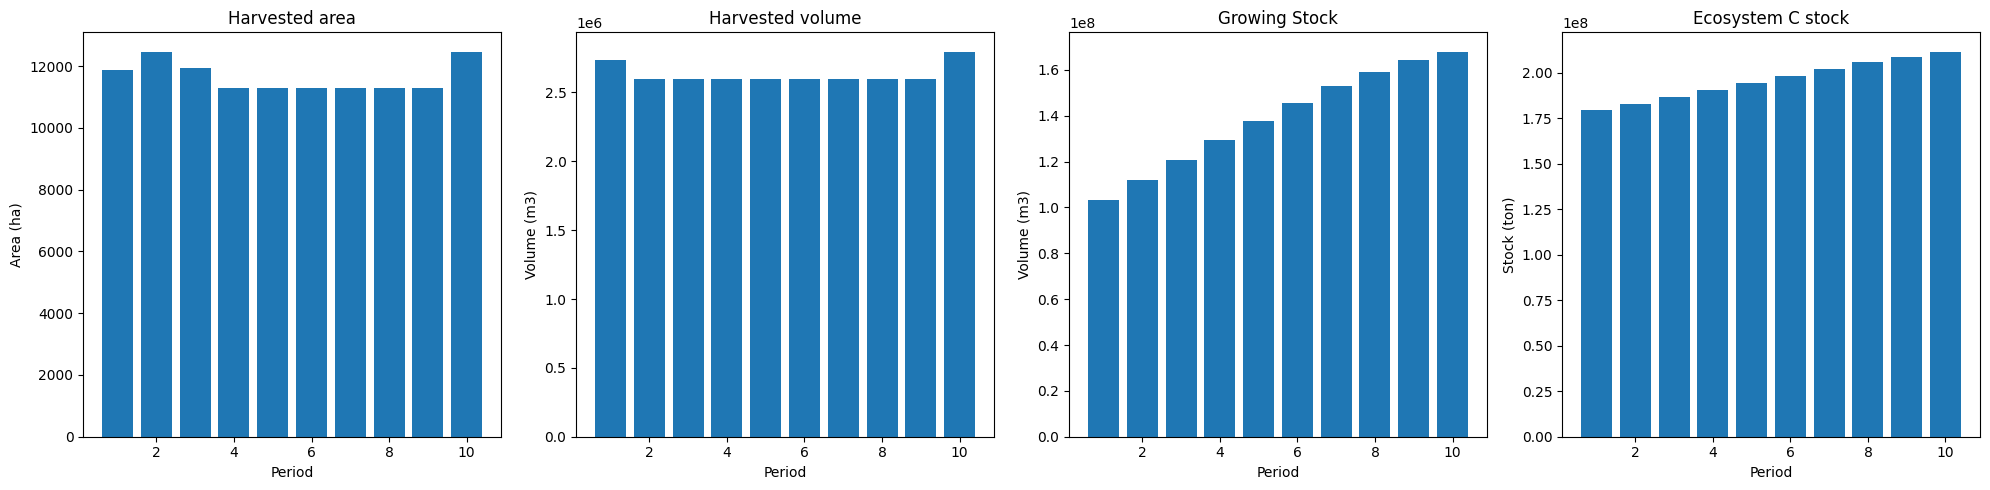

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_30%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  27854
The economic indicator (the provincial government revenues) is:  949882
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


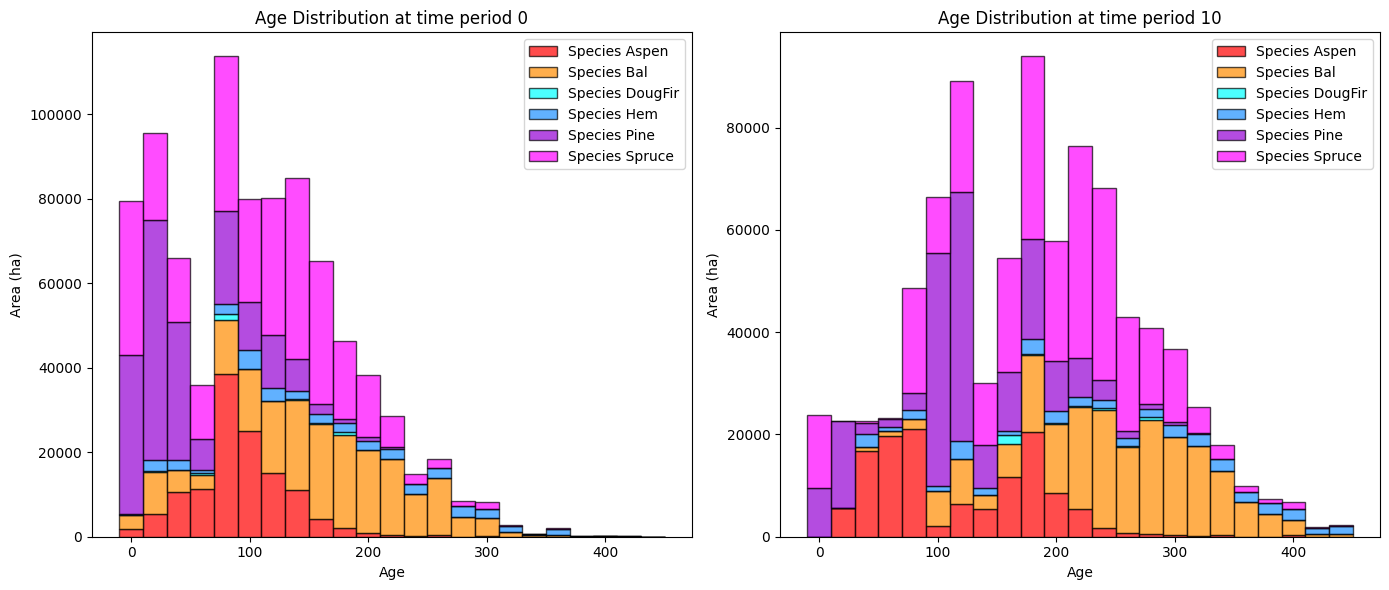

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_30%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   27982.199271    8830.072042
DougFir    947.047810    2749.298212    1802.250402
Bal      59315.970469  155239.182062   95923.211593
Spruce   36410.744598  196516.801041  160106.056443
Aspen    29632.731169   58016.671612   28383.940443
Pine      7432.733686   60093.210052   52660.476366

Old growth has **increased** by 347706.01 hectares from time period 0 to time period 10.


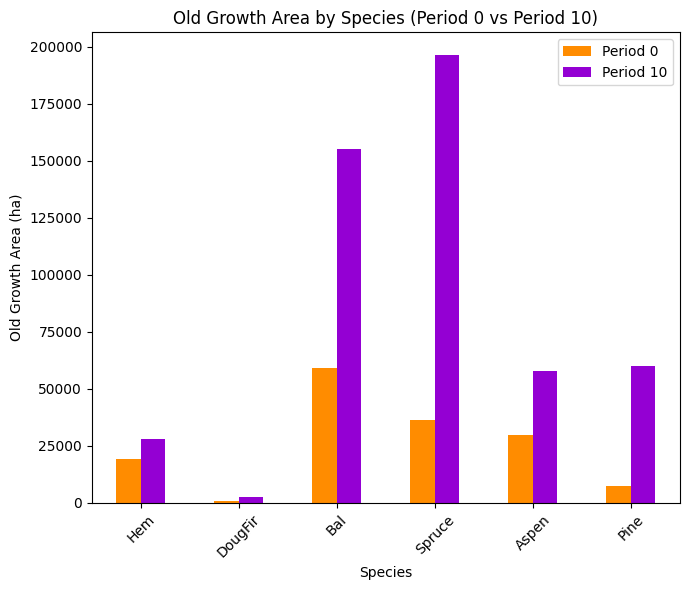

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_30%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7419

Diversity has **decreased** by 1.73% from time 0 to time 10.


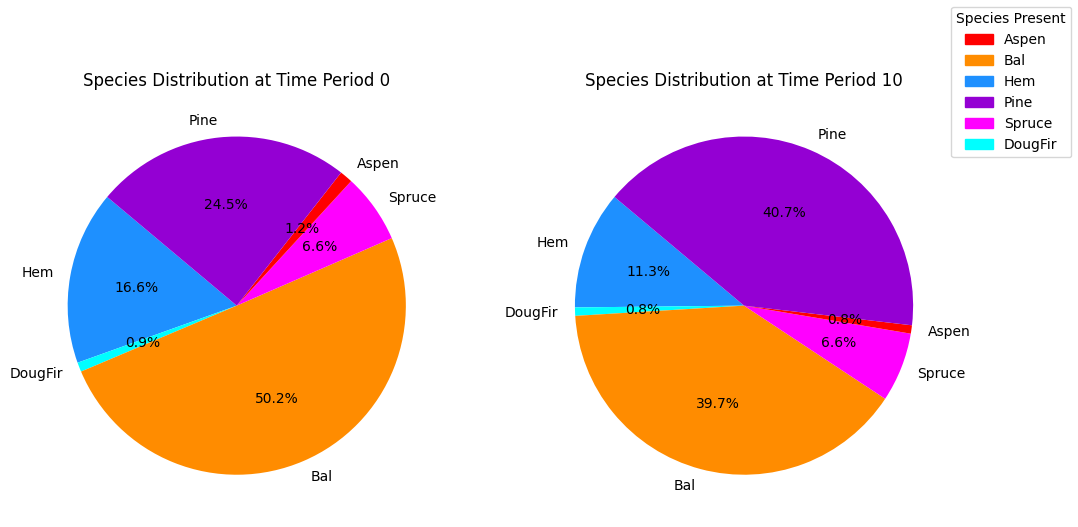

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_30%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.24s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

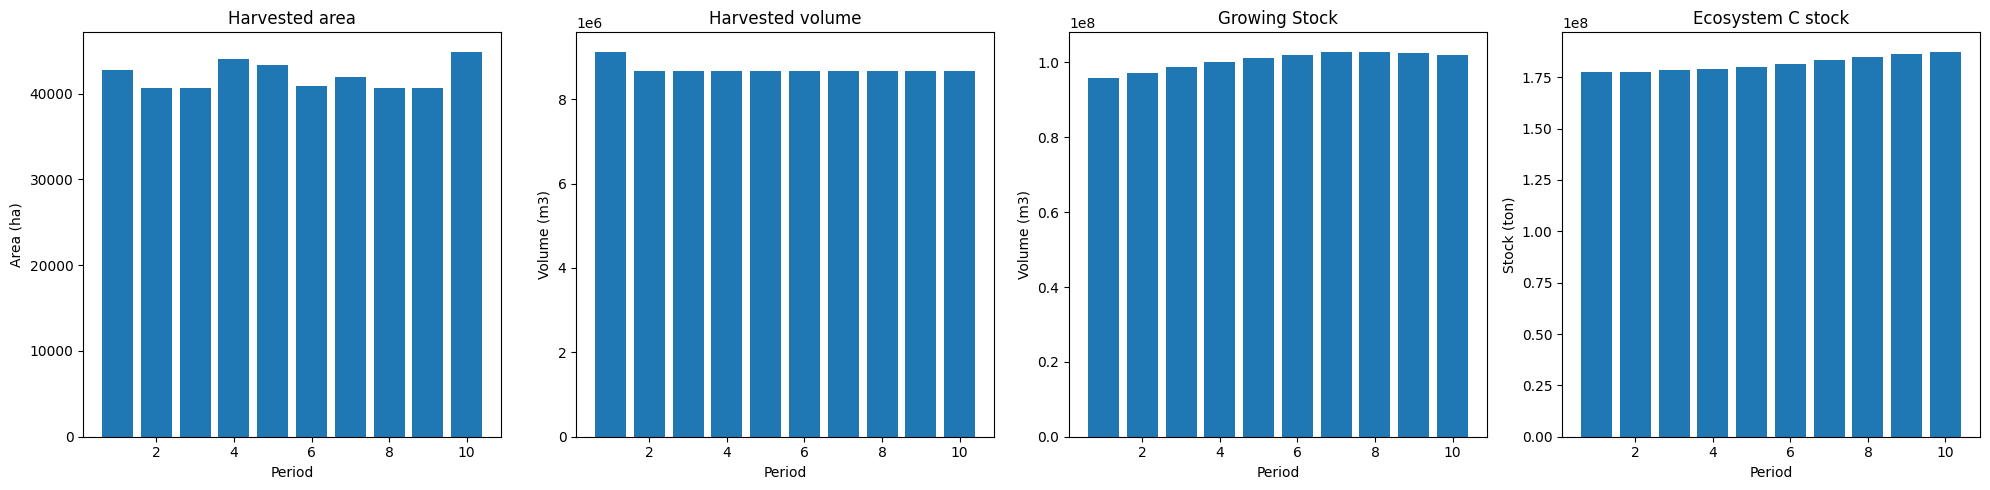

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


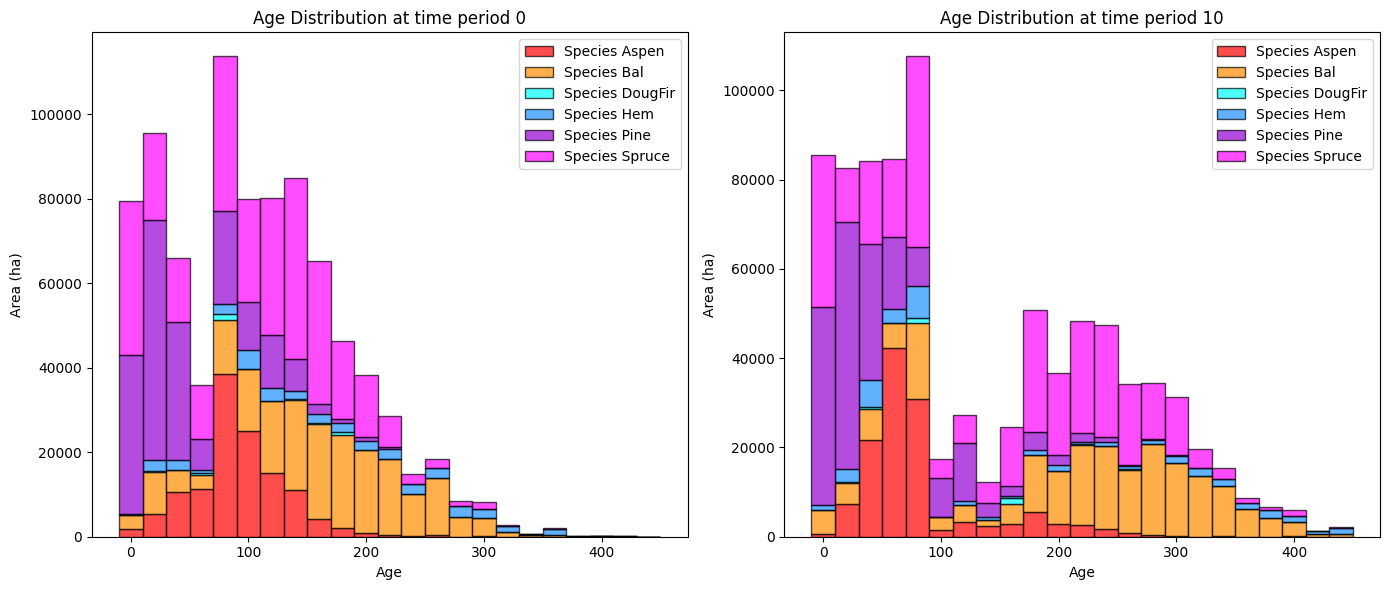

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


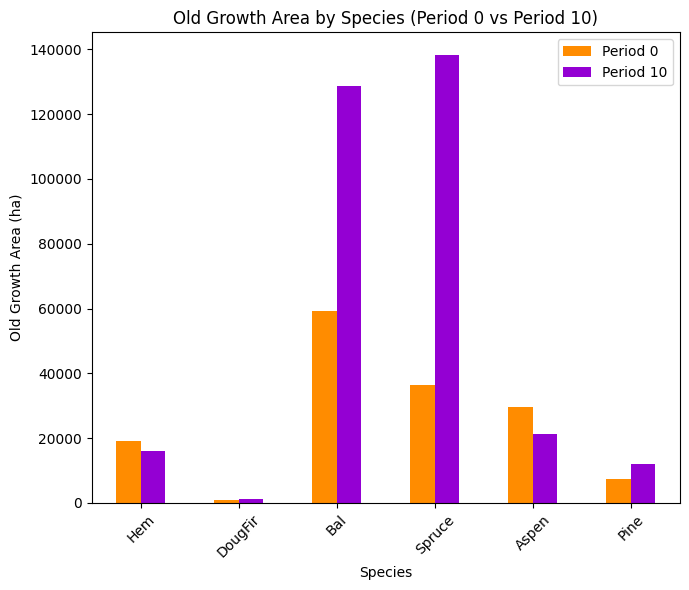

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


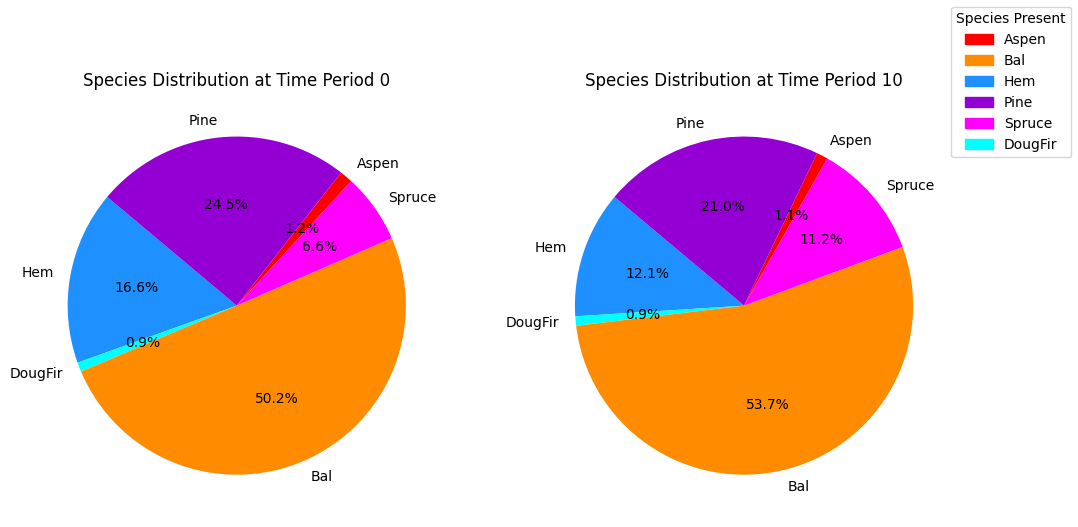

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


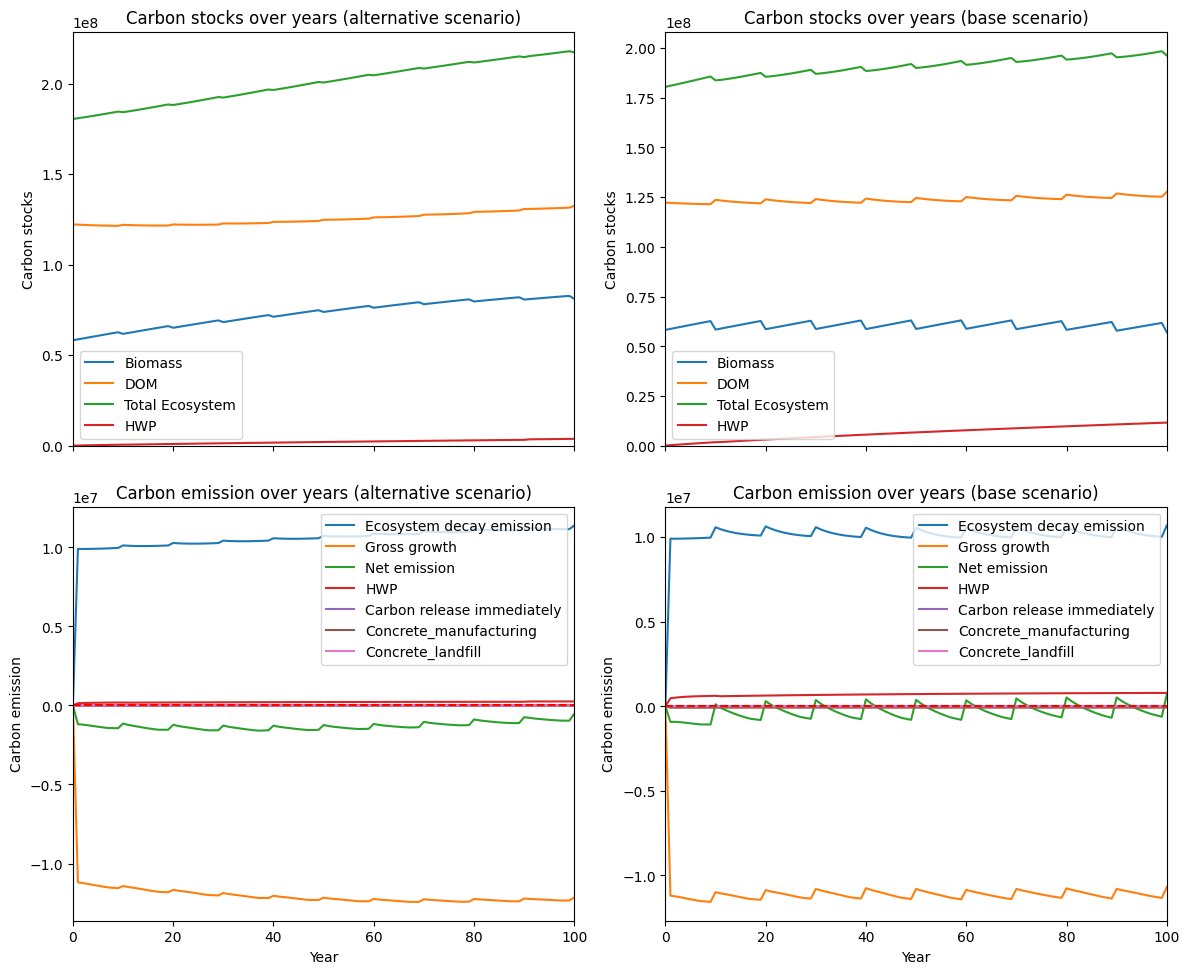

---------------------------------------------------------------------------------------
Net emission difference -94299533.14181617
Net emission base scenario -34255783.53595837
Net emission alternative scenario -128555316.67777452
dollar_per_ton is:  0.10604506371162088
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  11874.460552  11874.460552
DougFir  0.0   1449.995570   1449.995570
Bal      0.0  26433.184276  26433.184276
Spruce   0.0  58168.412754  58168.412754
Aspen    0.0  36812.412290  36812.412290
Pine     0.0  48190.175015  48190.175015

Overall, the old growth area has **increased** by 182928.64 hectares in the alternative scenario compared to the base scenario.


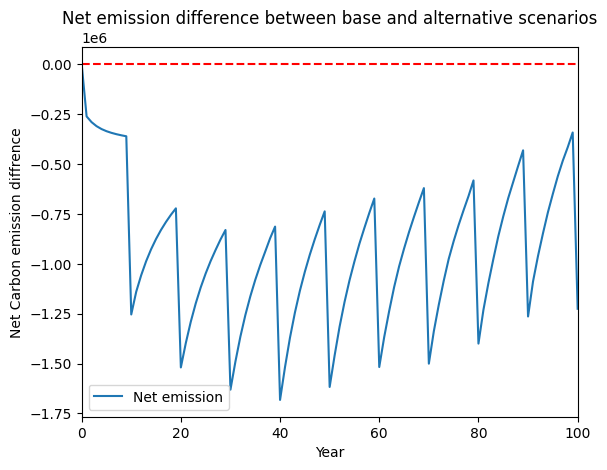

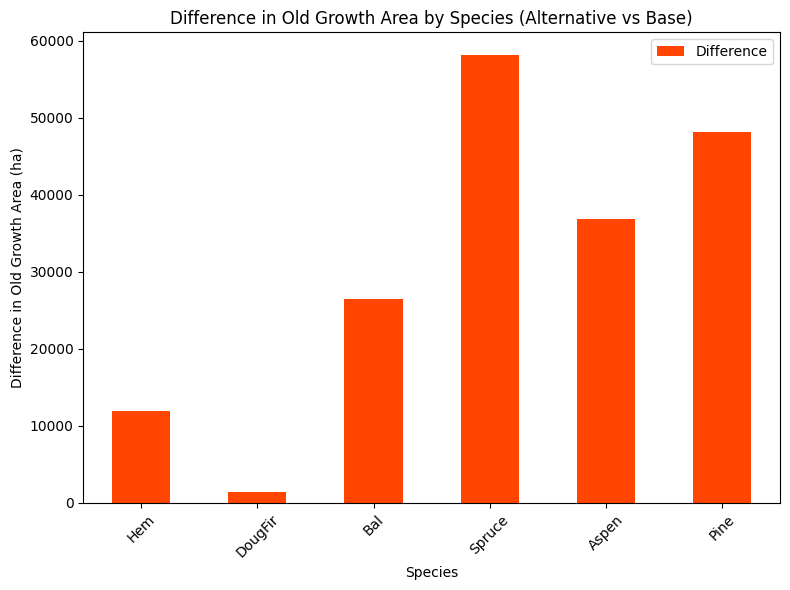

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


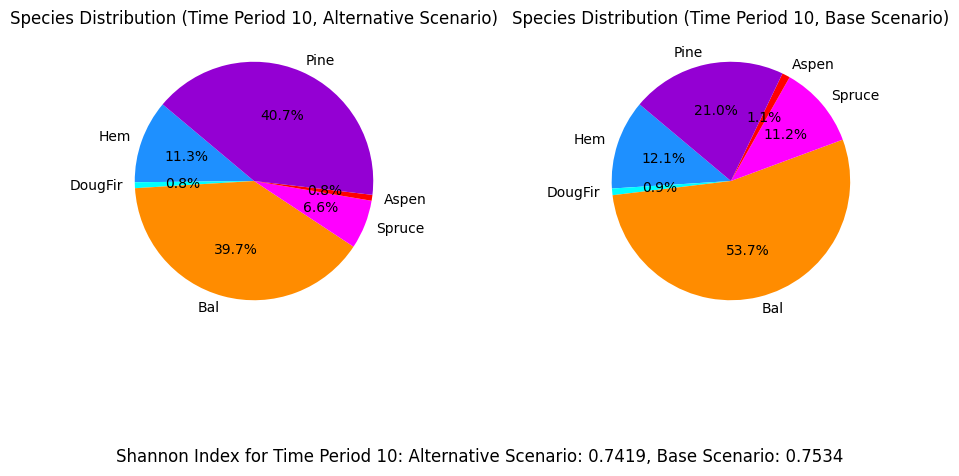

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_20%...
running the scenario for the Equity Silver mining site (20%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x3128a9ab
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.21s
Presolved: 8375 r

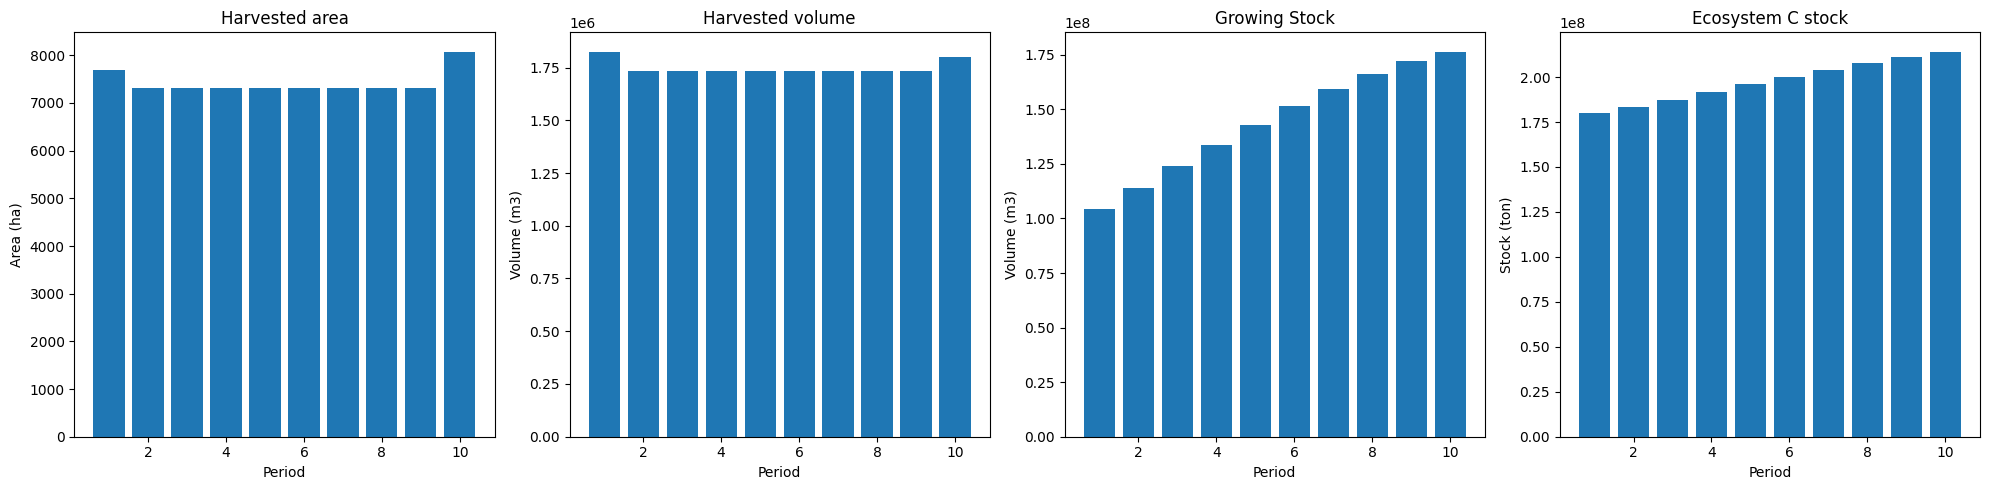

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_20%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  18498
The economic indicator (the provincial government revenues) is:  630844
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


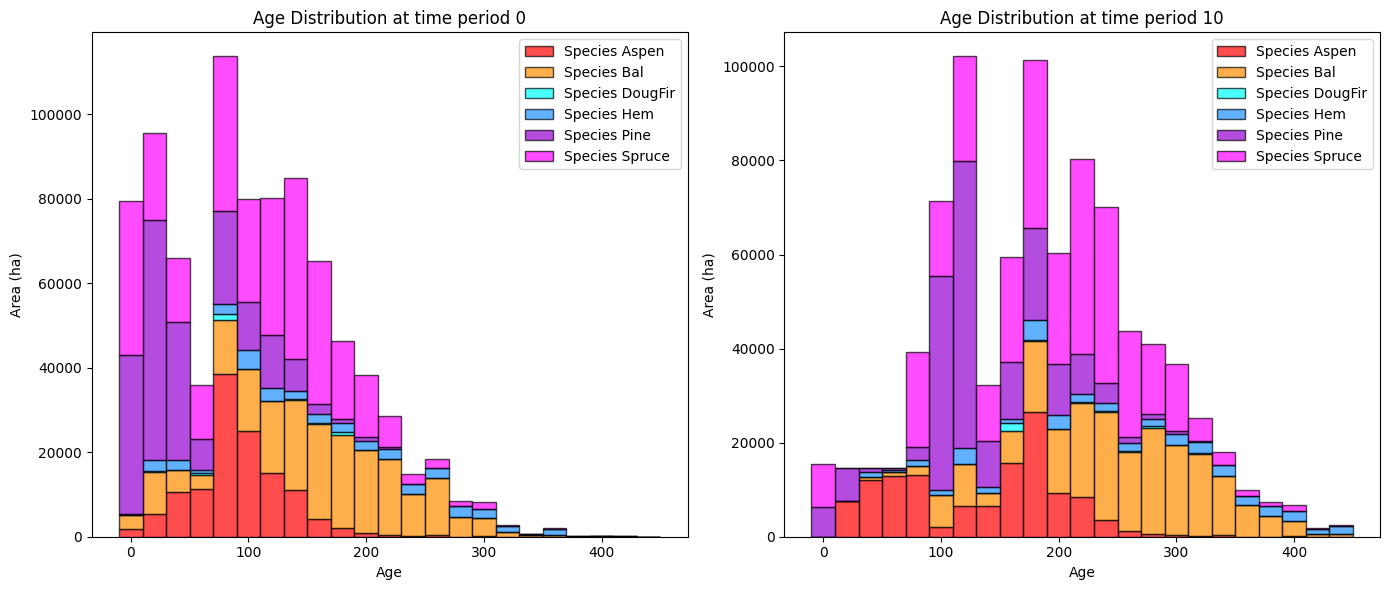

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_20%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   30063.125390   10910.998161
DougFir    947.047810    2749.298212    1802.250402
Bal      59315.970469  155448.119358   96132.148890
Spruce   36410.744598  197372.363134  160961.618536
Aspen    29632.731169   75305.932050   45673.200880
Pine      7432.733686   65971.933820   58539.200134

Old growth has **increased** by 374019.42 hectares from time period 0 to time period 10.


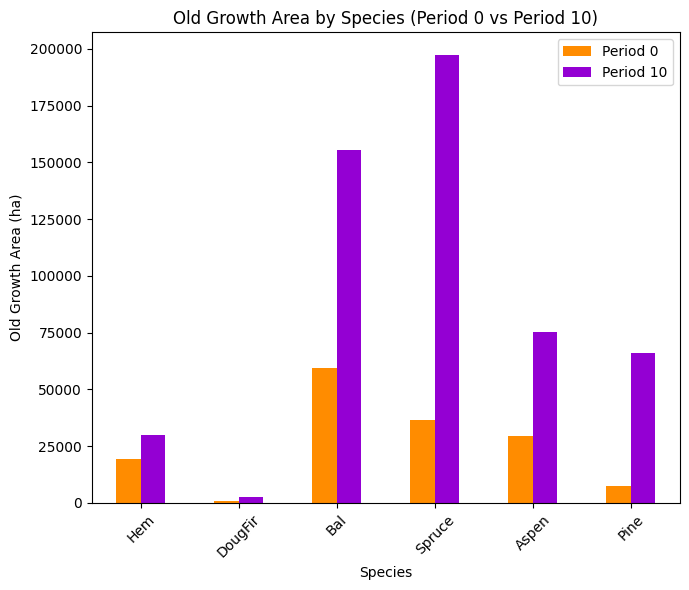

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_20%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7425

Diversity has **decreased** by 1.66% from time 0 to time 10.


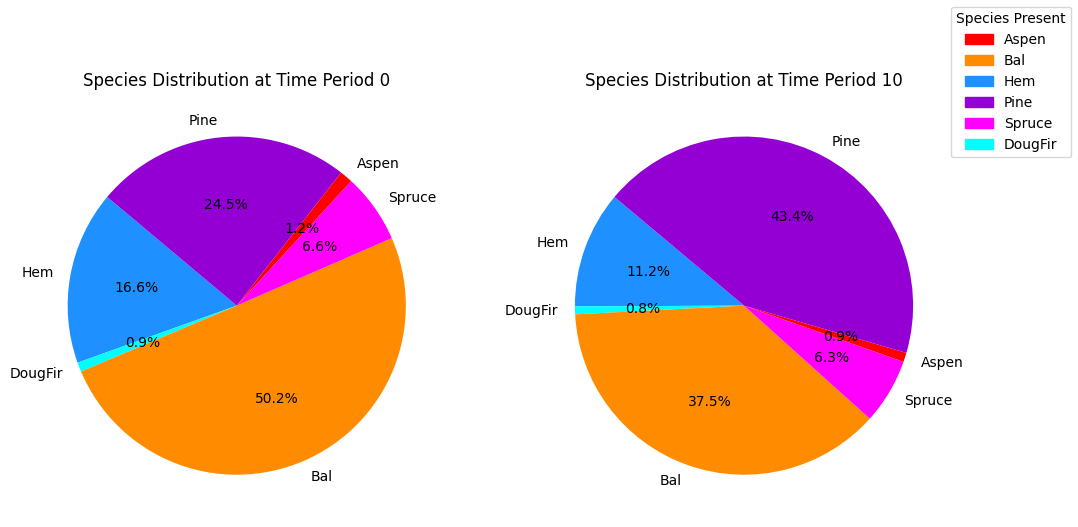

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_20%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.22s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

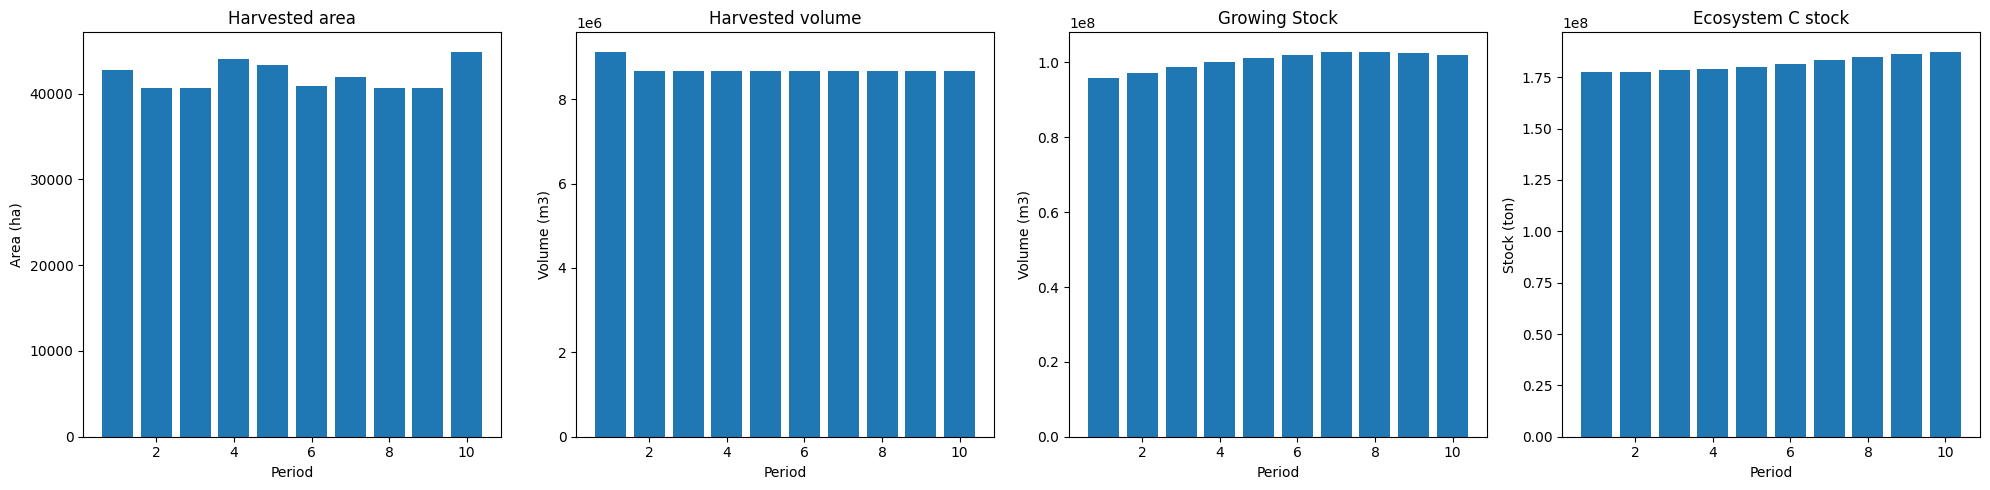

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


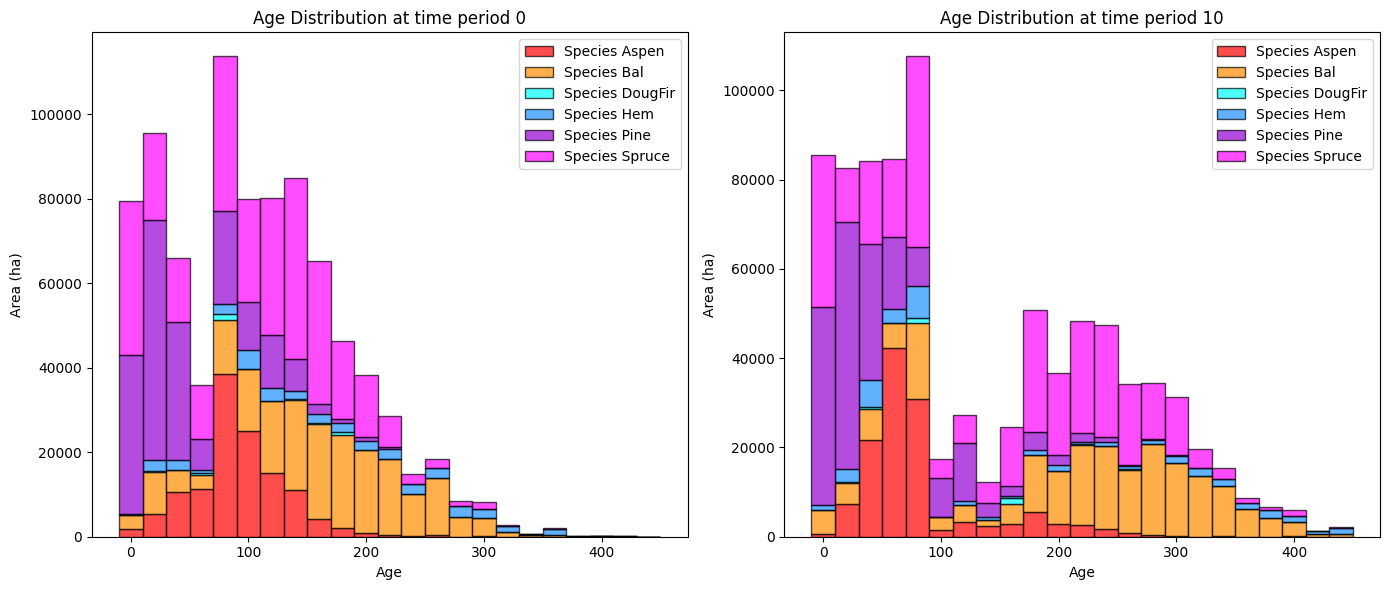

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


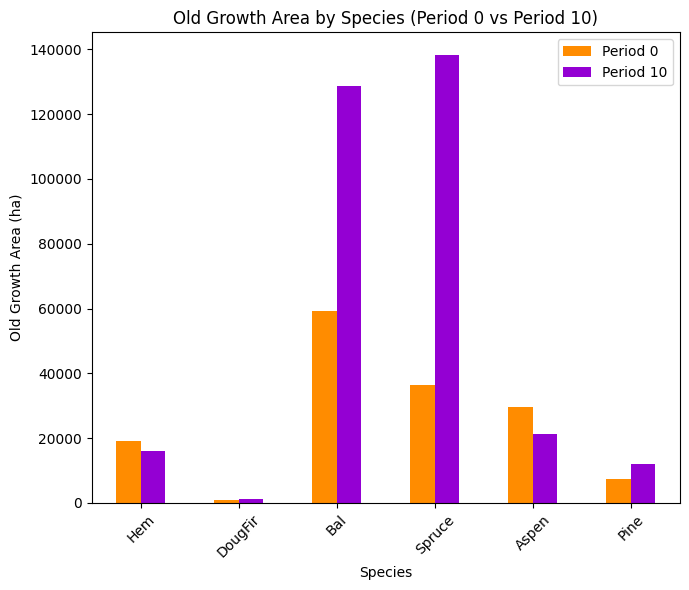

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


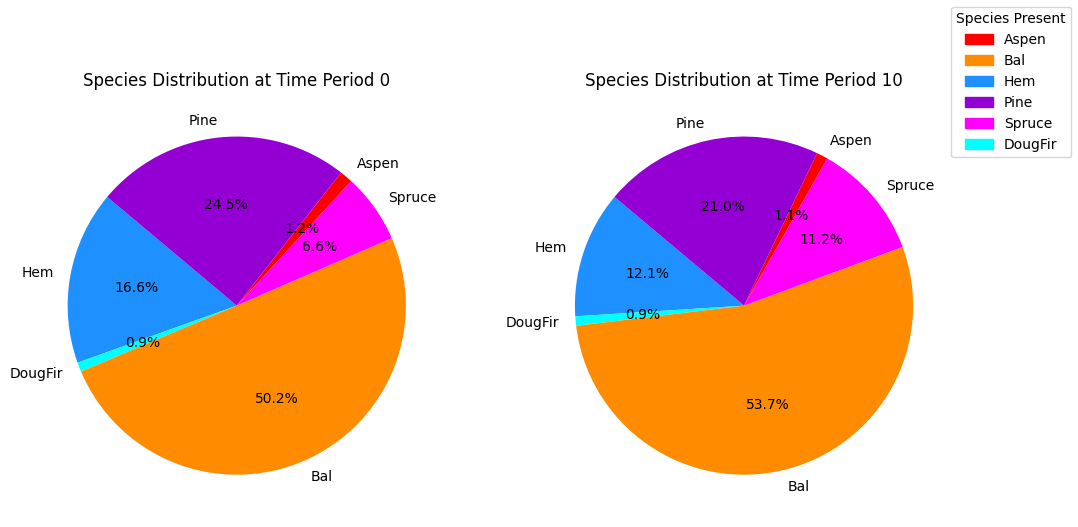

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


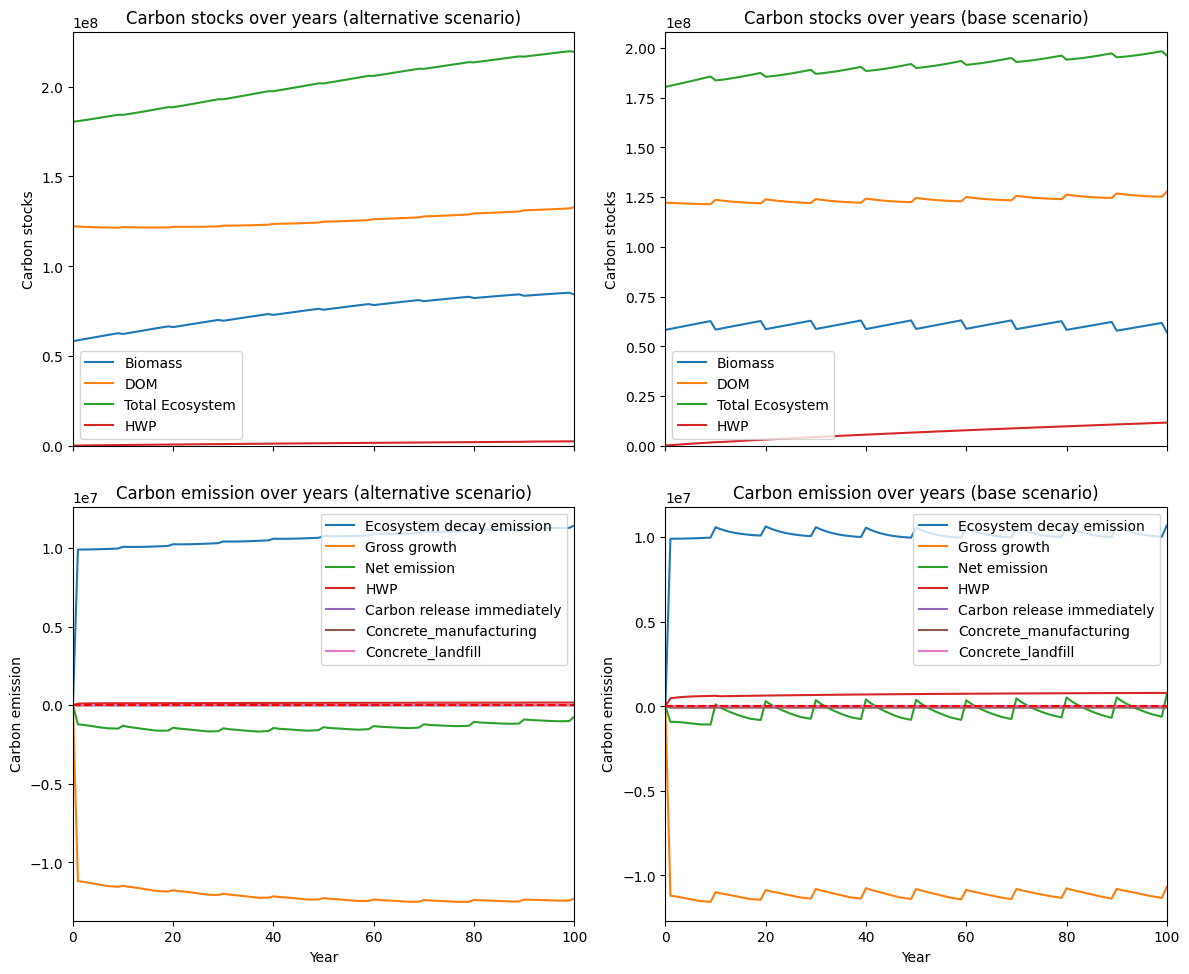

---------------------------------------------------------------------------------------
Net emission difference -104992597.38914993
Net emission base scenario -34255783.53595837
Net emission alternative scenario -139248380.9251083
dollar_per_ton is:  0.0952448100977585
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  13955.386671  13955.386671
DougFir  0.0   1449.995570   1449.995570
Bal      0.0  26642.121572  26642.121572
Spruce   0.0  59023.974847  59023.974847
Aspen    0.0  54101.672727  54101.672727
Pine     0.0  54068.898784  54068.898784

Overall, the old growth area has **increased** by 209242.05 hectares in the alternative scenario compared to the base scenario.


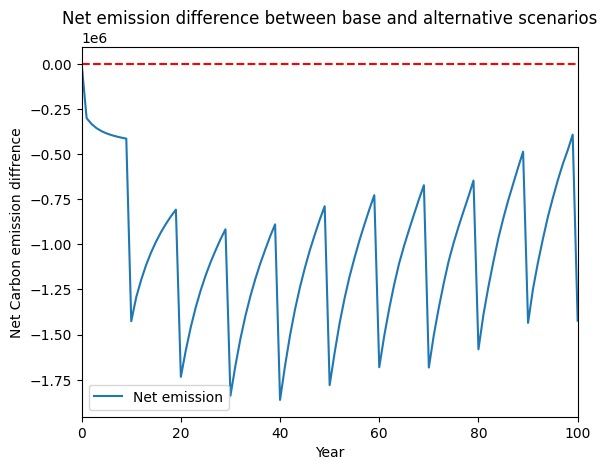

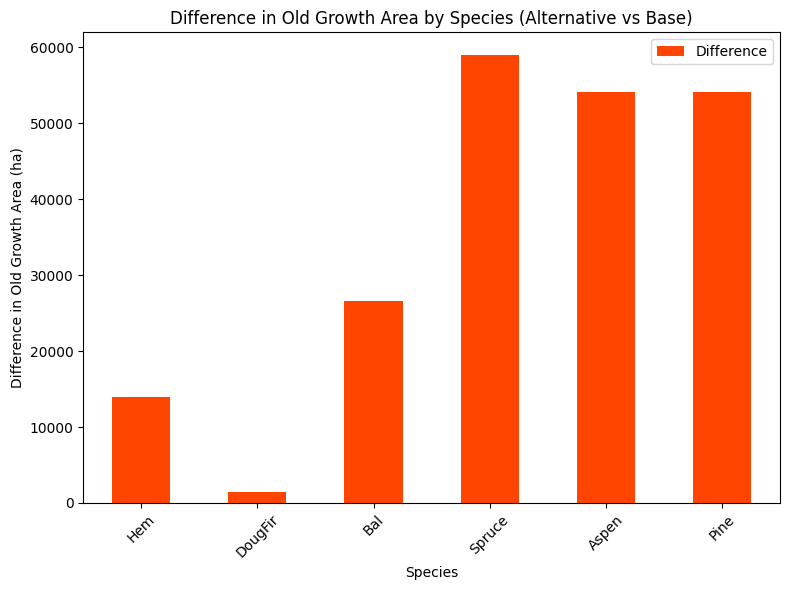

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


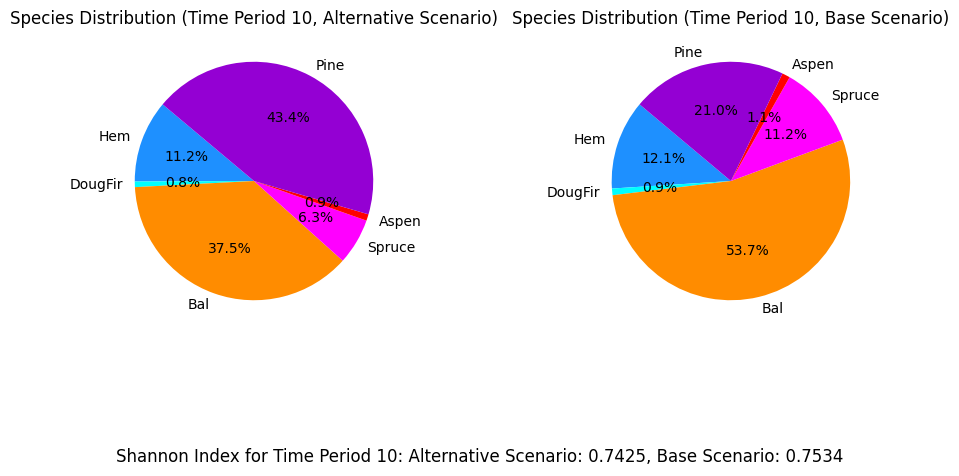

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for equitysilver_max_st_eqtslvr_AAC_10%...
running the scenario for the Equity Silver mining site (10%_AAC),
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0x091b357e
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.29s
Presolved: 8375 r

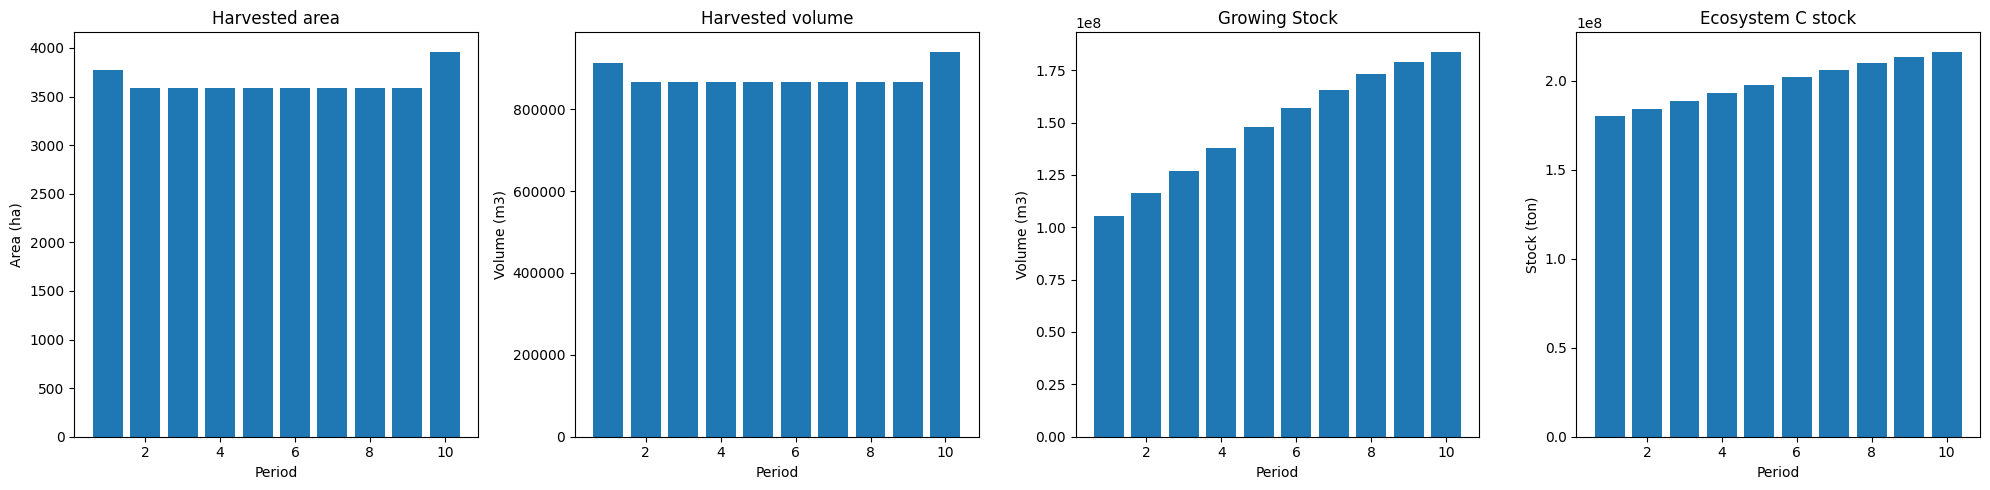

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_10%_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  9293
The economic indicator (the provincial government revenues) is:  316931
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.


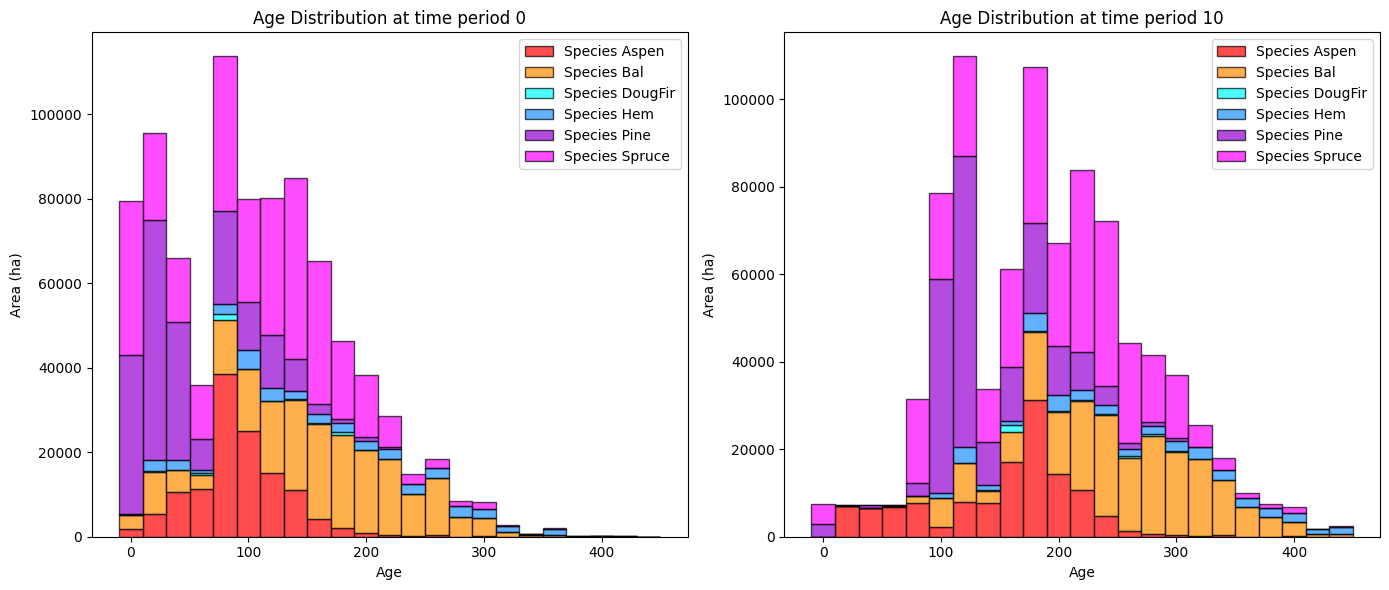

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_10%_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   32688.964561   13536.837333
DougFir    947.047810    2749.298212    1802.250402
Bal      59315.970469  157134.400906   97818.430437
Spruce   36410.744598  198257.581563  161846.836965
Aspen    29632.731169   92126.586599   62493.855430
Pine      7432.733686   69570.325557   62137.591871

Old growth has **increased** by 399635.80 hectares from time period 0 to time period 10.


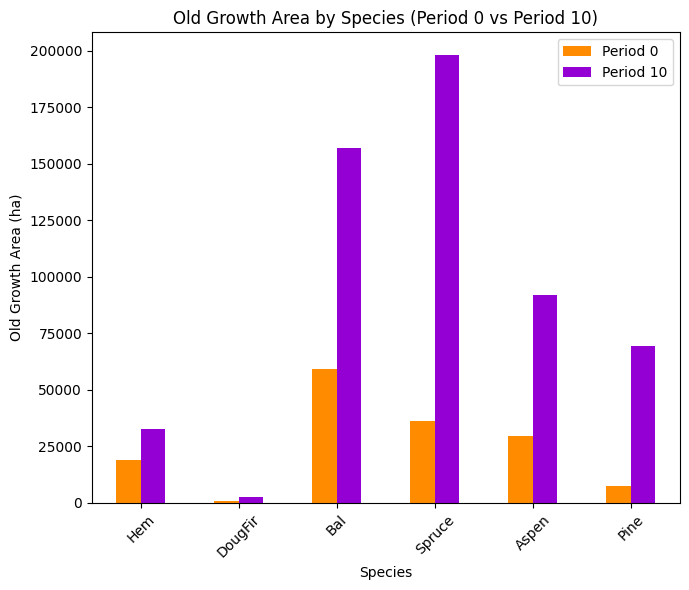

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_10%_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7429

Diversity has **decreased** by 1.62% from time 0 to time 10.


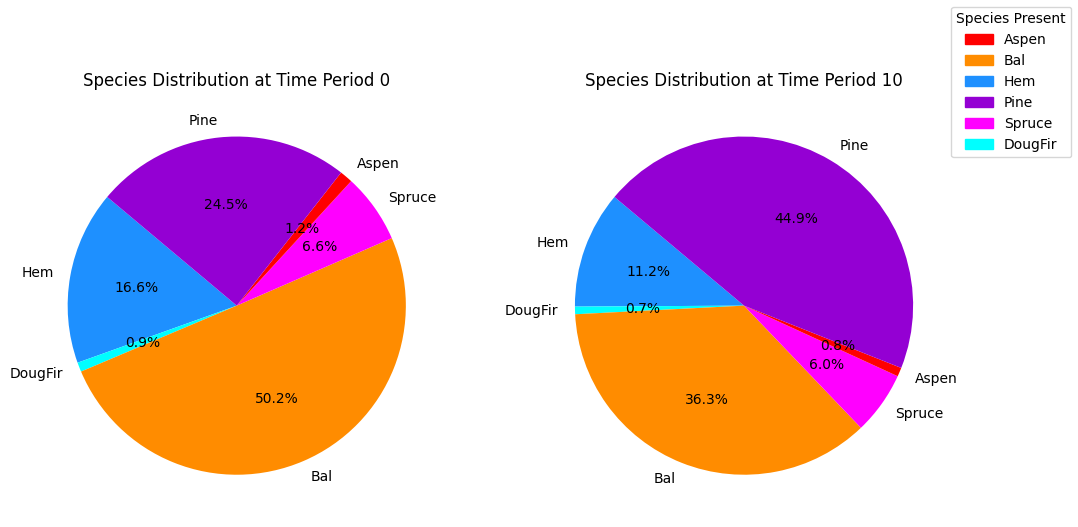

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_eqtslvr_AAC_10%_species_pie.pdf
running business as usual scenario for the Equity Silver mining site
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17067 rows, 83258 columns and 631504 nonzeros
Model fingerprint: 0xd9cb0018
Coefficient statistics:
  Matrix range     [5e-03, 7e+05]
  Objective range  [3e+00, 7e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 8692 rows and 8884 columns
Presolve time: 0.28s
Presolved: 8375 rows, 74375 columns, 536310 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Or

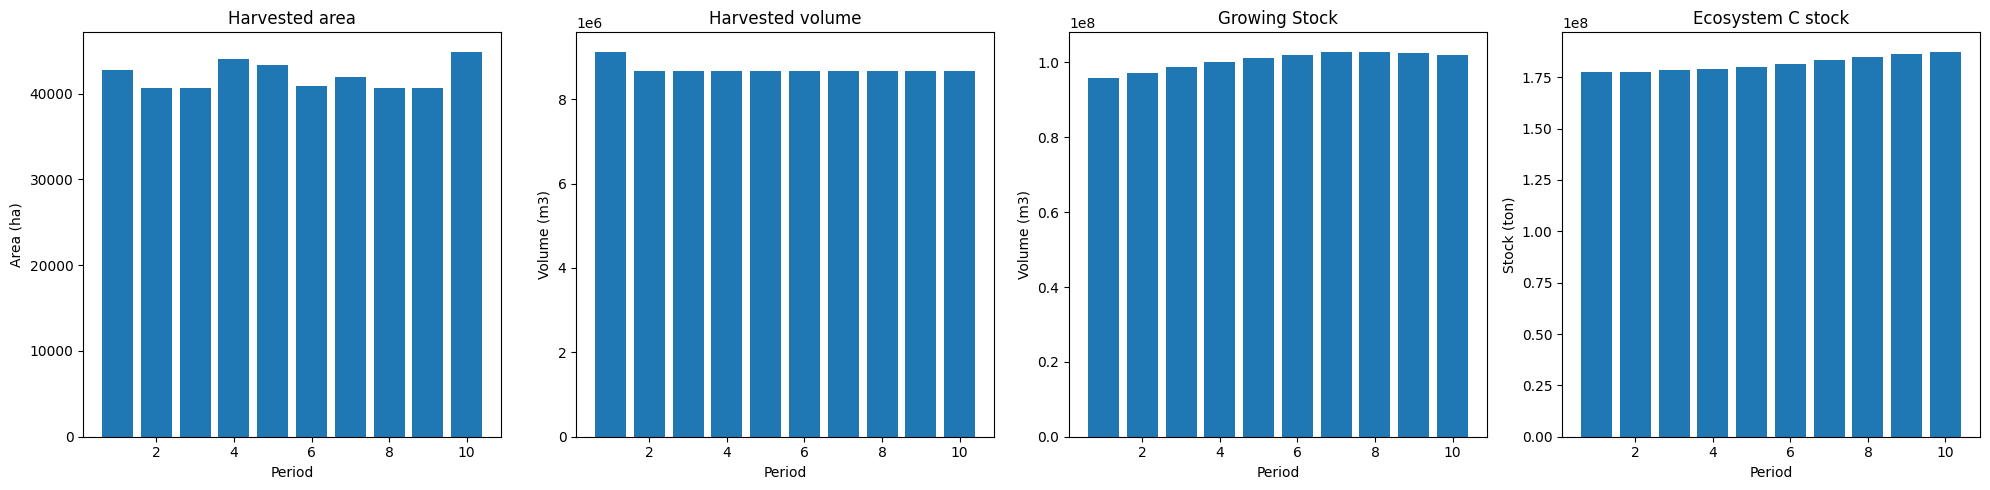

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_scheduling_maxstock.pdf
------------------------------------------------
The scocial indicator (the number of job creation) is:  92157
The economic indicator (the provincial government revenues) is:  3142756
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.


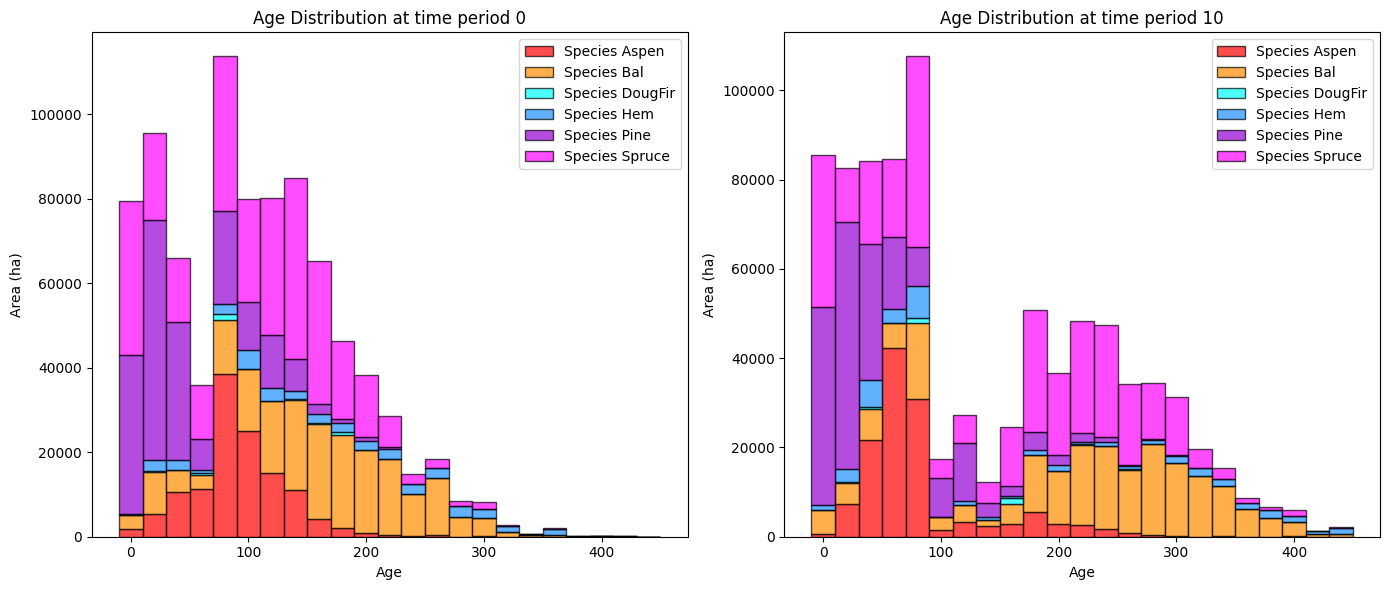

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                    0             10     Difference
Hem      19152.127229   16107.738719   -3044.388510
DougFir    947.047810    1299.302642     352.254832
Bal      59315.970469  128805.997786   69490.027317
Spruce   36410.744598  138348.388287  101937.643689
Aspen    29632.731169   21204.259323   -8428.471846
Pine      7432.733686   11903.035037    4470.301351

Old growth has **increased** by 164777.37 hectares from time period 0 to time period 10.


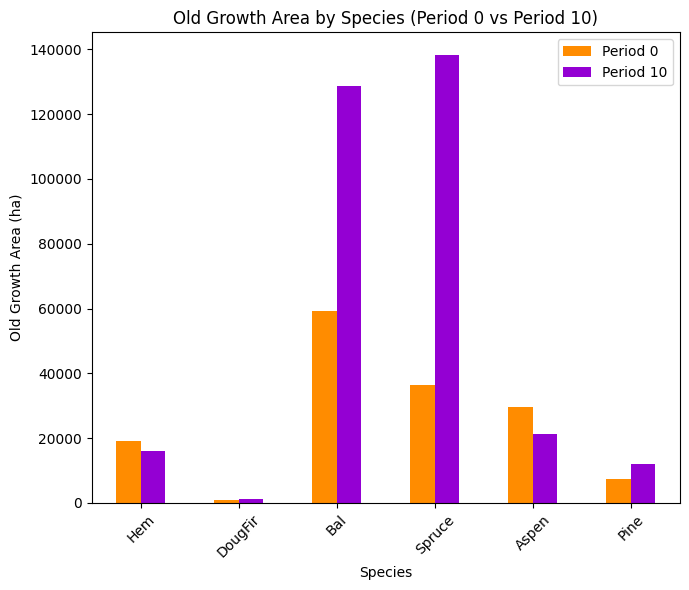

Clustered column plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_old_growth_comparison.pdf

Shannon Evenness Index for time period 0: 0.7592
Shannon Evenness Index for time period 10: 0.7534

Diversity has **decreased** by 0.58% from time 0 to time 10.


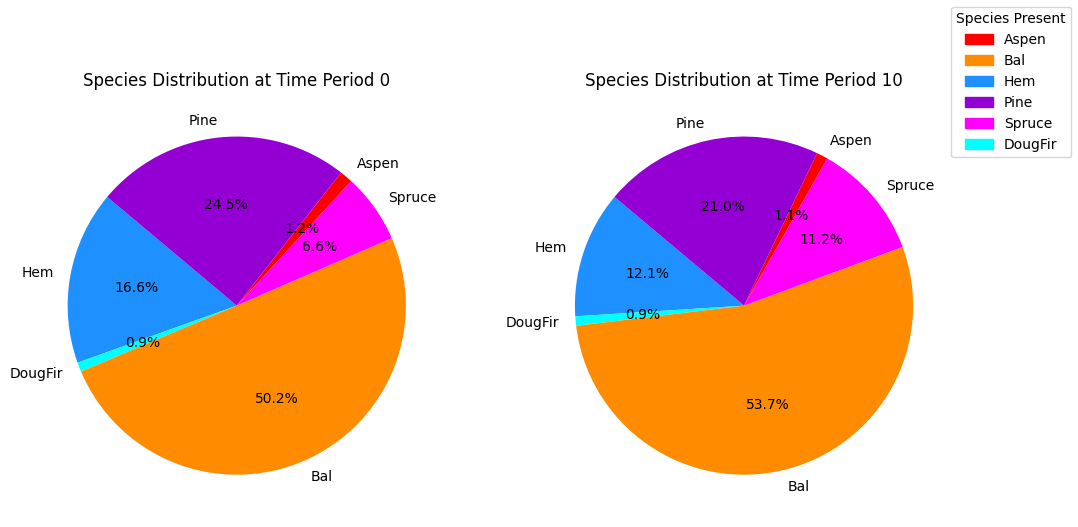

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_bau_eqtslvr_species_pie.pdf


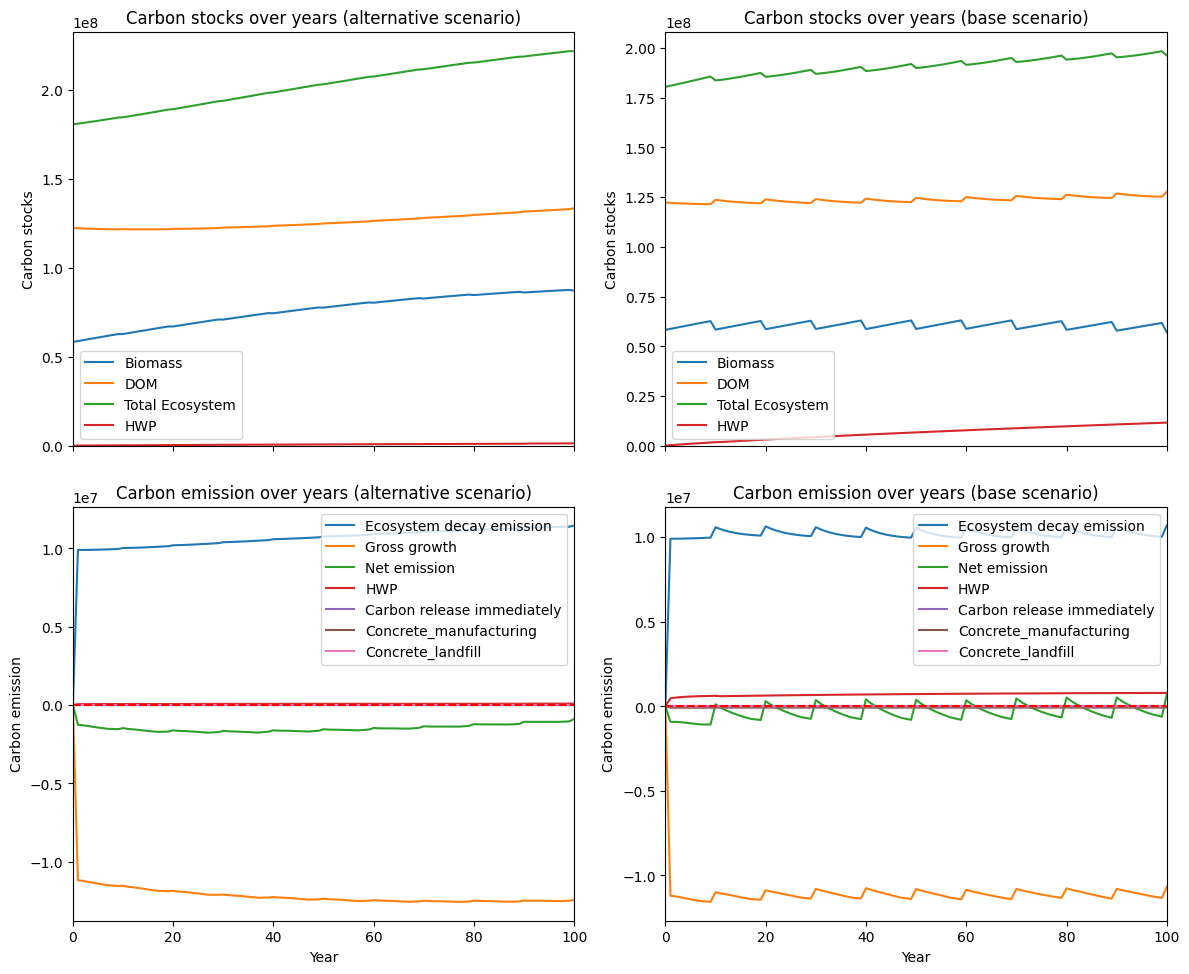

---------------------------------------------------------------------------------------
Net emission difference -114210344.67592473
Net emission base scenario -34255783.53595837
Net emission alternative scenario -148466128.21188313
dollar_per_ton is:  0.08755774293804383
Comparison of Old Growth Areas (Alternative - Base)
           0            10    Difference
Hem      0.0  16581.225843  16581.225843
DougFir  0.0   1449.995570   1449.995570
Bal      0.0  28328.403120  28328.403120
Spruce   0.0  59909.193276  59909.193276
Aspen    0.0  70922.327277  70922.327277
Pine     0.0  57667.290521  57667.290521

Overall, the old growth area has **increased** by 234858.44 hectares in the alternative scenario compared to the base scenario.


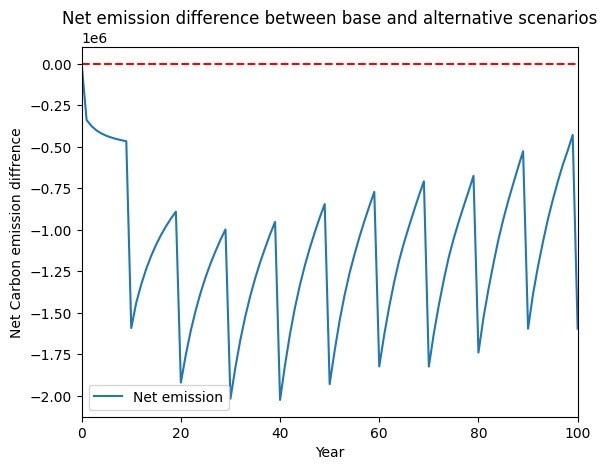

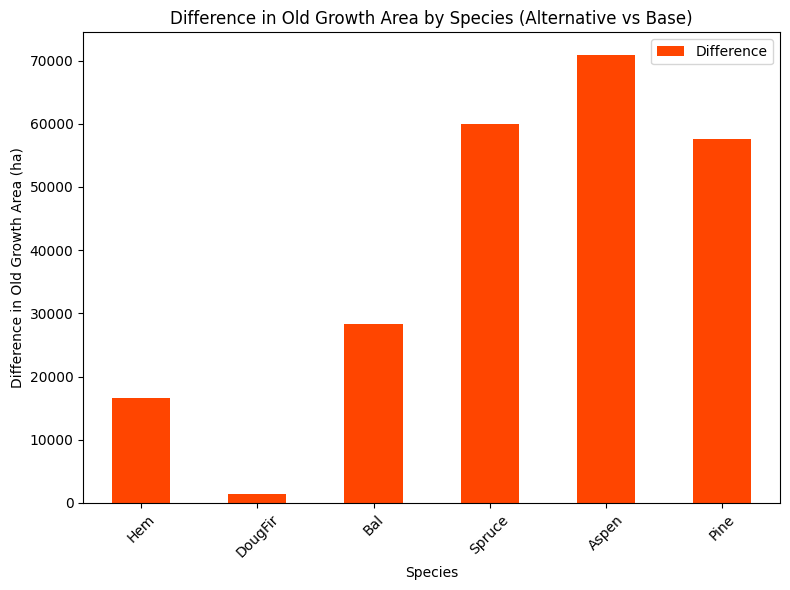

<Figure size 640x480 with 0 Axes>

Plot saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_age_difference.pdf


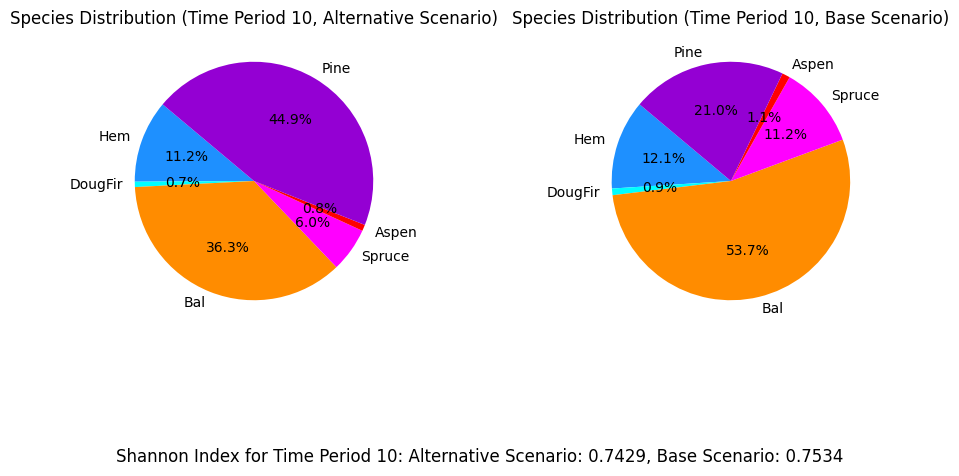

Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/equitysilver/equitysilver_max_st_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
It took 116.9 minutes to run all scenarios.


In [14]:
Start = time.time()
scenario_names = ['eqtslvr_AAC_40%', 'eqtslvr_AAC_30%', 'eqtslvr_AAC_20%', 'eqtslvr_AAC_10%']
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode,                   
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")